In [1]:
#//*** GEOPANDAS sources
#https://jcutrer.com/python/learn-geopandas-plotting-usmaps
#https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html
#https://towardsdatascience.com/lets-make-a-map-using-geopandas-pandas-and-matplotlib-to-make-a-chloropleth-map-dddc31c1983d
#https://geopandas.org/docs/user_guide/mapping.html

#//*** Build Custom Color Gradients
#https://coolors.co/gradient-palette/ffffff-e0472b?number=9

#//*** pandas_bokeh
#//*** https://pythonawesome.com/bokeh-plotting-backend-for-pandas-and-geopandas/

#//*** Clean geopandas install
#//***conda create -n geopandas -c conda-forge python=3.8 geopandas

Hospitalization research:
Data.gov search for tag: hhs-covid-19

posible lead: https://healthdata.gov/dataset/COVID-19-Reported-Patient-Impact-and-Hospital-Capa/4cnb-m4rz

possible lead individual facility breakdown by week May - October 2021: https://healthdata.gov/dataset/COVID-19-Hospital-Data-Coverage-Report-v4wn-auj8-A/ewep-8fwa

This look like State Level Data: https://healthdata.gov/Hospital/COVID-19-Reported-Patient-Impact-and-Hospital-Capa/g62h-syeh

Data CSV Link: https://healthdata.gov/api/views/g62h-syeh/rows.csv?accessType=DOWNLOAD

Healthdata.gov Hospitalization Search: https://healthdata.gov/browse?q=hospitalization&sortBy=relevance

Hospital Facility TimeSeries: https://healthdata.gov/Hospital/COVID-19-Reported-Patient-Impact-and-Hospital-Capa/anag-cw7u


Other Sources:
 - COVID-19 State and County Policy Orders (infographic?): https://catalog.data.gov/dataset/covid-19-state-and-county-policy-orders-9408a

- [Graph: Infographic Visualization](#infographic_visualization)

<a id="top"></a> 
## Internal Links ##

- Working [working](#working).

- [Load/Rebuild County Level Combined Data Set: Vaccination, Cases, Deaths: rebuild county_daily_df](#rebuild_county_daily_df)

- [Load/Rebuild State Level Combined Data Set: Vaccination, Cases, Deaths: rebuild state_daily_df](#rebuild_state_daily_df)

- [ Build State Level: state_case_death_df - cases & deaths only ](#build_state_case_death_df)

- [ Load or Rebuild County Level Vaccine Data Set: county_vax_df](#rebuild_county_vax_df)

- [ USA Vaccines ](#build_USA_Vaccines)

- [ Build Vaccine Tiers: County Data: county_tier_df](#build_tiers_county)

- [Build Vaccine Tiers: Statewide Data](#build_tiers_statewide)

- [ Build: hospital_df ](#build_hospital_df)

- [ Build: state_hosp_tiers_df](#state_hosp_tiers_df)

## Analyze ##
- [ Analyze State Hospitalization Tiers: state_hosp_tiers_df](#analyze_state_hosp_tiers_df)

## Graphs ##
- [ Blog Graphs ](#build_blog_graphs)

## HTML Processing ##


### CDC Community Transmission Guidelines

https://covid.cdc.gov/covid-data-tracker/#county-view



![](transmission_risk.png)

<a id="working"></a> 
# Working #

In [2]:
import os
import sys
# //*** Imports and Load Data
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
#//*** Use the whole window in the IPYNB editor
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import time 
import random
from PIL import Image

import shutil
import json

import geopandas as gpd

import bokeh
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import DatetimeTickFormatter
from bokeh.embed import components
from bokeh.models import ColumnDataSource, Grid, HBar, LinearAxis, Plot

import pandas_bokeh
pandas_bokeh.output_notebook()

#https://docs.bokeh.org/en/latest/docs/reference/models/formatters.html
#https://docs.bokeh.org/en/latest/docs/user_guide/embed.html

#//*** Bokeh Categorical Labels
#https://docs.bokeh.org/en/0.12.10/docs/user_guide/categorical.html

#//*** Color Palettes: https://docs.bokeh.org/en/latest/docs/reference/palettes.html
#//*** Hover Tools: https://docs.bokeh.org/en/latest/docs/user_guide/tools.html
from datetime import datetime
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from scipy.stats.stats import pearsonr
from sklearn.linear_model import LinearRegression
import matplotlib

#//*** Maximize columns and rows displayed by pandas
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)

pd.set_option('display.width', 200)

#//*** Holds 
out_plot = {}
out_stats = {}
out_images = []
out_exec_summary_images = []

med_figsize_x =634
med_figsize_y = 512

#df_list = []

#from sklearn import linear_model
#from math import sqrt
#from sklearn.metrics import mean_squared_error



Loading BokehJS ...

In [3]:
#"https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv"

#Hospitalizations - State
#https://www.cdc.gov/nhsn/covid19/report-patient-impact.html#anchor_1594393649
#DL: https://www.cdc.gov/nhsn/pdfs/covid19/covid19-NatEst.csv

# File Control #
 * use_cached_files = True - Use the Locally cached versions of the data
 * use_cached_files = False - Download updated source Data
 
 * rebuild_master_files = True - Rebuild county_daily_df. Takes 5-10 minutes
 * rebuild_master_files = False - Uses the cached version of the files

In [4]:
#//************************************************************************
#//*** If True, will rely on locally stored files
#//*** If False, will Download current data and rebuild all data sets
#//*** Should only be set to False if Data needs to be updated
#//************************************************************************
#use_cached_files = True
#rebuild_master_files = False

out_controls = {}
manage_df = {}

# Filepaths #

In [5]:
#//*** Raw Filenames
confirmed_data_filename = "z_us_confirmed.csv"
death_data_filename = "z_us_death_cases.csv"
vaccine_data_filename = "z_us_vaccination.csv"
county_vaccine_data_filename = "z_us_county_vaccination.csv.zip"
state_hospital_filename = "z_state_hospital.csv"

#//*** Filenames for Caching files locally
attrib_confirm_filename = "attrib_confirm_df.dat.zip"
attrib_death_filename =  "attrib_death_df.dat.zip"
all_dates_filename = "all_dates.json"
geo_vax_filename = "geo_vax_df.dat"
casevax_filename = "casevax.dat.zip"
county_daily_df_filename = "z_county_daily_df.csv.zip"
state_daily_df_filename = "z_state_daily_df.csv.zip"
hospital_df_filename = "z_hospital_df.csv.zip"

county_tier_df_filename = "z_county_tier_df.csv.zip"
whole_county_tier_df_filename = "z_whole_county_tier_df.csv.zip"

In [6]:
county_daily_df = pd.read_pickle(county_daily_df_filename)


<a id="rebuild_county_daily_df"></a> 
# Load or Rebuild County Level Combined Data Set: Cases & Deaths #

<a id="rebuild_county_vax_df"></a> 
# Load or Rebuild County Level Vaccine Data Set: county_vax_df #

In [7]:
#print("Loading Raw Vaccine Data")
#//*** read Raw Vaccine csv
county_vax_df = pd.read_pickle(county_vaccine_data_filename)

manage_df["county_vax_df"] = "County Vaccination Data [ 2020-12-13 - Present ]"

#//*** Filter Columns to get just the Completed Values
cols = ['Date','FIPS','Recip_County','Recip_State','Series_Complete_Pop_Pct','Series_Complete_Yes','Administered_Dose1_Pop_Pct','Administered_Dose1_Recip']


#//*** remove States not in continental US
county_vax_df = county_vax_df[county_vax_df["Recip_State"] != "AK" ]
county_vax_df = county_vax_df[county_vax_df["Recip_State"] != "HI" ]
county_vax_df = county_vax_df[county_vax_df["Recip_State"] != "AS" ]
county_vax_df = county_vax_df[county_vax_df["Recip_State"] != "GU" ]
county_vax_df = county_vax_df[county_vax_df["Recip_State"] != "MP" ]
county_vax_df = county_vax_df[county_vax_df["Recip_State"] != "PR" ]
county_vax_df = county_vax_df[county_vax_df["Recip_State"] != "VI" ]
county_vax_df = county_vax_df[county_vax_df["FIPS"] != "UNK" ]
county_vax_df['FIPS'] = county_vax_df['FIPS'].astype(int)
county_vax_df['Date'] = county_vax_df['Date'].apply(lambda x: datetime.strptime(x, "%m/%d/%Y").date())

county_vax_df = county_vax_df[cols]

#//*** Cleanup Column Names
ren_cols = {
'Administered_Dose1_Recip' : 'first_dose_count',
'Administered_Dose1_Pop_Pct' : 'first_dose_pct',
'Series_Complete_Yes' : 'total_vaccinated_count',
'Series_Complete_Pop_Pct' : 'total_vaccinated_percent',
}

cols = list(county_vax_df.columns)

for find,replace in ren_cols.items():
    cols = [replace if i==find else i for i in cols]

county_vax_df.columns=cols
    
county_vax_df

Date   FIPS      Recip_County Recip_State  total_vaccinated_percent  total_vaccinated_count  first_dose_pct  first_dose_count
0        2021-11-18   5075   Lawrence County          AR                      42.3                    6938            49.7            8148.0
1        2021-11-18   1053   Escambia County          AL                      33.1                   12112            42.5           15552.0
2        2021-11-18  19171       Tama County          IA                      58.0                    9777            61.9           10430.0
3        2021-11-18   6043   Mariposa County          CA                       0.0                       0             0.0               0.0
4        2021-11-18  19097    Jackson County          IA                      49.2                    9568            52.0           10100.0
...             ...    ...               ...         ...                       ...                     ...             ...               ...
1122472  2020-12-13  42109     Snyder County          PA                       0.0                       0             0.0               0.0
1122473  2020-12-13  17117   Macoupin County          IL                       0.0                       0             0.0               0.0
1122474  2020-12-13  29189  St. Louis County          MO                       0.0                       0             0.0               0.0
1122475  2020-12-13  36053    Madison County          NY                       0.0                       0             0.0               0.0
1122476  2020-12-13  21017    Bourbon County          KY                       0.0                       0             0.0               0.0

[1063143 rows x 8 columns]

<a id="rebuild_state_daily_df"></a> 
# Load or Rebuild State Level Combined Data Set: Vaccination, Cases, Deaths #

In [8]:
state_daily_df = pd.read_pickle(state_daily_df_filename)
state_daily_df

manage_df['state_daily_df'] = "State Population Vaccination Case Death [2020-12-14 - Present]"

# Read all dates JSON
with open(all_dates_filename, "r") as infile:
    all_dates = json.loads(infile.read())['all_dates']

- [ go to Top](#top)
- [ Build State Level: state_case_death_df - cases & deaths only ](#build_state_case_death_df)
<a id="build_state_case_death_df"></a> 
# Build State Level: state_case_death_df - cases & deaths only #




In [9]:
#//**************************************************************************************************
#//**** Build Just Cases and Deaths at State Level. These will integrate with Hospitalizations
#//**** Orginally geo_vax_df...Now: state_daily_df
#//**************************************************************************************************

manage_df['confirm_df'] = "Johns Hopkins Case Data stored in Date Columns [20/01/22 - Present]"
manage_df['death_df'] = "Johns Hopkins Death Data stored in Date Columns [20/01/22 - Present]"
#//**** Load Confirmed Data
confirm_df = pd.read_csv(confirmed_data_filename)
confirm_df = confirm_df.dropna(subset=["FIPS"])

#//**** Load death Data
death_df = pd.read_csv(death_data_filename)
death_df = death_df[death_df["Admin2"] != "Unassigned"]
death_df = death_df.dropna(subset=["FIPS"])

#//**** Load raw Vax Data
vax_df = pd.read_csv(vaccine_data_filename)

#//*** Filter Columns to get just the Completed Values
cols = ['Date','Location']
filter_val = ['FedLTC','Unk','Janssen','Pfizer','Moderna','Fed_LTC']
for col in vax_df.columns:
    if 'Complete' in col or 'Dose1' in col:
        skipVal = False
        for val in filter_val:
            if val in col:
                skipVal = True
                continue
        if skipVal:
            continue
        cols.append(col)


#//***************************************
#//*** Build Vaccine Geographic Data
#//***************************************

#//*** Get Shape File
state_case_death_df = gpd.read_file('maps\cb_2018_us_state_20m.shp')

#//*** Keep the important Columns
state_case_death_df = state_case_death_df[['STATEFP','GEOID','NAME','geometry']]

state_case_death_df['GEOID'] = state_case_death_df['GEOID'].astype(int)
state_case_death_df['STATEFP'] = state_case_death_df['STATEFP'].astype(int)



#//*** Vaccine Info only has State Abbreviations. Need to add FIPS codes to merge with geographic data
#//*** Load DF with States and FIPS values
#state_fips = pd.read_csv("state_fips.csv")
#geo_vax_df = state_fips.merge(vax_df,left_on="Postal Code",right_on="Location")

#//*** remove States not in continental US
state_case_death_df = state_case_death_df[state_case_death_df["NAME"] != "Alaska" ]
state_case_death_df = state_case_death_df[state_case_death_df["NAME"] != "Hawaii" ]
state_case_death_df = state_case_death_df[state_case_death_df["NAME"] != "Puerto Rico" ]
state_case_death_df = state_case_death_df[state_case_death_df["NAME"] != "District of Columbia" ]

#state_case_death_df = state_case_death_df[state_case_death_df["Postal Code"] != "HI" ]
#state_case_death_df = state_case_death_df[state_case_death_df["Postal Code"] != "AS" ]
#state_case_death_df = state_case_death_df[state_case_death_df["Postal Code"] != "GU" ]
#state_case_death_df = state_case_death_df[state_case_death_df["Postal Code"] != "MP" ]
#state_case_death_df = state_case_death_df[state_case_death_df["Postal Code"] != "PR" ]
#state_case_death_df = state_case_death_df[state_case_death_df["Postal Code"] != "VI" ]



#geo_vax_df['Date'] = geo_vax_df['Date'].apply(lambda x: datetime.strptime(x, "%m/%d/%Y"))

state_case_death_df = state_case_death_df.sort_values('NAME').reset_index()

#//*** Extract Deaths and Confirmed Cases From JOhns Hopkins Column wise data and merge with Vaccine Row Data

#//***Process Deaths
us_deaths_df = pd.DataFrame()

for group in death_df.groupby('Province_State'):
    loop_stats_df = group[1][group[1].columns[12:]]
    #print(loop_stats_df.columns)

    base_row = pd.Series([group[0],group[1]['Population'].sum()], index=['state','population'])

    base_row = pd.DataFrame(base_row).transpose()
    stats_df = pd.DataFrame([[group[0]],loop_stats_df.sum().index,loop_stats_df.sum()]).transpose()
    stats_df.columns = ['state','Date','tot_death']
    stats_df['state'] = stats_df['state'].fillna(group[0])
    base_row = base_row.merge(stats_df,left_on="state",right_on="state")
    us_deaths_df = pd.concat([us_deaths_df,base_row])

#print(us_deaths_df)

us_df = pd.DataFrame()
#//***Process confirmed and merge with deaths
for group in confirm_df.groupby('Province_State'):
    loop_stats_df = group[1][group[1].columns[11:]]
    #print(loop_stats_df.columns)
    stats_df = pd.DataFrame([loop_stats_df.sum().index,loop_stats_df.sum()]).transpose()
    stats_df.columns = ['Date','tot_confirm']

    us_df = pd.concat([us_df,us_deaths_df[us_deaths_df['state']==group[0]].merge(stats_df,left_on='Date',right_on='Date')])


us_df['Date'] = us_df['Date'].apply(lambda x: datetime.strptime(x, "%m/%d/%y"))  
us_df = us_df.reset_index(drop='True')

for col in ['New_Cases','New_Deaths']:
    us_df[col] = np.nan



#//*** Drops Diamon Princess, Virgin Islands, and anything not listed as a state in the continental united states
state_case_death_df = state_case_death_df.merge(us_df, left_on='NAME', right_on='state')
tdf = pd.DataFrame()

for group in state_case_death_df.groupby('state'):
    loop_df = group[1].copy()
    
    
    
    loop_df['New_Cases'] = loop_df['tot_confirm'].copy().diff(2)

    #//*** Replace Values that Are less than zero with Zero.
    loop_df.loc[loop_df['New_Cases'] < 0,f'New_Cases']=0

    loop_df['case_7_day_avg'] = loop_df['New_Cases'].rolling(7).mean()
    loop_df['case_avg_100k'] = loop_df['New_Cases'] / (loop_df['population'] / 100000)
    loop_df['New_Deaths'] = loop_df['tot_death'].copy().diff(2)

            #//*** Replace Values that Are less than zero with Zero.
    loop_df.loc[loop_df['New_Deaths'] < 0,f'New_Deaths']=0
    loop_df['death_7_day_avg'] = loop_df['New_Deaths'].rolling(7).mean()
    loop_df['death_avg_100k'] = loop_df['New_Deaths'] / (loop_df['population'] / 100000)
    
    loop_df = loop_df.dropna()
    
    loop_df['loc'] = (state_daily_df[state_daily_df['GEOID'] == loop_df['GEOID'].iloc[0]])['Location'].iloc[0]
    
    #print((state_daily_df[state_daily_df['GEOID'] == loop_df['GEOID'].iloc[0]])['Location'].iloc[0])
    #print(loop_df)
    tdf = pd.concat([tdf,loop_df])
state_case_death_df = tdf
del tdf
del us_df
del us_deaths_df

state_case_death_df = state_case_death_df.sort_values(['Date','NAME'])
state_case_death_df

manage_df['state_case_death'] = "State Level Cases and Deaths Only [2020/01/30 - Present]"
#print(state_case_death_df)

<a id="rebuild_column_data_for_bokeh"></a> 
# Load or Rebuild Columwise Dataframes for Bokeh Slider Plots: attrib_confirm_df, attrib_death_df #

In [10]:
attrib_confirm_df = pd.read_pickle(attrib_confirm_filename)
manage_df['attrib_confirm_df'] = "Case Data stored Column Wise for Bokeh Slider plots includes New Cases, Cases 100k, Scaled Cases, [2020/01/29 - Present]"
attrib_death_df = pd.read_pickle(attrib_death_filename)
manage_df['attrib_death_df'] = "Death Data stored Column Wise for Bokeh Slider plots includes New Deaths, Deaths 100k, Scaled Cases, [2020/01/29 - Present]"
#print("Loading Cached: death_df")

- [ go to Top](#top)
- [ Build: hospital_df](#build_hospital_df)
<a id="build_hospital_df"></a> 
# Build: hospital_df #


In [11]:
#//*** Raw data description
#https://healthdata.gov/Hospital/COVID-19-Reported-Patient-Impact-and-Hospital-Capa/g62h-syeh
#//*** There are 116 Columns. Gotta Pair it down
manage_df['hospital_df'] = "Statewide Hospitalization Numbers [2020-01-01 - Present]"
hospital_df = pd.read_csv(state_hospital_filename)
hospital_df

#//*** Remove columns that include these words
exclude_cols = ['coverage','numerator','denominator','previous','influenza','geocoded_state','total_pediatric_patients_hospitalized_confirmed_covid','critical_staffing_shortage_today_not_reported','anticipated','staffed_icu_adult_patients_confirmed_covid','total_adult_patients_hospitalized_confirmed_covid','critical_staffing_shortage_today_no','deaths_covid']

cols = []

for col in hospital_df.columns:
    for frag in exclude_cols:
        if frag in col:
            del hospital_df[col]
            break
            
            
#//*** rename columns for redability            
ren_cols = {
    'critical_staffing_shortage_today_yes' : "short_staffed",
    'hospital_onset_covid' : 'got_covid_at_hosp',
    'inpatient_beds' : 'total_beds',
    'inpatient_beds_used' : "beds_used",
    'inpatient_beds_used_covid' : 'covid_beds_used',
    'staffed_adult_icu_bed_occupancy' : "icu_occupancy",
    'staffed_icu_adult_patients_confirmed_and_suspected_covid' : 'covid_icu',
    'total_adult_patients_hospitalized_confirmed_and_suspected_covid' : 'covid_beds_adult',
    'total_pediatric_patients_hospitalized_confirmed_and_suspected_covid' : 'covid_beds_kids',
    'total_staffed_adult_icu_beds' : 'icu_total',
    'inpatient_beds_utilization' : 'beds_used_pct',
    'percent_of_inpatients_with_covid' : 'covid_patients_pct',
    'inpatient_bed_covid_utilization' : 'covid_beds_pct',
    'adult_icu_bed_covid_utilization' : 'icu_used',
    'adult_icu_bed_utilization' : 'icu_used_pct',
    'on_hand_supply_therapeutic_a_casirivimab_imdevimab_courses' : 'therapy_a',
    'on_hand_supply_therapeutic_b_bamlanivimab_courses' : 'therapy_b',
    'on_hand_supply_therapeutic_c_bamlanivimab_etesevimab_courses' : 'therapy_b',
    'date' : 'Date',
}

#//*** Rename Columns for readability
cols = hospital_df.columns
for find_col,replace_col in ren_cols.items():
    if find_col in cols:
        cols = np.where(cols == find_col,replace_col,cols)

hospital_df.columns = cols

#//*** Convert everything to floats where possible
for col in hospital_df.columns:
    try:
        hospital_df[col] = hospital_df[col].astype(float)
    except:
        continue
        
hospital_df['Date'] = hospital_df['Date'].apply(lambda x: datetime.strptime(x, "%Y/%m/%d").date())
        
hospital_df = hospital_df.sort_values('Date')

hospital_df

state        Date  short_staffed  got_covid_at_hosp  total_beds  beds_used  covid_beds_used  icu_occupancy  covid_icu  covid_beds_adult  covid_beds_kids  icu_total  beds_used_pct  \
25313    PR  2020-01-01            0.0                0.0       146.0       61.0              0.0            NaN        NaN               NaN              NaN        NaN       0.417808   
27068    TX  2020-01-01            0.0                0.0       790.0       42.0              0.0            NaN        NaN               NaN              NaN        NaN       0.656250   
32931    NC  2020-01-01            0.0                0.0        72.0        NaN              0.0            NaN        NaN               NaN              NaN        NaN            NaN   
287      MN  2020-01-01            0.0                0.0        46.0        NaN              0.0            NaN        NaN               NaN              NaN        NaN            NaN   
30616    MT  2020-01-01            0.0                0.0        36.0       12.0              0.0            NaN        NaN               NaN              NaN        NaN       0.333333   
...     ...         ...            ...                ...         ...        ...              ...            ...        ...               ...              ...        ...            ...   
19722    OR  2021-11-19            6.0               14.0      7007.0     5610.0            530.0          600.0      104.0             510.0             20.0      805.0       0.800628   
15792    VI  2021-11-19            2.0                0.0       168.0       99.0              3.0            4.0        0.0               3.0              0.0       20.0       0.589286   
19733    SD  2021-11-19            2.0               38.0      2791.0     1889.0            235.0          172.0       61.0             228.0              7.0      247.0       0.676818   
16492    TN  2021-11-19           23.0                8.0     20271.0    14907.0            832.0         1666.0      214.0             821.0             11.0     2437.0       0.735386   
24573    SC  2021-11-19           29.0                4.0     11704.0     9280.0            454.0          998.0      129.0             444.0             10.0     1319.0       0.792891   

       covid_patients_pct  covid_beds_pct  icu_used  icu_used_pct  therapy_a  therapy_b  therapy_b  
25313            0.000000        0.000000       NaN           NaN        NaN        NaN        NaN  
27068            0.000000        0.000000       NaN           NaN        NaN        NaN        NaN  
32931                 NaN             NaN       NaN           NaN        NaN        NaN        NaN  
287                   NaN             NaN       NaN           NaN        NaN        NaN        NaN  
30616            0.000000        0.000000       NaN           NaN        NaN        NaN        NaN  
...                   ...             ...       ...           ...        ...        ...        ...  
19722            0.096574        0.077271  0.133163      0.745342     1110.0      137.0      641.0  
15792            0.030303        0.017857  0.000000      0.200000      175.0       17.0       96.0  
19733            0.127233        0.086239  0.257384      0.696356      829.0      108.0      597.0  
16492            0.056800        0.041702  0.091375      0.683627      320.0       76.0      129.0  
24573            0.049498        0.039348  0.100939      0.756634     4386.0     2477.0     2221.0  

[33653 rows x 20 columns]

<a id="build_tiers_statewide"></a> 
# Build Vaccine Tiers: Statewide Data #

In [12]:
#//*** Build State Tiers By Vaccinated Percent

plot_df = state_daily_df

print()
plot_df = plot_df[plot_df['Date'] > plot_df['Date'].unique()[0]]
print(plot_df[plot_df['Date'] == plot_df['Date'].max()]['total_vaccinated_percent'].min())
print(plot_df[plot_df['Date'] == plot_df['Date'].max()]['total_vaccinated_percent'].max())


#//*** Build Sorted list of States by Vaccination
#cats = list(plot_df[plot_df['Date'] == plot_df['Date'].min()].sort_values('death_7_day_avg',ascending=False)['state'])
#cats

plot_dict = {}

#//*** Values for Each Category

#//*** Category is the State Name
#category_col = 'Name'
vax_range_dict = {}
vax_range_dict['40'] = list(plot_df[(plot_df['Date'] == plot_df['Date'].max()) & (plot_df['total_vaccinated_percent'] < 45) ]['Name'])
vax_range_dict['45'] = list(plot_df[(plot_df['Date'] == plot_df['Date'].max()) & (plot_df['total_vaccinated_percent'] >= 45) & (plot_df['total_vaccinated_percent'] < 50)]['Name'])
vax_range_dict['50'] = list(plot_df[(plot_df['Date'] == plot_df['Date'].max()) & (plot_df['total_vaccinated_percent'] >= 50) & (plot_df['total_vaccinated_percent'] < 55)]['Name'])
vax_range_dict['55'] = list(plot_df[(plot_df['Date'] == plot_df['Date'].max()) & (plot_df['total_vaccinated_percent'] >= 55) & (plot_df['total_vaccinated_percent'] < 60)]['Name'])
vax_range_dict['60'] = list(plot_df[(plot_df['Date'] == plot_df['Date'].max()) & (plot_df['total_vaccinated_percent'] >= 60) & (plot_df['total_vaccinated_percent'] < 65)]['Name'])
vax_range_dict['65'] = list(plot_df[(plot_df['Date'] == plot_df['Date'].max()) & (plot_df['total_vaccinated_percent'] >= 65) ]['Name'])


vax_tier_state_df = pd.DataFrame()

cols = ['Date','tier','population','total_vaccinated_count','first_dose_count','tot_confirm','tot_death','New_Cases','New_Deaths']





for index in ['40','45','50','55','60','65']:

    tier_df = pd.DataFrame()

    #//*** Get DF that contains list of States. Loop through those tiers and combine them
    for group in plot_df[plot_df['Name'].str.contains('|'.join(vax_range_dict[index]))].groupby('Date'):

        loop_list = [group[0],f'total_{index}']
        for col in cols[2:]:
            loop_list.append(group[1][col].astype(int).sum())

        loop_df = pd.DataFrame(loop_list).transpose()
        loop_df.columns = cols

        for col in cols[2:]:
            loop_df[col] = loop_df[col].astype(int)
            
        tier_df = pd.concat([tier_df, loop_df])
        #print(loop_df)

    tier_df['case_7_day_avg'] = tier_df['New_Cases'].rolling(14).mean()
    tier_df['death_7_day_avg'] = tier_df['New_Deaths'].rolling(14).mean()

    tier_df['case_avg_100k'] = tier_df['case_7_day_avg'] / (tier_df['population'] / 100000) 
    tier_df['death_avg_100k'] = tier_df['death_7_day_avg'] / (tier_df['population'] / 100000) 
    
    tier_df['total_vaccinated_percent'] = tier_df['total_vaccinated_count'] / tier_df['population']
    tier_df['first_dose_pct'] = tier_df['first_dose_count'] / tier_df['population']
    
    vax_tier_state_df = pd.concat([vax_tier_state_df,tier_df])

vax_tier_state_df.dropna(inplace=True)
vax_tier_state_df = vax_tier_state_df.reset_index()
#print(vax_tier_state_df)

#//*** Build Sorted list of States by Vaccination
cats = list(vax_tier_state_df['tier'].unique())
cats
manage_df['vax_tier_state_df'] = "State Tiers: Vaccinated, Confirm, Deaths [2020-12-28 - Present]"
vax_tier_state_df[vax_tier_state_df['tier'] == 'total_40'].reset_index()


41.5
72.2


level_0  index       Date      tier  population  total_vaccinated_count  first_dose_count  tot_confirm  tot_death  New_Cases  New_Deaths  case_7_day_avg  death_7_day_avg  case_avg_100k  \
0          0      0 2020-12-28  total_40     3579212                       0                 0       218446       2640       2482          33     4597.428571        66.642857     128.448065   
1          1      0 2020-12-29  total_40     3579212                       0                 0       221297       2677       4372          69     4528.928571        65.642857     126.534236   
2          2      0 2020-12-30  total_40     3579212                       0                 0       224089       2721       5643          81     4525.571429        64.428571     126.440441   
3          3      0 2020-12-31  total_40     3579212                       0                 0       226411       2774       5114          97     4488.285714        63.928571     125.398711   
4          4      0 2021-01-01  total_40     3579212                       0                 0       228897       2797       4808          76     4426.857143        62.500000     123.682451   
..       ...    ...        ...       ...         ...                     ...               ...          ...        ...        ...         ...             ...              ...            ...   
321      321      0 2021-11-14  total_40     3579212                 1534911           1776316       582924       8355       1483          10     2729.071429        55.857143      76.247829   
322      322      0 2021-11-15  total_40     3579212                 1535541           1777297       584088       8388       1834          33     2701.214286        54.142857      75.469525   
323      323      0 2021-11-16  total_40     3579212                 1541157           1855113       585356       8461       2432         106     2656.928571        55.428571      74.232221   
324      324      0 2021-11-17  total_40     3579212                 1542299           1856648       586976       8499       2888         111     2602.785714        58.428571      72.719518   
325      325      0 2021-11-18  total_40     3579212                 1543342           1858198       588643       8543       3287          82     2577.357143        58.000000      72.009066   

     death_avg_100k  total_vaccinated_percent  first_dose_pct  
0          1.861942                  0.000000        0.000000  
1          1.834003                  0.000000        0.000000  
2          1.800077                  0.000000        0.000000  
3          1.786107                  0.000000        0.000000  
4          1.746194                  0.000000        0.000000  
..              ...                       ...             ...  
321        1.560599                  0.428840        0.496287  
322        1.512703                  0.429016        0.496561  
323        1.548625                  0.430586        0.518302  
324        1.632442                  0.430905        0.518731  
325        1.620468                  0.431196        0.519164  

[326 rows x 17 columns]

- [ go to Top](#top)
- [ Build: state_hosp_tiers_df](#state_hosp_tiers_df)

<a id="state_hosp_tiers_df"></a> 
# Build: state_hosp_tiers_df #

In [13]:
working_df = state_daily_df[state_daily_df['Date'] == state_daily_df['Date'].max()]



hosp_tier_dict = {}
#//*** Group FIPS by Total vaccinated Percent
#//*** Put Results in Dictionary
for i in range(20):
    low_i = i * 5
    high_i = low_i+5
    loop_df = working_df[ (working_df['total_vaccinated_percent'] >= low_i) & (working_df['total_vaccinated_percent'] < high_i) ]
    if len(loop_df) > 0:
        
        hosp_tier_dict[low_i] = {'FIPS' : list(loop_df['FIPS'].astype(int).unique()), 'state' : list(loop_df['Postal Code'].unique())}
print(hosp_tier_dict)


state_hosp_tiers_df = pd.DataFrame()

hosp_cols = ['total_beds','beds_used','covid_beds_used','icu_total','icu_used','covid_icu','covid_beds_adult','covid_beds_kids']

sum_cols_state = ['population','tot_confirm','tot_death']

working_df = state_case_death_df

#//*** Get DF that contains list of States. Loop through those tiers and combine them
for tier,loop_dict in hosp_tier_dict.items():
    FIPS_list = loop_dict['FIPS']
    state_list = loop_dict['state']
    date_df = pd.DataFrame()
    print(tier)
    for group in working_df[working_df['GEOID'].isin(FIPS_list)].groupby('Date'):
        
        #print(hospital_df[hospital_df['Date'] == group[0]])
        
        #//*** Get the first row, this will hold all the columns and attributes
        out_df = group[1].iloc[0].copy()
        
        
        #//*** Sum appropriate columns for aggregation
        for col in sum_cols_state:
            
            val = group[1][col].sum()
                
            out_df[col] = val

        #//*** Keep a list of all FIPS values in tier, just in case
        out_df['FIPS'] = FIPS_list

        out_df['tier'] = f"total_{tier}"
        
        
        #//*** Get Hospital values for given states on given day
        thosp = hospital_df[hospital_df['state'].isin(state_list)]
        thosp = thosp[thosp['Date']==group[0]]
        
        #print(thosp)
        #print(thosp['total_beds'].sum())
        #//*** Sum the hospital columns
        for col in hosp_cols:
            out_df[col] = np.array(thosp[col].sum())
            #print(col," - ",np.array(thosp[col].sum()) )
            
            

        
        #print(out_df)
        #//*** Add this single row based on date
        date_df = pd.concat([date_df,pd.DataFrame(out_df).transpose()])
        

        date_df['New_Cases'] = date_df['tot_confirm'].diff(2)
        date_df['New_Deaths'] = date_df['tot_death'].diff(2)

        #//*** Reset Negative Confirmed to 0
        date_df.loc[date_df['New_Cases'] < 0,f'New_Cases']=0

        #//*** Reset Negative Deaths to 0
        date_df.loc[date_df['New_Deaths'] < 0,f'New_Deaths']=0

        date_df['case_7_day_avg'] = date_df['New_Cases'].rolling(7).mean()
        date_df['death_7_day_avg'] = date_df['New_Deaths'].rolling(7).mean()

        date_df['case_avg_100k'] = date_df['case_7_day_avg'] / (date_df['population'] / 100000 )
        date_df['death_avg_100k'] = date_df['death_7_day_avg'] / (date_df['population'] / 100000 )

        #//*** Cap 100k values at 100 & 5 for plotting
        date_df['case_scaled_100k'] = date_df['case_avg_100k']
        date_df['death_scaled_100k'] = date_df['death_avg_100k']

        date_df.loc[date_df[f"case_scaled_100k"] > 100,f"case_scaled_100k"]=100
        date_df.loc[date_df[f"death_scaled_100k"] > 5,f"death_scaled_100k"]=5
        
        


        #print( hospital_df[hospital_df['Date'] == group[0]] )

        #date_df['total_vaccinated_percent'] = ((date_df['total_vaccinated_count'] / date_df['population']) * 100)
        #date_df['first_dose_pct'] = ((date_df['first_dose_count'] / date_df['population']) * 100)
    
    
    date_df = date_df.dropna(subset=['case_avg_100k'])
    state_hosp_tiers_df = pd.concat([state_hosp_tiers_df,date_df])
    #print(state_hosp_tiers_df)
print("Done!")

#//*** Cleanup the shape columns. those are not needed here
for col in ['index','STATEFP','GEOID','NAME','geometry','state']:
    if col in state_hosp_tiers_df.columns:
        del state_hosp_tiers_df[col]
manage_df['state_hospital_tiers_df'] = "Tiers Statewide Hospitalization Case and Death [2020-02-07 - Present]"
state_hosp_tiers_df

{40: {'FIPS': [16, 54], 'state': ['ID', 'WV']}, 45: {'FIPS': [1, 5, 13, 22, 28, 38, 47, 56], 'state': ['AL', 'AR', 'GA', 'LA', 'MS', 'ND', 'TN', 'WY']}, 50: {'FIPS': [4, 18, 20, 21, 26, 29, 30, 32, 37, 39, 40, 45, 46, 48], 'state': ['AZ', 'IN', 'KS', 'KY', 'MI', 'MO', 'MT', 'NV', 'NC', 'OH', 'OK', 'SC', 'SD', 'TX']}, 55: {'FIPS': [19, 31, 49, 55], 'state': ['IA', 'NE', 'UT', 'WI']}, 60: {'FIPS': [6, 8, 10, 12, 17, 27, 33, 35, 41, 42, 51, 53], 'state': ['CA', 'CO', 'DE', 'FL', 'IL', 'MN', 'NH', 'NM', 'OR', 'PA', 'VA', 'WA']}, 65: {'FIPS': [24, 34, 36], 'state': ['MD', 'NJ', 'NY']}, 70: {'FIPS': [9, 23, 25, 44, 50], 'state': ['CT', 'ME', 'MA', 'RI', 'VT']}}
40
45
50
55
60
65
70
Done!


population       Date tot_death tot_confirm New_Cases New_Deaths  case_7_day_avg case_avg_100k  death_7_day_avg death_avg_100k loc                 FIPS      tier total_beds beds_used  \
6019    3579212 2020-02-07         0           0         0          0        0.000000           0.0         0.000000            0.0  ID             [16, 54]  total_40        0.0       0.0   
6020    3579212 2020-02-08         0           0         0          0        0.000000           0.0         0.000000            0.0  ID             [16, 54]  total_40        0.0       0.0   
6021    3579212 2020-02-09         0           0         0          0        0.000000           0.0         0.000000            0.0  ID             [16, 54]  total_40        0.0       0.0   
6022    3579212 2020-02-10         0           0         0          0        0.000000           0.0         0.000000            0.0  ID             [16, 54]  total_40        0.0       0.0   
6023    3579212 2020-02-11         0           0         0          0        0.000000           0.0         0.000000            0.0  ID             [16, 54]  total_40        0.0       0.0   
...         ...        ...       ...         ...       ...        ...             ...           ...              ...            ...  ..                  ...       ...        ...       ...   
3997   13485352 2021-11-14     32443     1616387      1569         10     6466.857143     47.954678        36.000000       0.266956  CT  [9, 23, 25, 44, 50]  total_70    33507.0   27212.0   
3998   13485352 2021-11-15     32490     1625589      9513         47     6875.285714     50.983361        41.857143        0.31039  CT  [9, 23, 25, 44, 50]  total_70    31007.0   25122.0   
3999   13485352 2021-11-16     32529     1630005     13618         86     7458.142857     55.305511        46.000000       0.341111  CT  [9, 23, 25, 44, 50]  total_70    31194.0   25951.0   
4000   13485352 2021-11-17     32574     1635590     10001         84     7865.142857     58.323601        46.428571       0.344289  CT  [9, 23, 25, 44, 50]  total_70    33461.0   28368.0   
4001   13485352 2021-11-18     32601     1641932     11927         72     8744.857143     64.847081        51.571429       0.382426  CT  [9, 23, 25, 44, 50]  total_70    33623.0   28373.0   

     covid_beds_used icu_total            icu_used covid_icu covid_beds_adult covid_beds_kids case_scaled_100k death_scaled_100k  
6019             0.0       0.0                 0.0       0.0              0.0             0.0              0.0               0.0  
6020             0.0       0.0                 0.0       0.0              0.0             0.0              0.0               0.0  
6021             0.0       0.0                 0.0       0.0              0.0             0.0              0.0               0.0  
6022             0.0       0.0                 0.0       0.0              0.0             0.0              0.0               0.0  
6023             0.0       0.0                 0.0       0.0              0.0             0.0              0.0               0.0  
...              ...       ...                 ...       ...              ...             ...              ...               ...  
3997          1229.0    2902.0    0.60748020428308     278.0           1217.0            12.0        47.954678          0.266956  
3998          1254.0    2861.0   0.716109022720876     285.0           1236.0            18.0        50.983361           0.31039  
3999          1340.0    2901.0   0.707559246297404     295.0           1321.0            19.0        55.305511          0.341111  
4000          1346.0    2908.0   0.729260958375742     299.0           1324.0            22.0        58.323601          0.344289  
4001          1368.0    2902.0  0.6680070056487549     294.0           1352.0            16.0        64.847081          0.382426  

[4557 rows x 23 columns]

<a id="build_tiers_county"></a> 
# Build Vaccine Tiers: County Data: county_tier_df #

In [14]:
print("Loading Cached County Tier Data")
county_tier_df = pd.read_pickle(county_tier_df_filename)
manage_df['county_tier_df'] = "Tiers County Vaccinations Cases Deaths[2020-12-21 - Present]"
county_tier_df

Loading Cached County Tier Data


Date                                               FIPS  Admin2 Province_State         Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  \
334  2020-12-21  [1053, 48401, 48379, 29131, 13057, 18047, 1302...    Bibb        Alabama    Bibb, Alabama, US   16978336      940215      15995       15235        103    21245.000000   
335  2020-12-22  [1053, 48401, 48379, 29131, 13057, 18047, 1302...    Bibb        Alabama    Bibb, Alabama, US   16978336      953096      16190       19526        239    21361.714286   
336  2020-12-23  [1053, 48401, 48379, 29131, 13057, 18047, 1302...    Bibb        Alabama    Bibb, Alabama, US   16978336      964910      16370       24695        375    21506.571429   
337  2020-12-24  [1053, 48401, 48379, 29131, 13057, 18047, 1302...    Bibb        Alabama    Bibb, Alabama, US   16978336      978529      16535       25433        345    21688.428571   
338  2020-12-25  [1053, 48401, 48379, 29131, 13057, 18047, 1302...    Bibb        Alabama    Bibb, Alabama, US   16978336      985996      16623       21086        253    21011.714286   
..          ...                                                ...     ...            ...                  ...        ...         ...        ...         ...        ...             ...   
662  2021-11-14  [26089, 24027, 49043, 8079, 8113, 6075, 30087,...  Apache        Arizona  Apache, Arizona, US   12164941     1640136      28643        1511         14     2912.428571   
663  2021-11-15  [26089, 24027, 49043, 8079, 8113, 6075, 30087,...  Apache        Arizona  Apache, Arizona, US   12164941     1641948      28654        2689         12     2882.285714   
664  2021-11-16  [26089, 24027, 49043, 8079, 8113, 6075, 30087,...  Apache        Arizona  Apache, Arizona, US   12164941     1643070      28664        2934         21     2932.142857   
665  2021-11-17  [26089, 24027, 49043, 8079, 8113, 6075, 30087,...  Apache        Arizona  Apache, Arizona, US   12164941     1644474      28674        2526         20     2971.142857   
666  2021-11-18  [26089, 24027, 49043, 8079, 8113, 6075, 30087,...  Apache        Arizona  Apache, Arizona, US   12164941     1645873      28685        2803         21     3057.000000   

     death_7_day_avg case_100k_avg death_100k_avg case_scaled_100k death_scaled_100k total_vaccinated_percent total_vaccinated_count first_dose_pct first_dose_count      tier  
334       256.285714    125.130048       1.509487              100          1.509487                      0.0                      0            0.0              0.0  total_30  
335       257.000000    125.817479       1.513694              100          1.513694                      0.0                      0            0.0              0.0  total_30  
336       262.285714    126.670667       1.544826              100          1.544826                      0.0                      0            0.0              0.0  total_30  
337       261.571429     127.74178       1.540619              100          1.540619                      0.0                      0            0.0              0.0  total_30  
338       255.428571    123.756028       1.504438              100          1.504438                      0.0                      0            0.0              0.0  total_30  
..               ...           ...            ...              ...               ...                      ...                    ...            ...              ...       ...  
662        16.000000     23.941165       0.131526        23.941165          0.131526                76.559722                9313445      87.457103       10639105.0  total_75  
663        16.142857      23.69338         0.1327         23.69338            0.1327                76.618243                9320564      87.678329       10666017.0  total_75  
664        16.428571     24.103223       0.135049        24.103223          0.135049                76.661819                9325865      87.826838       10684083.0  total_7

In [15]:
print("Loading Cached Whole County Tier Data")
whole_county_tier_df = pd.read_pickle(whole_county_tier_df_filename)
manage_df['whole_county_tier_df'] = ["tier county cases and deaths [2020-02-06 - Present]"]
whole_county_tier_df

Loading Cached Whole County Tier Data


Date                                               FIPS  Admin2 Province_State         Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  \
15   2020-02-06  [1053, 48401, 48379, 29131, 13057, 18047, 1302...    Bibb        Alabama    Bibb, Alabama, US   16978336           0          0           0          0        0.000000   
16   2020-02-07  [1053, 48401, 48379, 29131, 13057, 18047, 1302...    Bibb        Alabama    Bibb, Alabama, US   16978336           0          0           0          0        0.000000   
17   2020-02-08  [1053, 48401, 48379, 29131, 13057, 18047, 1302...    Bibb        Alabama    Bibb, Alabama, US   16978336           0          0           0          0        0.000000   
18   2020-02-09  [1053, 48401, 48379, 29131, 13057, 18047, 1302...    Bibb        Alabama    Bibb, Alabama, US   16978336           0          0           0          0        0.000000   
19   2020-02-10  [1053, 48401, 48379, 29131, 13057, 18047, 1302...    Bibb        Alabama    Bibb, Alabama, US   16978336           0          0           0          0        0.000000   
..          ...                                                ...     ...            ...                  ...        ...         ...        ...         ...        ...             ...   
662  2021-11-14  [26089, 24027, 49043, 8079, 8113, 6075, 30087,...  Apache        Arizona  Apache, Arizona, US   12164941     1640136      28643        1511         14     2912.428571   
663  2021-11-15  [26089, 24027, 49043, 8079, 8113, 6075, 30087,...  Apache        Arizona  Apache, Arizona, US   12164941     1641948      28654        2689         12     2882.285714   
664  2021-11-16  [26089, 24027, 49043, 8079, 8113, 6075, 30087,...  Apache        Arizona  Apache, Arizona, US   12164941     1643070      28664        2934         21     2932.142857   
665  2021-11-17  [26089, 24027, 49043, 8079, 8113, 6075, 30087,...  Apache        Arizona  Apache, Arizona, US   12164941     1644474      28674        2526         20     2971.142857   
666  2021-11-18  [26089, 24027, 49043, 8079, 8113, 6075, 30087,...  Apache        Arizona  Apache, Arizona, US   12164941     1645873      28685        2803         21     3057.000000   

     death_7_day_avg case_100k_avg death_100k_avg case_scaled_100k death_scaled_100k      tier  
15          0.000000           0.0            0.0              0.0               0.0  total_30  
16          0.000000           0.0            0.0              0.0               0.0  total_30  
17          0.000000           0.0            0.0              0.0               0.0  total_30  
18          0.000000           0.0            0.0              0.0               0.0  total_30  
19          0.000000           0.0            0.0              0.0               0.0  total_30  
..               ...           ...            ...              ...               ...       ...  
662        16.000000     23.941165       0.131526        23.941165          0.131526  total_75  
663        16.142857      23.69338         0.1327         23.69338            0.1327  total_75  
664        16.428571     24.103223       0.135049        24.103223          0.135049  total_75  
665        16.571429     24.423816       0.136223        24.423816          0.136223  total_75  
666        18.142857     25.129592       0.149141        25.129592          0.149141  total_75  

[6520 rows x 17 columns]

In [16]:
whole_county_tier_df[whole_county_tier_df['tier'] == 'total_50']

Date                                               FIPS     Admin2 Province_State            Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  \
15   2020-02-06  [27077, 37001, 18141, 20127, 51061, 35061, 240...  Jefferson        Alabama  Jefferson, Alabama, US   56662485           1          0           0          0        0.000000   
16   2020-02-07  [27077, 37001, 18141, 20127, 51061, 35061, 240...  Jefferson        Alabama  Jefferson, Alabama, US   56662485           1          0           0          0        0.000000   
17   2020-02-08  [27077, 37001, 18141, 20127, 51061, 35061, 240...  Jefferson        Alabama  Jefferson, Alabama, US   56662485           1          0           0          0        0.000000   
18   2020-02-09  [27077, 37001, 18141, 20127, 51061, 35061, 240...  Jefferson        Alabama  Jefferson, Alabama, US   56662485           1          0           0          0        0.000000   
19   2020-02-10  [27077, 37001, 18141, 20127, 51061, 35061, 240...  Jefferson        Alabama  Jefferson, Alabama, US   56662485           1          0           0          0        0.000000   
..          ...                                                ...        ...            ...                     ...        ...         ...        ...         ...        ...             ...   
662  2021-11-14  [27077, 37001, 18141, 20127, 51061, 35061, 240...  Jefferson        Alabama  Jefferson, Alabama, US   56662485     8497947     125553       15768        128    31475.000000   
663  2021-11-15  [27077, 37001, 18141, 20127, 51061, 35061, 240...  Jefferson        Alabama  Jefferson, Alabama, US   56662485     8521284     125789       31212        252    31574.285714   
664  2021-11-16  [27077, 37001, 18141, 20127, 51061, 35061, 240...  Jefferson        Alabama  Jefferson, Alabama, US   56662485     8537913     125993       39966        440    32330.714286   
665  2021-11-17  [27077, 37001, 18141, 20127, 51061, 35061, 240...  Jefferson        Alabama  Jefferson, Alabama, US   56662485     8560611     126328       39327        539    33110.714286   
666  2021-11-18  [27077, 37001, 18141, 20127, 51061, 35061, 240...  Jefferson        Alabama  Jefferson, Alabama, US   56662485     8579650     126586       41737        593    34533.857143   

     death_7_day_avg case_100k_avg death_100k_avg case_scaled_100k death_scaled_100k      tier  
15          0.000000           0.0            0.0              0.0               0.0  total_50  
16          0.000000           0.0            0.0              0.0               0.0  total_50  
17          0.000000           0.0            0.0              0.0               0.0  total_50  
18          0.000000           0.0            0.0              0.0               0.0  total_50  
19          0.000000           0.0            0.0              0.0               0.0  total_50  
..               ...           ...            ...              ...               ...       ...  
662       388.142857     55.548217       0.685009        55.548217          0.685009  total_50  
663       384.000000      55.72344       0.677697         55.72344          0.677697  total_50  
664       383.714286     57.058412       0.677193        57.058412          0.677193  total_50  
665       385.428571     58.434984       0.680218        58.434984          0.680218  total_50  
666       392.285714     60.946598        0.69232        60.946598           0.69232  total_50  

[652 rows x 17 columns]

- [ Graph Tiers: county_tier_df](#graph_tiers_county)
<a id="graph_tiers_county"></a> 
# Graph Tiers: county_tier_df #

In [17]:
#//*** Set Some Constants
start_summer_date =  datetime(2021, 7, 1).date()
county_cats = county_tier_df['tier'].unique()
tot_pop = county_tier_df['Population'].unique().sum()
category_col = 'tier'

print(whole_county_tier_df['Date'].min())

#//*** Build the Start Datframe: All Dates up to Summer Surge
start_county_tier_df = whole_county_tier_df[whole_county_tier_df['Date'] < start_summer_date]
print(start_county_tier_df['Date'].min())
#print(whole_county_tier_df)
#//*** Build the Summer Datframe: All Dates after the Summer Surge
summer_county_tier_df = whole_county_tier_df[whole_county_tier_df['Date'] >= start_summer_date]

start_county_summary_dict = {}
summer_county_summary_dict = {}
county_summary_df = pd.DataFrame()

for df in ['start_county_tier_df','summer_county_tier_df']:
    
    for cat in county_cats:
        
        loop_dict = {}
        
        loop_dict['tier'] = cat
        
        if df == 'start_county_tier_df':
            #//*** Get all cat values from the tier dataframe
            loop_df = start_county_tier_df[start_county_tier_df[category_col]==cat]
            loop_dict['period'] = 'start'
           
            
        
        if df == 'summer_county_tier_df':
            loop_df = summer_county_tier_df[summer_county_tier_df[category_col]==cat]
            loop_dict['period'] = 'summer'

        loop_dict['Population'] = loop_df['Population'].iloc[0]



        loop_dict['pop_pct'] = loop_df.iloc[0]['Population'] / tot_pop
        loop_dict['date_start'] = loop_df['Date'].min()

        loop_dict['date_end'] = loop_df['Date'].max()
        #//*** Get Total Confirmed Cases for this period
        loop_dict['confirm_period'] = loop_df.iloc[-1]['tot_confirm'] - loop_df.iloc[0]['tot_confirm']
        #loop_dict['confirm_start'] = loop_df.iloc[0]['tot_confirm']
        #loop_dict['confirm_end'] = loop_df.iloc[-1]['tot_confirm']

        #print(loop_df)
        loop_dict['confirm_period_100k'] = loop_dict['confirm_period'] / ( loop_dict['Population'] / 100000)
        #//*** Get Total Deaths for this period
        loop_dict['confirm_deaths'] = loop_df.iloc[-1]['tot_deaths'] - loop_df.iloc[0]['tot_deaths']
        loop_dict['death_period_100k'] = loop_dict['confirm_deaths'] / ( loop_dict['Population'] / 100000)

        #loop_dict['vax_complete'] = loop_df.iloc[-1]['total_vaccinated_count']
        #loop_dict['vax_complete_100k'] = loop_dict['vax_complete'] / ( loop_dict['Population'] / 100000)
        #loop_dict['vax_partial'] = loop_df.iloc[-1]['first_dose_count']
        #loop_dict['vax_partial_100k'] = loop_dict['vax_partial'] / ( loop_dict['Population'] / 100000)
        

        
        if df == 'start_county_tier_df':
            start_county_summary_dict[cat] = loop_dict
    
        if df == 'summer_county_tier_df':
            summer_county_summary_dict[cat] = loop_dict
        
        tdf = pd.DataFrame()
        
        for key,value in loop_dict.items():
            #print(key,value)
            tdf[key] = [value]
        county_summary_df = pd.concat([county_summary_df,tdf])

county_summary_df = county_summary_df.reset_index()
        
county_summary_df = county_summary_df[county_summary_df['pop_pct'] > .025]
#county_summary_df = county_summary_df[county_summary_df['Population'] > 100000]

start_summary_df = county_summary_df[county_summary_df['period'] == 'start']
summer_summary_df = county_summary_df[county_summary_df['period'] == 'summer']
#whole_summary_df = county_summary_df[county_summary_df['period'] == 'whole']


#print(start_summary_df['confirm_period_100k'] /  start_summary_df['confirm_period_100k'].iloc[0])
print(start_summary_df['confirm_period_100k'])
print(summer_summary_df['confirm_period_100k'])
col1='confirm_period_100k'
col2= 'death_period_100k'
#print(pd.Series(np.array(summer_summary_df[col1]) / np.array(start_summary_df[col1])))
#print(pd.Series(np.array(summer_summary_df[col2]) / np.array(start_summary_df[col2])))
print()

print(start_summary_df[col1] /  start_summary_df[col1].iloc[0])
print(summer_summary_df[col1] /  summer_summary_df[col1].iloc[0])
print( np.array(start_summary_df[col1] /  start_summary_df[col1].iloc[0]) - np.array((summer_summary_df[col1] /  summer_summary_df[col1].iloc[0])))

col1= 'death_period_100k'
print(start_summary_df[col1])
print(summer_summary_df[col1])
print(start_summary_df[col1] /  start_summary_df[col1].iloc[0])
print(summer_summary_df[col1] /  summer_summary_df[col1].iloc[0])
print( np.array(start_summary_df[col1] /  start_summary_df[col1].iloc[0]) - np.array((summer_summary_df[col1] /  summer_summary_df[col1].iloc[0])))


#print((summer_summary_df['confirm_period'] /  summer_summary_df['confirm_period'].iloc[0]).reset_index())

manage_df['start_summary_df'] = "Summary Stats Beginning: Case Death by Tier From the Start of Pandemic to Summer Surge"
manage_df['summer_summary_df'] = "Summary Stats Summer: Case Death by Tier From the Start of Summer Surge to Present"
start_summary_df 
#print(county_summary_df['confirm_deaths'].sum())
#county_summary_df.reset_index()



2020-02-06
2020-02-06
0    10230.266382
1    10772.276113
2    10693.143042
3    10666.435408
4    10668.153718
5     9692.983231
6    10147.145957
7     9939.108775
8     8268.650710
9    10595.867255
Name: confirm_period_100k, dtype: float64
10    5245.561167
11    5911.174753
12    5743.473411
13    5206.522673
14    4467.917353
15    4222.478006
16    3224.675238
17    2920.908532
18    2280.801512
19    2931.909000
Name: confirm_period_100k, dtype: float64

0    1.000000
1    1.052981
2    1.045246
3    1.042635
4    1.042803
5    0.947481
6    0.991875
7    0.971540
8    0.808254
9    1.035737
Name: confirm_period_100k, dtype: float64
10    1.000000
11    1.126891
12    1.094921
13    0.992558
14    0.851752
15    0.804962
16    0.614744
17    0.556834
18    0.434806
19    0.558931
Name: confirm_period_100k, dtype: float64
[ 0.         -0.07390983 -0.04967487  0.05007735  0.1910511   0.14251891
  0.37713143  0.41470526  0.3734477   0.47680575]
0    196.521025
1    212.508344
2   

index      tier period  Population   pop_pct  date_start    date_end  confirm_period  confirm_period_100k  confirm_deaths  death_period_100k
0      0  total_30  start    16978336  0.052081  2020-02-06  2021-06-30         1736929         10230.266382           33366         196.521025
1      0  total_35  start    14813536  0.045441  2020-02-06  2021-06-30         1595755         10772.276113           31480         212.508344
2      0  total_40  start    22483642  0.068969  2020-02-06  2021-06-30         2404208         10693.143042           44735         198.966876
3      0  total_45  start    32436947  0.099500  2020-02-06  2021-06-30         3459866         10666.435408           61390         189.259489
4      0  total_50  start    56662485  0.173812  2020-02-06  2021-06-30         6044841         10668.153718          100042         176.557735
5      0  total_55  start    57397386  0.176067  2020-02-06  2021-06-30         5563519          9692.983231           87047         151.656732
6      0  total_60  start    70036107  0.214836  2020-02-06  2021-06-30         7106666         10147.145957          134591         192.173731
7      0  total_65  start    23836111  0.073117  2020-02-06  2021-06-30         2369097          9939.108775           44555         186.922271
8      0  total_70  start    19188693  0.058861  2020-02-06  2021-06-30         1586646          8268.650710           29046         151.370393
9      0  total_75  start    12164941  0.037316  2020-02-06  2021-06-30         1288981         10595.867255           27776         228.328275

In [18]:
start_summary_df

index      tier period  Population   pop_pct  date_start    date_end  confirm_period  confirm_period_100k  confirm_deaths  death_period_100k
0      0  total_30  start    16978336  0.052081  2020-02-06  2021-06-30         1736929         10230.266382           33366         196.521025
1      0  total_35  start    14813536  0.045441  2020-02-06  2021-06-30         1595755         10772.276113           31480         212.508344
2      0  total_40  start    22483642  0.068969  2020-02-06  2021-06-30         2404208         10693.143042           44735         198.966876
3      0  total_45  start    32436947  0.099500  2020-02-06  2021-06-30         3459866         10666.435408           61390         189.259489
4      0  total_50  start    56662485  0.173812  2020-02-06  2021-06-30         6044841         10668.153718          100042         176.557735
5      0  total_55  start    57397386  0.176067  2020-02-06  2021-06-30         5563519          9692.983231           87047         151.656732
6      0  total_60  start    70036107  0.214836  2020-02-06  2021-06-30         7106666         10147.145957          134591         192.173731
7      0  total_65  start    23836111  0.073117  2020-02-06  2021-06-30         2369097          9939.108775           44555         186.922271
8      0  total_70  start    19188693  0.058861  2020-02-06  2021-06-30         1586646          8268.650710           29046         151.370393
9      0  total_75  start    12164941  0.037316  2020-02-06  2021-06-30         1288981         10595.867255           27776         228.328275

In [19]:
county_vax_df[county_vax_df['FIPS'] == 13053]
county_vax_df[county_vax_df['FIPS'] == 35031]


Date   FIPS     Recip_County Recip_State  total_vaccinated_percent  total_vaccinated_count  first_dose_pct  first_dose_count
1205     2021-11-18  35031  McKinley County          NM                      73.2                   52270            95.2           67939.0
5500     2021-11-17  35031  McKinley County          NM                      73.1                   52203            94.6           67488.0
9500     2021-11-16  35031  McKinley County          NM                      73.1                   52173            94.1           67185.0
11244    2021-11-15  35031  McKinley County          NM                      73.1                   52158            94.0           67053.0
14057    2021-11-14  35031  McKinley County          NM                      73.0                   52117            93.7           66843.0
...             ...    ...              ...         ...                       ...                     ...             ...               ...
1108426  2020-12-17  35031  McKinley County          NM                       0.0                       0             0.0               0.0
1110750  2020-12-16  35031  McKinley County          NM                       0.0                       0             0.0               0.0
1113586  2020-12-15  35031  McKinley County          NM                       0.0                       0             0.0               0.0
1117852  2020-12-14  35031  McKinley County          NM                       0.0                       0             0.0               0.0
1120105  2020-12-13  35031  McKinley County          NM                       0.0                       0             0.0               0.0

[342 rows x 8 columns]

# Build Statewide Overview Summary Dictionary #

In [20]:


category_col = 'tier'
overview_state_dict = {}
start_date =  vax_tier_state_df['Date'].min()
end_date =  vax_tier_state_df['Date'].max()
tot_pop = vax_tier_state_df['population'].unique().sum()
for cat in cats:
    loop_dict = {}
    
    #print( vax_tier_df[vax_tier_df[category_col]==cat])
    
    loop_dict['population'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[0]['population']
    loop_dict['pop_pct'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[0]['population'] / tot_pop
    loop_dict['date_start'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat]['Date'].min()
    loop_dict['date_end'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat]['Date'].max()
    #//*** Get Total Confirmed Cases for this period
    loop_dict['confirm_period'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[-1]['tot_confirm'] - vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[0]['tot_confirm']
    loop_dict['confirm_start'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[0]['tot_confirm']
    loop_dict['confirm_end'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[-1]['tot_confirm']
    
    
    loop_dict['confirm_period_100k'] = loop_dict['confirm_period'] / ( loop_dict['population'] / 100000)
    #//*** Get Total Deaths for this period
    loop_dict['confirm_deaths'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[-1]['tot_death'] - vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[0]['tot_death']
    loop_dict['death_period_100k'] = loop_dict['confirm_deaths'] / ( loop_dict['population'] / 100000)
    
    loop_dict['vax_complete'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[-1]['total_vaccinated_count']
    loop_dict['vax_complete_100k'] = loop_dict['vax_complete'] / ( loop_dict['population'] / 100000)
    loop_dict['vax_partial'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[-1]['first_dose_count']
    loop_dict['vax_partial_100k'] = loop_dict['vax_partial'] / ( loop_dict['population'] / 100000)
    
    
    
    loop_dict['states'] = vax_range_dict[cat.replace("total_","")]
    overview_state_dict[cat] = loop_dict
    #print(vax_tier_df[vax_tier_df[category_col]==cat].iloc[0])
    #print(vax_tier_df[vax_tier_df[category_col]==cat].iloc[-1])
    
#//*** Display Labels for Legend
key_label_dict = {}

#//*** Generate Label Display Names
for cat in cats:
    value = int(cat.replace("total_",""))
    key_label_dict[cat] = f"{value}%: {', '.join(overview_state_dict[cat]['states'])}"
    key_label_dict[cat] = f"{value}% "

manage_df['overview_state_dict'] = "Tier Summary StateWide Data: Summary based on last day of State data: "
overview_state_dict


{'total_40': {'population': 3579212,
  'pop_pct': 0.010939630679404292,
  'date_start': Timestamp('2020-12-28 00:00:00'),
  'date_end': Timestamp('2021-11-18 00:00:00'),
  'confirm_period': 370197,
  'confirm_start': 218446,
  'confirm_end': 588643,
  'confirm_period_100k': 10342.974934147516,
  'confirm_deaths': 5903,
  'death_period_100k': 164.92456998914847,
  'vax_complete': 1543342,
  'vax_complete_100k': 43119.60286230601,
  'vax_partial': 1858198,
  'vax_partial_100k': 51916.39947563878,
  'states': ['Idaho', 'West Virginia']},
 'total_45': {'population': 34333350,
  'pop_pct': 0.10493767035501819,
  'date_start': Timestamp('2020-12-28 00:00:00'),
  'date_end': Timestamp('2021-11-18 00:00:00'),
  'confirm_period': 3450670,
  'confirm_start': 2412346,
  'confirm_end': 5863016,
  'confirm_period_100k': 10050.490266752297,
  'confirm_deaths': 60431,
  'death_period_100k': 176.0125359162447,
  'vax_complete': 16551572,
  'vax_complete_100k': 48208.4387337676,
  'vax_partial': 193980

# Statewide Vax Tier Graphs #

In [21]:
#//*** Summary stats to be built into a table.
for key,value in overview_state_dict.items():
    print(f"{key} pop pct:{round(overview_state_dict[key]['pop_pct'],4)} confirm 100k:{int(overview_state_dict[key]['confirm_period_100k'])} Death 100k:{int(overview_state_dict[key]['death_period_100k'])} Vaccine 100k:{int(overview_state_dict[key]['vax_complete_100k'])}")

total_40 pop pct:0.0109 confirm 100k:10342 Death 100k:164 Vaccine 100k:43119
total_45 pop pct:0.1049 confirm 100k:10050 Death 100k:176 Vaccine 100k:48208
total_50 pop pct:0.3143 confirm 100k:9003 Death 100k:143 Vaccine 100k:53049
total_55 pop pct:0.0432 confirm 100k:7263 Death 100k:72 Vaccine 100k:57239
total_60 pop pct:0.3804 confirm 100k:8000 Death 100k:102 Vaccine 100k:61913
total_65 pop pct:0.1463 confirm 100k:7771 Death 100k:98 Vaccine 100k:68540


# Build Statewide Overview Summer Summary Dictionary #

In [22]:
#overview_state_dict

category_col = 'tier'
summer_overview_state_dict = {}
start_summer_date =  datetime(2021, 1, 7)

end_date =  vax_tier_state_df['Date'].max()
tot_pop = vax_tier_state_df['population'].unique().sum()
for cat in cats:
    loop_dict = {}
    
    #//*** Just the Summer Values
    summer_df = vax_tier_state_df[(vax_tier_state_df[category_col]==cat) & (vax_tier_state_df['Date'] >= start_summer_date ) ]
    
    #print( vax_tier_df[vax_tier_df[category_col]==cat])
    
    loop_dict['population'] = summer_df.iloc[0]['population']
    loop_dict['pop_pct'] = summer_df.iloc[0]['population'] / tot_pop
    loop_dict['date_start'] = summer_df['Date'].min()
    loop_dict['date_end'] = summer_df['Date'].max()
    #//*** Get Total Confirmed Cases for this period
    loop_dict['confirm_period'] = summer_df.iloc[-1]['tot_confirm'] - summer_df.iloc[0]['tot_confirm']
    loop_dict['confirm_start'] = summer_df.iloc[0]['tot_confirm']
    loop_dict['confirm_end'] = summer_df.iloc[-1]['tot_confirm']
    
    
    loop_dict['confirm_period_100k'] = loop_dict['confirm_period'] / ( loop_dict['population'] / 100000)
    #//*** Get Total Deaths for this period
    loop_dict['confirm_deaths'] = summer_df.iloc[-1]['tot_death'] - summer_df.iloc[0]['tot_death']
    loop_dict['death_period_100k'] = loop_dict['confirm_deaths'] / ( loop_dict['population'] / 100000)
    
    loop_dict['vax_complete'] = summer_df.iloc[-1]['total_vaccinated_count']
    loop_dict['vax_complete_100k'] = loop_dict['vax_complete'] / ( loop_dict['population'] / 100000)
    loop_dict['vax_partial'] = summer_df.iloc[-1]['first_dose_count']
    loop_dict['vax_partial_100k'] = loop_dict['vax_partial'] / ( loop_dict['population'] / 100000)
    
    
    
    loop_dict['states'] = vax_range_dict[cat.replace("total_","")]
    summer_overview_state_dict[cat] = loop_dict
    #print(vax_tier_df[vax_tier_df[category_col]==cat].iloc[0])
    #print(vax_tier_df[vax_tier_df[category_col]==cat].iloc[-1])
summer_overview_state_dict


{'total_40': {'population': 3579212,
  'pop_pct': 0.010939630679404292,
  'date_start': Timestamp('2021-01-07 00:00:00'),
  'date_end': Timestamp('2021-11-18 00:00:00'),
  'confirm_period': 345468,
  'confirm_start': 243175,
  'confirm_end': 588643,
  'confirm_period_100k': 9652.068667628519,
  'confirm_deaths': 5508,
  'death_period_100k': 153.8886212942961,
  'vax_complete': 1543342,
  'vax_complete_100k': 43119.60286230601,
  'vax_partial': 1858198,
  'vax_partial_100k': 51916.39947563878,
  'states': ['Idaho', 'West Virginia']},
 'total_45': {'population': 34333350,
  'pop_pct': 0.10493767035501819,
  'date_start': Timestamp('2021-01-07 00:00:00'),
  'date_end': Timestamp('2021-11-18 00:00:00'),
  'confirm_period': 3163390,
  'confirm_start': 2699626,
  'confirm_end': 5863016,
  'confirm_period_100k': 9213.75280885786,
  'confirm_deaths': 57339,
  'death_period_100k': 167.00671504528395,
  'vax_complete': 16551572,
  'vax_complete_100k': 48208.4387337676,
  'vax_partial': 19398013,

# Summer Statewide Vax Tier Graphs #

- [ Analyze State Hospitalization Tiers: state_hosp_tiers_df](#analyze_state_hosp_tiers_df)
<a id="analyze_state_hosp_tiers_df"></a> 
# Analyze State Hospitalization Tiers: state_hosp_tiers_df #

In [23]:
start_summer_date =  datetime(2021, 7, 1)

#//**** cats s a list of tiers
state_hosp_cats = state_hosp_tiers_df['tier'].unique()

tot_pop = state_hosp_tiers_df['population'].unique().sum()

category_col = 'tier'

#//*** Build the start and summer dataframes for convenience
start_tier_df = state_hosp_tiers_df[state_hosp_tiers_df['Date'] < start_summer_date ]
summer_tier_df = state_hosp_tiers_df[state_hosp_tiers_df['Date'] >= start_summer_date ]



#//*** Placeholder dictionaries
start_summary_dict = {}
summer_summary_dict = {}

#//*** Final DataFrame for output
state_hosp_tier_summary_df = pd.DataFrame()

for df in ['start_tier_df','summer_tier_df']:
    
    for cat in state_hosp_cats:
        
        loop_dict = {}
        
        loop_dict['tier'] = cat
        
        if df == 'start_tier_df':
            #//*** Get all cat values from the tier dataframe
            loop_df = start_tier_df[start_tier_df[category_col]==cat]
            loop_dict['period'] = 'start'
           
            
        
        if df == 'summer_tier_df':
            loop_df = summer_tier_df[summer_tier_df[category_col]==cat]
            loop_dict['period'] = 'summer'
            
        loop_dict['population'] = loop_df.iloc[0]['population']



        loop_dict['pop_pct'] = loop_df.iloc[0]['population'] / tot_pop
        loop_dict['date_start'] = loop_df['Date'].min()

        loop_dict['date_end'] = loop_df['Date'].max()
        #//*** Get Total Confirmed Cases for this period
        loop_dict['confirm_period'] = loop_df.iloc[-1]['tot_confirm'] - loop_df.iloc[0]['tot_confirm']
        #loop_dict['confirm_start'] = loop_df.iloc[0]['tot_confirm']
        #loop_dict['confirm_end'] = loop_df.iloc[-1]['tot_confirm']

        #print(loop_df)
        loop_dict['confirm_period_100k'] = loop_dict['confirm_period'] / ( loop_dict['population'] / 100000)
        #//*** Get Total Deaths for this period
        loop_dict['confirm_deaths'] = loop_df.iloc[-1]['tot_death'] - loop_df.iloc[0]['tot_death']
        loop_dict['death_period_100k'] = loop_dict['confirm_deaths'] / ( loop_dict['population'] / 100000)

        #loop_dict['vax_complete'] = loop_df.iloc[-1]['total_vaccinated_count']
        #loop_dict['vax_complete_100k'] = loop_dict['vax_complete'] / ( loop_dict['Population'] / 100000)
        #loop_dict['vax_partial'] = loop_df.iloc[-1]['first_dose_count']
        #loop_dict['vax_partial_100k'] = loop_dict['vax_partial'] / ( loop_dict['Population'] / 100000)
        
        #if df == 'start_tier_df':
        #    start_tier_df[cat] = loop_dict
    
        #if df == 'summer_tier_df':
        #    summer_tier_df[cat] = loop_dict
        
        tdf = pd.DataFrame()
        
        for key,value in loop_dict.items():
            #print(key,value)
            tdf[key] = [value]
        state_hosp_tier_summary_df = pd.concat([state_hosp_tier_summary_df,tdf])

manage_df['state_hosp_tier_summary_df'] = "Summary Comparison of Statewide Tiers Before and After Surge"        
state_hosp_tier_summary_df

tier  period  population   pop_pct date_start   date_end  confirm_period  confirm_period_100k  confirm_deaths  death_period_100k
0  total_40   start     3579212  0.011000 2020-02-07 2021-06-30          359039         10031.230338            5043         140.896935
0  total_45   start    34333350  0.105516 2020-02-07 2021-06-30         3878133         11295.527526           71566         208.444559
0  total_50   start   102828551  0.316020 2020-02-07 2021-06-30        10738106         10442.728110          186603         181.470028
0  total_55   start    14117870  0.043388 2020-02-07 2021-06-30         1589281         11257.229313           18115         128.312557
0  total_60   start   122660591  0.376969 2020-02-07 2021-06-30        11789549          9611.521438          192948         157.302356
0  total_65   start    34381431  0.105663 2020-02-07 2021-06-30         3600660         10472.688004           89632         260.698864
0  total_70   start    13485352  0.041444 2020-02-07 2021-06-30         1302440          9658.183190           30091         223.138410
0  total_40  summer     3579212  0.011000 2021-07-01 2021-11-18          229457          6410.824506            3492          97.563374
0  total_45  summer    34333350  0.105516 2021-07-01 2021-11-18         1982648          5774.700109           27936          81.366951
0  total_50  summer   102828551  0.316020 2021-07-01 2021-11-18         4768608          4637.435764           60641          58.972921
0  total_55  summer    14117870  0.043388 2021-07-01 2021-11-18          589965          4178.852759            3402          24.097119
0  total_60  summer   122660591  0.376969 2021-07-01 2021-11-18         4733038          3858.646010           31847          25.963514
0  total_65  summer    34381431  0.105663 2021-07-01 2021-11-18          851778          2477.436149            6724          19.557068
0  total_70  summer    13485352  0.041444 2021-07-01 2021-11-18          339345          2516.397051            2504          18.568295

In [24]:
#//*** Set Some Constants
start_summer_date =  datetime(2021, 7, 1).date()


#//*** Build the Start Datframe: All Dates up to Summer Surge
start_county_tier_df = whole_county_tier_df[whole_county_tier_df['Date'] < start_summer_date]

print(start_county_tier_df['Date'].min())
#print(whole_county_tier_df)
#//*** Build the Summer Datframe: All Dates after the Summer Surge
summer_county_tier_df = whole_county_tier_df[whole_county_tier_df['Date'] >= start_summer_date]

start_county_summary_dict = {}
summer_county_summary_dict = {}
county_summary_df = pd.DataFrame()

for df in ['start_county_tier_df','summer_county_tier_df']:
    
    for cat in county_cats:
        
        loop_dict = {}
        
        loop_dict['tier'] = cat
        
        if df == 'start_county_tier_df':
            #//*** Get all cat values from the tier dataframe
            loop_df = start_county_tier_df[start_county_tier_df[category_col]==cat]
            loop_dict['period'] = 'start'
           
            
        
        if df == 'summer_county_tier_df':
            loop_df = summer_county_tier_df[summer_county_tier_df[category_col]==cat]
            loop_dict['period'] = 'summer'

        
        loop_dict['Population'] = loop_df.iloc[0]['Population']



        loop_dict['pop_pct'] = loop_df.iloc[0]['Population'] / tot_pop
        loop_dict['date_start'] = loop_df['Date'].min()

        loop_dict['date_end'] = loop_df['Date'].max()
        #//*** Get Total Confirmed Cases for this period
        loop_dict['confirm_period'] = loop_df.iloc[-1]['tot_confirm'] - loop_df.iloc[0]['tot_confirm']
        #loop_dict['confirm_start'] = loop_df.iloc[0]['tot_confirm']
        #loop_dict['confirm_end'] = loop_df.iloc[-1]['tot_confirm']

        #print(loop_df)
        loop_dict['confirm_period_100k'] = loop_dict['confirm_period'] / ( loop_dict['Population'] / 100000)
        #//*** Get Total Deaths for this period
        loop_dict['confirm_deaths'] = loop_df.iloc[-1]['tot_deaths'] - loop_df.iloc[0]['tot_deaths']
        loop_dict['death_period_100k'] = loop_dict['confirm_deaths'] / ( loop_dict['Population'] / 100000)

        #loop_dict['vax_complete'] = loop_df.iloc[-1]['total_vaccinated_count']
        #loop_dict['vax_complete_100k'] = loop_dict['vax_complete'] / ( loop_dict['Population'] / 100000)
        #loop_dict['vax_partial'] = loop_df.iloc[-1]['first_dose_count']
        #loop_dict['vax_partial_100k'] = loop_dict['vax_partial'] / ( loop_dict['Population'] / 100000)
        

        
        if df == 'start_county_tier_df':
            start_county_summary_dict[cat] = loop_dict
    
        if df == 'summer_county_tier_df':
            summer_county_summary_dict[cat] = loop_dict
        
        tdf = pd.DataFrame()
        
        for key,value in loop_dict.items():
            #print(key,value)
            tdf[key] = [value]
        county_summary_df = pd.concat([county_summary_df,tdf])

county_summary_df = county_summary_df.reset_index()
        
county_summary_df = county_summary_df[county_summary_df['pop_pct'] > .025]
#county_summary_df = county_summary_df[county_summary_df['Population'] > 100000]

start_summary_df = county_summary_df[county_summary_df['period'] == 'start']
summer_summary_df = county_summary_df[county_summary_df['period'] == 'summer']
#whole_summary_df = county_summary_df[county_summary_df['period'] == 'whole']


#print(start_summary_df['confirm_period_100k'] /  start_summary_df['confirm_period_100k'].iloc[0])
print(start_summary_df['confirm_period_100k'])
print(summer_summary_df['confirm_period_100k'])
col1='confirm_period'
col2 = 'confirm_deaths'
print(pd.Series(np.array(summer_summary_df[col1]) / np.array(start_summary_df[col1])))
print(pd.Series(np.array(summer_summary_df[col2]) / np.array(start_summary_df[col2])))
print()

#print(summer_summary_df['confirm_period_100k'] /  summer_summary_df['confirm_period_100k'].iloc[0])
#print((summer_summary_df['confirm_period'] /  summer_summary_df['confirm_period'].iloc[0]).reset_index())


summer_summary_df
#print(county_summary_df['confirm_deaths'].sum())
county_summary_df.reset_index()

manage_df['county_summary_df'] = "County Summary Stats Confirm and Deaths for Pre/Post Surge"

2020-02-06
0    10230.266382
1    10772.276113
2    10693.143042
3    10666.435408
4    10668.153718
5     9692.983231
6    10147.145957
7     9939.108775
8     8268.650710
9    10595.867255
Name: confirm_period_100k, dtype: float64
10    5245.561167
11    5911.174753
12    5743.473411
13    5206.522673
14    4467.917353
15    4222.478006
16    3224.675238
17    2920.908532
18    2280.801512
19    2931.909000
Name: confirm_period_100k, dtype: float64
0    0.512749
1    0.548740
2    0.537117
3    0.488122
4    0.418809
5    0.435622
6    0.317791
7    0.293880
8    0.275837
9    0.276703
dtype: float64
0    0.425913
1    0.411372
2    0.406818
3    0.317397
4    0.264379
5    0.227211
6    0.126725
7    0.093884
8    0.096743
9    0.032510
dtype: float64



In [25]:
manage_df

{'county_vax_df': 'County Vaccination Data [ 2020-12-13 - Present ]',
 'state_daily_df': 'State Population Vaccination Case Death [2020-12-14 - Present]',
 'confirm_df': 'Johns Hopkins Case Data stored in Date Columns [20/01/22 - Present]',
 'death_df': 'Johns Hopkins Death Data stored in Date Columns [20/01/22 - Present]',
 'state_case_death': 'State Level Cases and Deaths Only [2020/01/30 - Present]',
 'attrib_confirm_df': 'Case Data stored Column Wise for Bokeh Slider plots includes New Cases, Cases 100k, Scaled Cases, [2020/01/29 - Present]',
 'attrib_death_df': 'Death Data stored Column Wise for Bokeh Slider plots includes New Deaths, Deaths 100k, Scaled Cases, [2020/01/29 - Present]',
 'hospital_df': 'Statewide Hospitalization Numbers [2020-01-01 - Present]',
 'vax_tier_state_df': 'State Tiers: Vaccinated, Confirm, Deaths [2020-12-28 - Present]',
 'state_hospital_tiers_df': 'Tiers Statewide Hospitalization Case and Death [2020-02-07 - Present]',
 'county_tier_df': 'Tiers County V

In [26]:
county_summary_df

index      tier  period  Population   pop_pct  date_start    date_end  confirm_period  confirm_period_100k  confirm_deaths  death_period_100k
0       0  total_30   start    16978336  0.052179  2020-02-06  2021-06-30         1736929         10230.266382           33366         196.521025
1       0  total_35   start    14813536  0.045526  2020-02-06  2021-06-30         1595755         10772.276113           31480         212.508344
2       0  total_40   start    22483642  0.069098  2020-02-06  2021-06-30         2404208         10693.143042           44735         198.966876
3       0  total_45   start    32436947  0.099687  2020-02-06  2021-06-30         3459866         10666.435408           61390         189.259489
4       0  total_50   start    56662485  0.174139  2020-02-06  2021-06-30         6044841         10668.153718          100042         176.557735
5       0  total_55   start    57397386  0.176398  2020-02-06  2021-06-30         5563519          9692.983231           87047         151.656732
6       0  total_60   start    70036107  0.215240  2020-02-06  2021-06-30         7106666         10147.145957          134591         192.173731
7       0  total_65   start    23836111  0.073255  2020-02-06  2021-06-30         2369097          9939.108775           44555         186.922271
8       0  total_70   start    19188693  0.058972  2020-02-06  2021-06-30         1586646          8268.650710           29046         151.370393
9       0  total_75   start    12164941  0.037386  2020-02-06  2021-06-30         1288981         10595.867255           27776         228.328275
10      0  total_30  summer    16978336  0.052179  2021-07-01  2021-11-18          890609          5245.561167           14211          83.700782
11      0  total_35  summer    14813536  0.045526  2021-07-01  2021-11-18          875654          5911.174753           12950          87.420046
12      0  total_40  summer    22483642  0.069098  2021-07-01  2021-11-18         1291342          5743.473411           18199          80.943292
13      0  total_45  summer    32436947  0.099687  2021-07-01  2021-11-18         1688837          5206.522673           19485          60.070388
14      0  total_50  summer    56662485  0.174139  2021-07-01  2021-11-18         2531633          4467.917353           26449          46.678150
15      0  total_55  summer    57397386  0.176398  2021-07-01  2021-11-18         2423592          4222.478006           19778          34.458015
16      0  total_60  summer    70036107  0.215240  2021-07-01  2021-11-18         2258437          3224.675238           17056          24.353153
17      0  total_65  summer    23836111  0.073255  2021-07-01  2021-11-18          696231          2920.908532            4183          17.549004
18      0  total_70  summer    19188693  0.058972  2021-07-01  2021-11-18          437656          2280.801512            2810          14.644041
19      0  total_75  summer    12164941  0.037386  2021-07-01  2021-11-18          356665          2931.909000             903           7.422971

In [27]:
#//*** Associate County FIPS with a TIER value
ftd = {
    'tier' : [],
    'FIPS' : []
}
for row in whole_county_tier_df[whole_county_tier_df['Date'] == whole_county_tier_df['Date'].max()].iterrows():
    for FIPS in row[1]['FIPS']:
        ftd['tier'].append([row[1]['tier']][0])
        ftd['FIPS'].append(FIPS)

tdf = pd.DataFrame()

tdf['FIPS'] = ftd['FIPS']
tdf['tier'] = ftd['tier']


#//*** Get Shape File
geo_county_tier_df = gpd.read_file('maps\cb_2018_us_county_20m.shp')

#//*** Keep the important Columns
geo_county_tier_df = geo_county_tier_df[['STATEFP','GEOID','NAME','geometry']]

geo_county_tier_df['GEOID'] = geo_county_tier_df['GEOID'].astype(int)
geo_county_tier_df['STATEFP'] = geo_county_tier_df['STATEFP'].astype(int)

print(len(geo_county_tier_df))

geo_county_tier_df = geo_county_tier_df.merge(tdf,left_on='GEOID',right_on='FIPS')
#geo_county_tier_df.plot()


print(state_daily_df)

3220
     STATEFP  GEOID     NAME                                           geometry     Name Postal Code  FIPS       Date Location  first_dose_count  first_dose_pct  total_vaccinated_count  \
339        1      1  Alabama  POLYGON ((-88.46866 31.89386, -88.46866 31.933...  Alabama          AL     1 2020-12-14       AL                 0             0.0                       0   
338        1      1  Alabama  POLYGON ((-88.46866 31.89386, -88.46866 31.933...  Alabama          AL     1 2020-12-15       AL                 0             0.0                       0   
337        1      1  Alabama  POLYGON ((-88.46866 31.89386, -88.46866 31.933...  Alabama          AL     1 2020-12-16       AL                 0             0.0                       0   
336        1      1  Alabama  POLYGON ((-88.46866 31.89386, -88.46866 31.933...  Alabama          AL     1 2020-12-17       AL                 0             0.0                       0   
335        1      1  Alabama  POLYGON ((-88.46866 31.89

In [28]:
#//*** Associate County FIPS with a TIER value
ftd = {
    'tier' : [],
    'FIPS' : []
}
for row in whole_county_tier_df[whole_county_tier_df['Date'] == whole_county_tier_df['Date'].max()].iterrows():
    for FIPS in row[1]['FIPS']:
        ftd['tier'].append([row[1]['tier']][0])
        ftd['FIPS'].append(FIPS)

tdf = pd.DataFrame()

tdf['FIPS'] = ftd['FIPS']
tdf['tier'] = ftd['tier']

whole_county_tier_df
county_vax_df
#county_vax_tier_df 

tdf
geo_county_vax_tier_df = county_vax_df.merge(tdf,left_on="FIPS",right_on="FIPS")

geo_county_vax_tier_df

Date   FIPS     Recip_County Recip_State  total_vaccinated_percent  total_vaccinated_count  first_dose_pct  first_dose_count      tier
0        2021-11-18   5075  Lawrence County          AR                      42.3                    6938            49.7            8148.0  total_40
1        2021-11-17   5075  Lawrence County          AR                      42.3                    6938            49.7            8148.0  total_40
2        2021-11-16   5075  Lawrence County          AR                      42.2                    6917            49.5            8129.0  total_40
3        2021-11-15   5075  Lawrence County          AR                      42.1                    6915            49.5            8128.0  total_40
4        2021-11-14   5075  Lawrence County          AR                      42.1                    6914            49.5            8125.0  total_40
...             ...    ...              ...         ...                       ...                     ...             ...               ...       ...
1060060  2020-12-17  39169     Wayne County          OH                       0.0                       0             0.0               0.0  total_40
1060061  2020-12-16  39169     Wayne County          OH                       0.0                       0             0.0               0.0  total_40
1060062  2020-12-15  39169     Wayne County          OH                       0.0                       0             0.0               0.0  total_40
1060063  2020-12-14  39169     Wayne County          OH                       0.0                       0             0.0               0.0  total_40
1060064  2020-12-13  39169     Wayne County          OH                       0.0                       0             0.0               0.0  total_40

[1060065 rows x 9 columns]

- [ USA Vaccines ](#build_USA_Vaccines)
<a id="build_USA_Vaccines"></a> 
# USA Vaccines #

In [29]:
usa_vax_df = pd.DataFrame()
cols = ['Date','population','total_vaccinated_count','total_vaccinated_pct']
for group in state_daily_df.groupby("Date"):
    
    print(group[0],group[1].population.sum(),group[1]['total_vaccinated_count'].sum(),(group[1]['total_vaccinated_count'].sum()/group[1].population.sum()))
    tdf = pd.DataFrame({'Date' : [group[0]],'population' : [group[1].population.sum()],'total_vaccinated_count' : [group[1]['total_vaccinated_count'].sum()],        'total_vaccinated_pct' : [(group[1]['total_vaccinated_count'].sum()/group[1].population.sum())] })
    usa_vax_df = pd.concat([usa_vax_df,tdf])
usa_vax_df

2020-12-14 00:00:00 325386357 0 0.0
2020-12-15 00:00:00 325386357 0 0.0
2020-12-16 00:00:00 325386357 0 0.0
2020-12-17 00:00:00 325386357 0 0.0
2020-12-18 00:00:00 325386357 0 0.0
2020-12-19 00:00:00 325386357 0 0.0
2020-12-20 00:00:00 325386357 0 0.0
2020-12-21 00:00:00 325386357 0 0.0
2020-12-22 00:00:00 325386357 0 0.0
2020-12-23 00:00:00 325386357 0 0.0
2020-12-24 00:00:00 325386357 0 0.0
2020-12-25 00:00:00 325386357 0 0.0
2020-12-26 00:00:00 325386357 0 0.0
2020-12-27 00:00:00 325386357 0 0.0
2020-12-28 00:00:00 325386357 0 0.0
2020-12-29 00:00:00 325386357 0 0.0
2020-12-30 00:00:00 325386357 0 0.0
2020-12-31 00:00:00 325386357 0 0.0
2021-01-01 00:00:00 325386357 0 0.0
2021-01-02 00:00:00 325386357 0 0.0
2021-01-03 00:00:00 325386357 0 0.0
2021-01-04 00:00:00 325386357 0 0.0
2021-01-05 00:00:00 325386357 0 0.0
2021-01-06 00:00:00 325386357 0 0.0
2021-01-07 00:00:00 325386357 0 0.0
2021-01-08 00:00:00 325386357 0 0.0
2021-01-09 00:00:00 325386357 0 0.0
2021-01-10 00:00:00 32538635

2021-07-16 00:00:00 325386357 155974803 0.479352620798419
2021-07-17 00:00:00 325386357 156271471 0.4802643615448204
2021-07-18 00:00:00 325386357 156500199 0.48096730435443547
2021-07-19 00:00:00 325386357 156736350 0.4816930600443091
2021-07-20 00:00:00 325386357 156904182 0.48220885302821714
2021-07-21 00:00:00 325386357 157154783 0.4829790174638453
2021-07-22 00:00:00 325386357 157417679 0.4837869677492348
2021-07-23 00:00:00 325386357 157672201 0.4845691824749739
2021-07-24 00:00:00 325386357 157953937 0.4854350331596724
2021-07-25 00:00:00 325386357 158244074 0.4863267023823006
2021-07-26 00:00:00 325386357 158386173 0.48676341091953035
2021-07-27 00:00:00 325386357 158523121 0.48718428904503824
2021-07-28 00:00:00 325386357 158793279 0.4880145574142803
2021-07-29 00:00:00 325386357 159061270 0.48883816600829394
2021-07-30 00:00:00 325386357 159365134 0.4897720220027541
2021-07-31 00:00:00 325386357 159620953 0.4905582227591675
2021-08-01 00:00:00 325386357 159923964 0.4914894572

Date  population  total_vaccinated_count  total_vaccinated_pct
0  2020-12-14   325386357                       0              0.000000
0  2020-12-15   325386357                       0              0.000000
0  2020-12-16   325386357                       0              0.000000
0  2020-12-17   325386357                       0              0.000000
0  2020-12-18   325386357                       0              0.000000
..        ...         ...                     ...                   ...
0  2021-11-14   325386357               189274501              0.581692
0  2021-11-15   325386357               189423917              0.582151
0  2021-11-16   325386357               189580880              0.582633
0  2021-11-17   325386357               189749834              0.583152
0  2021-11-18   325386357               189843542              0.583440

[340 rows x 4 columns]

In [30]:
plot_df = usa_vax_df[usa_vax_df['total_vaccinated_count'] > 0 ].copy().reset_index()
plot_df['total_vaccinated_pct'] = (plot_df['total_vaccinated_pct']*100)
exec_fig_width =1280
exec_fig_height=720
fontsize=15
#figsize=(600*px, 200*px)
base_path = "./final_video/usa_vax/"
base_filename = "_usa_vax.jpg"



filelist = []
filecounter = 0
for i in range(1,len(plot_df),2):
    filecounter+=1
    plt.rcdefaults()
    plt.style.use('fivethirtyeight')
    
    fig, ax = plt.subplots()
    fig = plt.gcf()
    #fig.set_size_inches(5,3)
    DPI = fig.get_dpi()
    #fig = plt.gcf()
    
    fig.set_size_inches(exec_fig_width/float(DPI),exec_fig_height/float(DPI))
    #print(plot_df['Date'][:i],plot_df['total_vaccinated_pct'][:i])
    ax.fill_between(plot_df['Date'][:i], plot_df['total_vaccinated_pct'][:i],
             #labels=labels,
             color='red',
             linewidth=2,
             alpha=.3,
            )

    ax.plot(plot_df['Date'][:i], plot_df['total_vaccinated_pct'][:i],
                 #labels=labels,
                 color='red',
                 linewidth=2,
                )
    #//*** Add % to ytick labels
    
    ax.set_ylim(0, usa_vax_df['total_vaccinated_pct'].max()* 100)
    ax.set_xlim(usa_vax_df['Date'].min(), usa_vax_df['Date'].max())
    
    tick_labels = []
    for label in ax.get_yticks()[1:]:
        tick_labels.append(str(int(label))+'%')
    
    ax.set_yticks(ax.get_yticks()[1:])
    ax.set_yticklabels(tick_labels)
    
    plt.title(f'U.S. Total Vaccination Rate',fontsize=fontsize*2)
    plt.ylabel('Total % Fully Vaccinated')
    
    
    ctext = f"{round(plot_df['total_vaccinated_pct'][:i].max(),2)}%"
    #ctext += f"{county_analysis_dict['case_change'][i]} Avg New Cases/day\n"
    #ctext += f"{county_analysis_dict['death_change'][i]} Avg New Deaths/day\n"
    plt.annotate(ctext,(.2,.65),xycoords='axes fraction',fontsize=fontsize*10)
    #plt.suptitle("Counties with < 34% Vaccination", fontsize=fontsize*2)
    
    save_filename = f"{base_path}{filecounter}{base_filename}"
    filelist.append(save_filename)
    plt.savefig(save_filename,pil_kwargs={'quality': 95})
    
    plt.close()
    
#//*** Build Animated GIF

print("Done")

#        out_controls['copy_files']['infographic_cases'].append(save_filename)
#        print(save_filename)
#        plt.savefig(save_filename,pil_kwargs={'quality': 95})

#        plt.close()

Done


In [31]:
usa_vax_df['Date'].min()
start_summer_date =  datetime(2021, 7, 1).date()
from datetime import timedelta

#//*** Get a Fresh copy of Confirm 
confirm_df = pd.read_csv(confirmed_data_filename)

#//**** Build US. Totals
us_covid = confirm_df[confirm_df.columns[11:]].sum().diff(2).rolling(7).mean()[8:].reset_index()

#us_covid =  us_covid.diff(2).rolling(7).mean()[8:].reset_index()

us_covid.columns = ['date','New_Cases']
us_covid['date'] = us_covid['date'].apply(lambda x: datetime.strptime(x, "%m/%d/%y").date())

us_covid = us_covid[us_covid['date'] >= usa_vax_df['Date'].min().date()]

us_covid = us_covid.reset_index(drop=True)
us_covid['total_vaccinated_pct'] = usa_vax_df.reset_index()['total_vaccinated_pct']*100

us_covid = us_covid[us_covid['date'] < start_summer_date]

plot_df = us_covid

base_path = "./final_video/confirm_decline/"
base_filename = "_confirm_decline.jpg"
filecounter=0
for i in range(30,len(plot_df),3):
    filecounter+=1
    
    

    save_filename = f"{base_path}{filecounter}{base_filename}"
    
    #//*** Check If File already Exists, If yes....Skip it.
    if os.path.exists(save_filename):
        continue

    
    fig, ax = plt.subplots()
    fig = plt.gcf()
    plt.rcdefaults()
    plt.style.use('fivethirtyeight')
    fig.set_size_inches(exec_fig_width/float(DPI),exec_fig_height/float(DPI))

    DPI = fig.get_dpi()
    
    ax.fill_between(us_covid['date'][:i], us_covid['New_Cases'][:i],
             #labels=labels,
             color='red',
             linewidth=2,
             alpha=.3,
            )


    ax.plot(plot_df['date'][:i], plot_df['New_Cases'][:i],
                 #labels=labels,
                 color='black',
                 alpha=.2,
                 linewidth=3,

                )

    ax.plot(plot_df['date'][:i], plot_df['New_Cases'][:i],
                 #labels=labels,
                 color='red',
                 linewidth=2,
                )

    ax.plot(plot_df['date'][:i], plot_df['New_Cases'][:i],
                 #labels=labels,
                 color='black',
                 alpha=.2,
                 linewidth=2,
                )
    ctext = f"Vaccinations:{round(plot_df['total_vaccinated_pct'][:i].max() * 1.05,1)}%"
    #ctext += f"{county_analysis_dict['case_change'][i]} Avg New Cases/day\n"
    #ctext += f"{county_analysis_dict['death_change'][i]} Avg New Deaths/day\n"
    plt.annotate(ctext,(.2,.65),xycoords='axes fraction',fontsize=fontsize*3)
    
    plt.title(f'U.S. Daily New COVID Cases',fontsize=fontsize*2)
    
    ax.set_ylim(0, us_covid['New_Cases'].max() *1.05)
    ax.set_ylabel("New Cases", labelpad = -1)
    save_filename = f"{base_path}{filecounter}{base_filename}"
    
    plt.savefig(save_filename,pil_kwargs={'quality': 95})

    plt.close()
print("Done")

Done


In [32]:
usa_vax_df['Date'].min()
start_summer_date =  datetime(2021, 7, 1).date()
from datetime import timedelta

#//*** Get a Fresh copy of Confirm 
confirm_df = pd.read_csv(confirmed_data_filename)

#//**** Build US. Totals
us_covid = confirm_df[confirm_df.columns[11:]].sum().diff(2).rolling(7).mean()[8:].reset_index()

#us_covid =  us_covid.diff(2).rolling(7).mean()[8:].reset_index()

us_covid.columns = ['date','New_Cases']
us_covid['date'] = us_covid['date'].apply(lambda x: datetime.strptime(x, "%m/%d/%y").date())

us_covid = us_covid[us_covid['date'] >= usa_vax_df['Date'].min().date()]

us_covid = us_covid.reset_index(drop=True)
us_covid['total_vaccinated_pct'] = usa_vax_df.reset_index()['total_vaccinated_pct']*100

#us_covid = us_covid[us_covid['date'] >= start_summer_date]

plot_df = us_covid

base_path = "./final_video/confirm_surge/"
base_filename = "_confirm_surge.jpg"
filecounter=0
for i in range(len(us_covid[us_covid['date'] < start_summer_date]),len(plot_df),1):
    filecounter+=1
    
    

    save_filename = f"{base_path}{filecounter}{base_filename}"
    
    #//*** Check If File already Exists, If yes....Skip it.
    if os.path.exists(save_filename):
        continue

    
    fig, ax = plt.subplots()
    fig = plt.gcf()
    plt.rcdefaults()
    plt.style.use('fivethirtyeight')
    fig.set_size_inches(exec_fig_width/float(DPI),exec_fig_height/float(DPI))

    DPI = fig.get_dpi()
    
    ax.fill_between(us_covid['date'][:i], us_covid['New_Cases'][:i],
             #labels=labels,
             color='red',
             linewidth=2,
             alpha=.3,
            )


    ax.plot(plot_df['date'][:i], plot_df['New_Cases'][:i],
                 #labels=labels,
                 color='black',
                 alpha=.2,
                 linewidth=3,

                )

    ax.plot(plot_df['date'][:i], plot_df['New_Cases'][:i],
                 #labels=labels,
                 color='red',
                 linewidth=2,
                )

    ax.plot(plot_df['date'][:i], plot_df['New_Cases'][:i],
                 #labels=labels,
                 color='black',
                 alpha=.2,
                 linewidth=2,
                )
    ctext = f"Vaccinations:{round(plot_df['total_vaccinated_pct'][:i].max() * 1.05,1)}%"
    #ctext += f"{county_analysis_dict['case_change'][i]} Avg New Cases/day\n"
    #ctext += f"{county_analysis_dict['death_change'][i]} Avg New Deaths/day\n"
    plt.annotate(ctext,(.2,.65),xycoords='axes fraction',fontsize=fontsize*3)
    
    plt.title(f'U.S. Daily New COVID Cases',fontsize=fontsize*2)
    
    ax.set_ylim(0, us_covid['New_Cases'].max() *1.05)
    ax.set_xlim(plot_df['date'].min(), plot_df['date'].max())
    ax.set_ylabel("New Cases", labelpad = -1)
    save_filename = f"{base_path}{filecounter}{base_filename}"
    
    plt.savefig(save_filename,pil_kwargs={'quality': 95})

    plt.close()
print("Done")

Done


- [ Blog Graphs ](#build_blog_graphs)
<a id="build_blog_graphs"></a> 
# Blog: Graphs #

['__call__', '__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__func__', '__ge__', '__get__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__self__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__']
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_agg_filter', '_alpha', '_animated', '_auto_legend_data', '_axes', '_bbox_to_anchor', '_callbacks', '_clipon', '_clippath', '_contains', '_custom_handler_map', '_default_contains', '_default_handler_map', '_draggable', '_find_best_position', '_findoffset', '_fontsize', '_get_anchored_bb

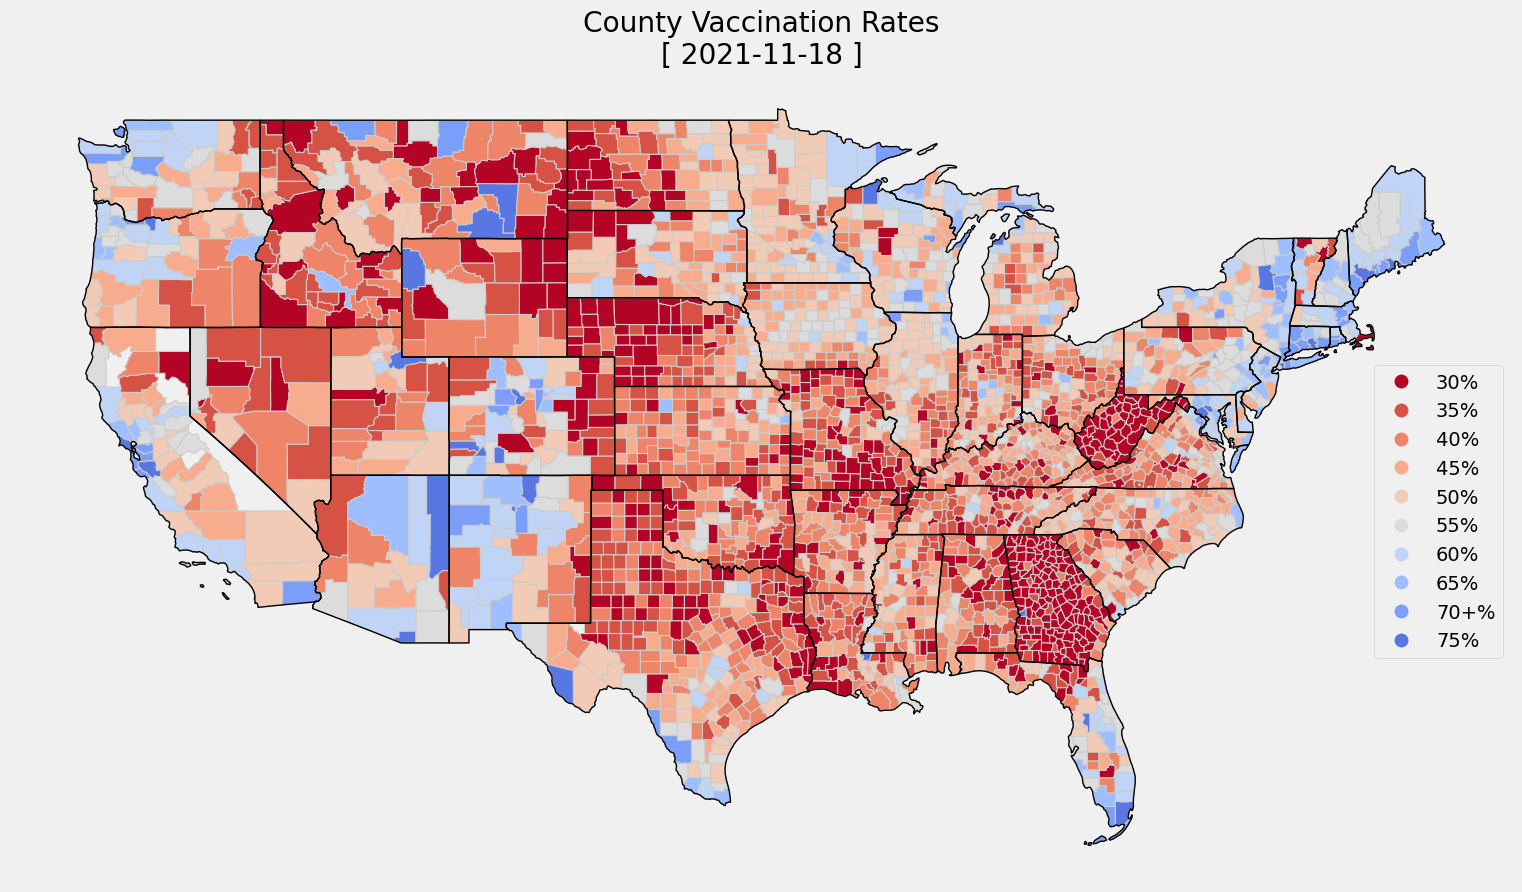

'C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/z_blog_natl_county_vax.jpg'

In [33]:
plot_df = geo_county_tier_df.copy()

plt.rcdefaults()
plt.style.use('fivethirtyeight')

#//*** Scale the plot to county_summary_df tiers.
#//*** Tiers outside of scope will be binned as max and min values
plot_df['tier'] = plot_df['tier'].str.replace("total_","").astype(int)


max_tier = county_summary_df['tier'].str.replace("total_","").astype(int).max()
min_tier = county_summary_df['tier'].str.replace("total_","").astype(int).min()


plot_df.loc[plot_df["tier"] < min_tier,'tier']=min_tier
plot_df.loc[plot_df["tier"] > max_tier,'tier']=max_tier

plot_df = plot_df.sort_values('tier').reset_index()

#print(plot_df['tier'].unique()[1])
#plot_df = plot_df.sort_values('tier')
plot_df['tier'] = plot_df['tier'].astype(str)
#plot_df['tier'] = plot_df['tier'].str.replace(str(min_tier),"\\< 35")

plot_df['tier'] = plot_df['tier'] + "%"
plot_df['tier'] = plot_df['tier'].str.replace("70%","70+%")
#plot_df['tier'] = plot_df['tier'].str.replace("total_5%","total_05%")


#//*** Assign column to graph
plot_column = 'tier'

#//*** Assign Categories for color palettes
plot_cats = plot_df[plot_column].unique()

#//*** Get a color Palette
item_count = len(plot_cats)
counter_list = []
counter = 0
for x in range(item_count):
    counter += 100 / item_count
    counter_list.append(counter)

vmin=0
vmax=item_count

norm = matplotlib.colors.Normalize(vmin=0, vmax=100)
#colors_palette = [matplotlib.cm.YlGn(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.YlOrBr(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.Spectral(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.copper(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.Accent(norm(value)) for value in counter_list]
colors_palette = [matplotlib.cm.coolwarm(norm(value)) for value in counter_list[::-1]]
#colors_palette = [matplotlib.cm.coolwarm(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.Blues(norm(value)) for value in counter_list]

#//*** Display Labels for Legend
plot_label_dict = {}



#//*** Generate Label Display Names
#for cat in plot_cats:
#    value = int(cat.replace("total_",""))
#    plot_label_dict[cat] = f"{value}"


colors = {}
counter = 0
for period in plot_cats:
    colors[period] = colors_palette[counter]
    counter+=1

labels=plot_label_dict.values()


labels=list(plot_label_dict.values())
labels=list(plot_cats)

vax_dist_df = state_daily_df[state_daily_df['Date'] == state_daily_df['Date'].max()].sort_values('Name')

ax = plot_df.plot(column='tier', cmap=ListedColormap(colors_palette),categorical=True,legend=True, linewidth=0.8,edgecolor='0.8')

#//*** Draw State Shapes over top, Set Color to transparant with Black edgecolor
ax = vax_dist_df.plot(categorical=True,legend=True, linewidth=1,edgecolor='black',color=(1,1,1,0),ax=ax)

ax.axis('off')
#plt.suptitle(f"State Vaccination Rates")
plt.title(f"County Vaccination Rates\n[ {summer_county_tier_df['Date'].max()} ]")

fig = plt.gcf()
fig.set_size_inches(20,10)


leg = ax.get_legend()


print(dir(leg.get_figure))
print(dir(leg))



leg.set_bbox_to_anchor((1,0.65,0,0))

#print(ax.legend())
#//*** Handles is taken from earlie
#plt.legend(reversed(handles),reversed(labels),loc='lower left', fontsize=12)
#plt.legend(plt.legend().legendHandles)


outfilename=f'z_blog_natl_county_vax.jpg'
              
#out_blog_images.append(outfilename)
fig.savefig(outfilename)

#out_exec_summary_images.append("z_exec_summary_binned_vax_map.jpg")
plt.show()
#plot_df['tier'] = plot_df['tier'].replace("total_","")



#//****************************************************************************************
#//*** Copy the HTML/Javascript & Animated GIFs o the Website Production Folder
#//****************************************************************************************
directory_path = os.getcwd()

directory_path = directory_path.replace("\\","/")



#//*** Remove two sublevels to get to github root
directory_path = "".join(f"{x}/" for x in directory_path.split("/")[:-2])

#//*** Add in Fixed Relative path
directory_path += "kstoneburner.github.io/DSC640/"
copy_path = "wk09_10/"
shutil.copyfile(outfilename, f'{directory_path}{copy_path}{outfilename.split("/")[-1]}')



In [34]:
#//*** Associate County FIPS with a TIER value

"""
base_county_tier = geo_county_tier_df.copy()
del base_county_tier['FIPS']
del base_county_tier['tier']

whole_geo_county_tier_df = pd.DataFrame()
for group  in whole_county_tier_df.groupby('Date'):
    ftd = {
        'tier' : [],
        'FIPS' : []
    }
    
    for row in group[1].iterrows():
        for FIPS in row[1]['FIPS']:
            ftd['tier'].append([row[1]['tier']][0])
            ftd['FIPS'].append(FIPS)
    
        tdf = pd.DataFrame()
        
        
        
        tdf['FIPS'] = ftd['FIPS']
        tdf['tier'] = ftd['tier']
        tdf['Date'] = group[0]
        #print(tdf)
        whole_geo_county_tier_df = pd.concat([whole_geo_county_tier_df, base_county_tier.merge(tdf,left_on="GEOID",right_on="FIPS")])
whole_geo_county_tier_df
"""
print()

['__call__', '__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__func__', '__ge__', '__get__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__self__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__']
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_agg_filter', '_alpha', '_animated', '_auto_legend_data', '_axes', '_bbox_to_anchor', '_callbacks', '_clipon', '_clippath', '_contains', '_custom_handler_map', '_default_contains', '_default_handler_map', '_draggable', '_find_best_position', '_findoffset', '_fontsize', '_get_anchored_bb

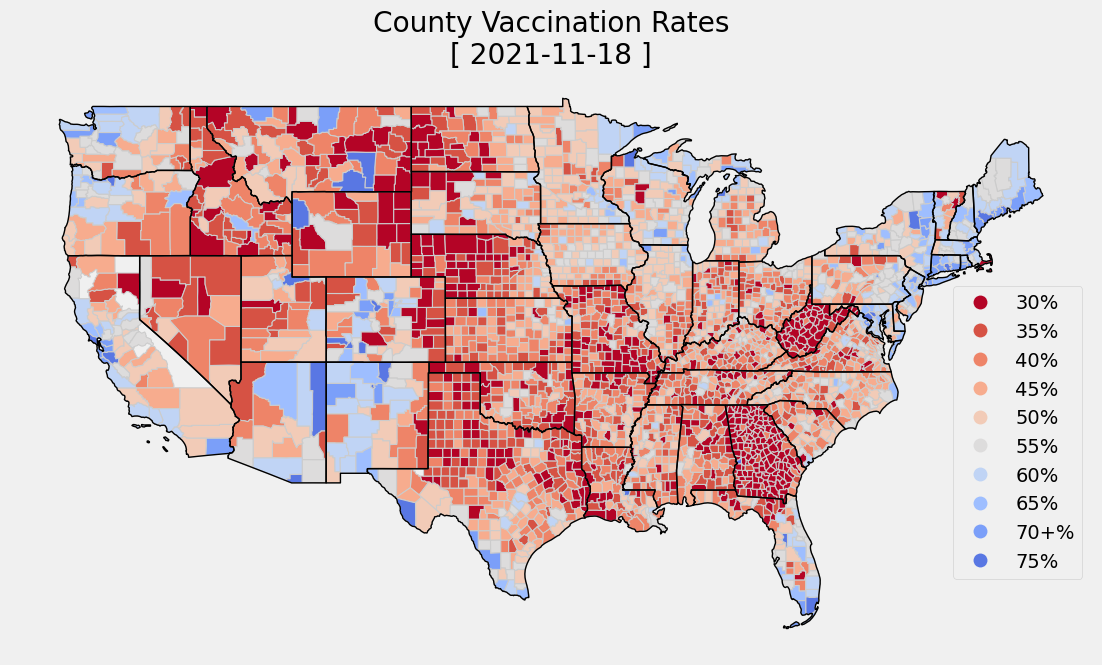

'C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/z_blog_natl_county_vax.jpg'

In [35]:
plot_df = geo_county_tier_df.copy()

plt.rcdefaults()
plt.style.use('fivethirtyeight')

#//*** Scale the plot to county_summary_df tiers.
#//*** Tiers outside of scope will be binned as max and min values
plot_df['tier'] = plot_df['tier'].str.replace("total_","").astype(int)


max_tier = county_summary_df['tier'].str.replace("total_","").astype(int).max()
min_tier = county_summary_df['tier'].str.replace("total_","").astype(int).min()

exec_fig_width =1280
exec_fig_height=720

plot_df.loc[plot_df["tier"] < min_tier,'tier']=min_tier
plot_df.loc[plot_df["tier"] > max_tier,'tier']=max_tier

plot_df = plot_df.sort_values('tier').reset_index()

#print(plot_df['tier'].unique()[1])
#plot_df = plot_df.sort_values('tier')
plot_df['tier'] = plot_df['tier'].astype(str)
#plot_df['tier'] = plot_df['tier'].str.replace(str(min_tier),"\\< 35")

plot_df['tier'] = plot_df['tier'] + "%"
plot_df['tier'] = plot_df['tier'].str.replace("70%","70+%")
#plot_df['tier'] = plot_df['tier'].str.replace("total_5%","total_05%")


#//*** Assign column to graph
plot_column = 'tier'

#//*** Assign Categories for color palettes
plot_cats = plot_df[plot_column].unique()

#//*** Get a color Palette
item_count = len(plot_cats)
counter_list = []
counter = 0
for x in range(item_count):
    counter += 100 / item_count
    counter_list.append(counter)

vmin=0
vmax=item_count

norm = matplotlib.colors.Normalize(vmin=0, vmax=100)
#colors_palette = [matplotlib.cm.YlGn(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.YlOrBr(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.Spectral(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.copper(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.Accent(norm(value)) for value in counter_list]
colors_palette = [matplotlib.cm.coolwarm(norm(value)) for value in counter_list[::-1]]
#colors_palette = [matplotlib.cm.coolwarm(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.Blues(norm(value)) for value in counter_list]

#//*** Display Labels for Legend
plot_label_dict = {}



#//*** Generate Label Display Names
#for cat in plot_cats:
#    value = int(cat.replace("total_",""))
#    plot_label_dict[cat] = f"{value}"


colors = {}
counter = 0
for period in plot_cats:
    colors[period] = colors_palette[counter]
    counter+=1

labels=plot_label_dict.values()


labels=list(plot_label_dict.values())
labels=list(plot_cats)

vax_dist_df = state_daily_df[state_daily_df['Date'] == state_daily_df['Date'].max()].sort_values('Name')

ax = plot_df.plot(column='tier', cmap=ListedColormap(colors_palette),categorical=True,legend=True, linewidth=0.8,edgecolor='0.8')

#//*** Draw State Shapes over top, Set Color to transparant with Black edgecolor
ax = vax_dist_df.plot(categorical=True,legend=True, linewidth=1,edgecolor='black',color=(1,1,1,0),ax=ax)

ax.axis('off')
#plt.suptitle(f"State Vaccination Rates")
plt.title(f"County Vaccination Rates\n[ {summer_county_tier_df['Date'].max()} ]")

fig = plt.gcf()

DPI = fig.get_dpi()
    #fig = plt.gcf()
    
fig.set_size_inches(exec_fig_width/float(DPI),exec_fig_height/float(DPI))

leg = ax.get_legend()


print(dir(leg.get_figure))
print(dir(leg))



leg.set_bbox_to_anchor((1,0.65,0,0))

#print(ax.legend())
#//*** Handles is taken from earlie
#plt.legend(reversed(handles),reversed(labels),loc='lower left', fontsize=12)
#plt.legend(plt.legend().legendHandles)


outfilename=f'z_blog_natl_county_vax.jpg'
              
#out_blog_images.append(outfilename)
fig.savefig(outfilename)

#out_exec_summary_images.append("z_exec_summary_binned_vax_map.jpg")
plt.show()
#plot_df['tier'] = plot_df['tier'].replace("total_","")



#//****************************************************************************************
#//*** Copy the HTML/Javascript & Animated GIFs o the Website Production Folder
#//****************************************************************************************
directory_path = os.getcwd()

directory_path = directory_path.replace("\\","/")



#//*** Remove two sublevels to get to github root
directory_path = "".join(f"{x}/" for x in directory_path.split("/")[:-2])

#//*** Add in Fixed Relative path
directory_path += "kstoneburner.github.io/DSC640/"
copy_path = "wk09_10/"
shutil.copyfile(outfilename, f'{directory_path}{copy_path}{outfilename.split("/")[-1]}')



In [36]:
#datetime.strptime(col, "%m/%d/%y").date()
start_summer_date =  datetime(2021, 7, 1).date()
type(whole_county_tier_df['Date'].iloc[0])
start_days = (start_summer_date - county_summary_df['date_start'].min()).days
summer_days = (county_summary_df['date_end'].max() - start_summer_date).days


print(start_days,summer_days)


county_analysis_dict = {
    'start_daily_100k_confirm' : start_summary_df['confirm_period_100k'].astype(int),
    'start_daily_100k_confirm_min' : start_summary_df['confirm_period_100k'].astype(int).min(),
    'start_daily_100k_confirm_max' : start_summary_df['confirm_period_100k'].astype(int).max(),
    'start_daily_mean_confirm' : start_summary_df['confirm_period'] / start_days,
    'summer_daily_mean_confirm': summer_summary_df['confirm_period'] / summer_days,
    'start_daily_mean_death' : start_summary_df['confirm_deaths'] / start_days,
    'summer_daily_mean_death': summer_summary_df['confirm_deaths'] / summer_days,
    'Population' : start_summary_df['Population'].apply(lambda x: f'{x:,}'),
    
    'pop_pct' : round(start_summary_df['pop_pct']*100,1).astype(str)+"%",
    
    'start_day_count' : start_days,
    'summer_day_count' : summer_days,
    'total_day_count' : start_days + summer_days,
    'us_total_vax' : vax_df['Series_Complete_Pop_Pct'].max(),

}

county_analysis_dict['case_change'] =  round(pd.Series(np.array(county_analysis_dict['summer_daily_mean_confirm']) / np.array(county_analysis_dict['start_daily_mean_confirm']))*100,1)
county_analysis_dict['death_change'] = round(pd.Series(np.array(county_analysis_dict['summer_daily_mean_death']) / np.array(county_analysis_dict['start_daily_mean_death']))*100,1)

county_analysis_dict['case_baseline'] = pd.Series(round( (1- county_analysis_dict['case_change'] /county_analysis_dict['case_change'][0])*100,1))
county_analysis_dict['death_baseline'] = pd.Series(round( (1- county_analysis_dict['death_change']/county_analysis_dict['death_change'][0])*100,1))

county_analysis_dict['case_change'] = county_analysis_dict['case_change'].astype(str)+'%'
county_analysis_dict['death_change'] = county_analysis_dict['death_change'].astype(str)+'%'
"""
print(start_summary_df['confirm_period'] / start_days)
print(summer_summary_df['confirm_period'] / summer_days)

print( pd.Series(np.array(county_analysis_dict['summer_daily_mean_confirm']) / np.array(county_analysis_dict['start_daily_mean_confirm'])))

print(start_summary_df['confirm_deaths'] / start_days)
print(summer_summary_df['confirm_deaths'] / summer_days)
print( pd.Series(np.array(county_analysis_dict['summer_daily_mean_death']) / np.array(county_analysis_dict['start_daily_mean_death'])))
"""
manage_df['county_analysis_dict'] = "Summary Stats for Display for the blog post"
county_analysis_dict

511 140


{'start_daily_100k_confirm': 0    10230
 1    10772
 2    10693
 3    10666
 4    10668
 5     9692
 6    10147
 7     9939
 8     8268
 9    10595
 Name: confirm_period_100k, dtype: int32,
 'start_daily_100k_confirm_min': 8268,
 'start_daily_100k_confirm_max': 10772,
 'start_daily_mean_confirm': 0     3399.078278
 1     3122.808219
 2     4704.908023
 3     6770.774951
 4    11829.434442
 5    10887.512720
 6    13907.369863
 7     4636.197652
 8     3104.982387
 9     2522.467710
 Name: confirm_period, dtype: float64,
 'summer_daily_mean_confirm': 10     6361.492857
 11     6254.671429
 12     9223.871429
 13    12063.121429
 14    18083.092857
 15    17311.371429
 16    16131.692857
 17     4973.078571
 18     3126.114286
 19     2547.607143
 Name: confirm_period, dtype: float64,
 'start_daily_mean_death': 0     65.295499
 1     61.604697
 2     87.544031
 3    120.136986
 4    195.776908
 5    170.346380
 6    263.387476
 7     87.191781
 8     56.841487
 9     54.356164
 Name: con

In [37]:
county_analysis_dict

{'start_daily_100k_confirm': 0    10230
 1    10772
 2    10693
 3    10666
 4    10668
 5     9692
 6    10147
 7     9939
 8     8268
 9    10595
 Name: confirm_period_100k, dtype: int32,
 'start_daily_100k_confirm_min': 8268,
 'start_daily_100k_confirm_max': 10772,
 'start_daily_mean_confirm': 0     3399.078278
 1     3122.808219
 2     4704.908023
 3     6770.774951
 4    11829.434442
 5    10887.512720
 6    13907.369863
 7     4636.197652
 8     3104.982387
 9     2522.467710
 Name: confirm_period, dtype: float64,
 'summer_daily_mean_confirm': 10     6361.492857
 11     6254.671429
 12     9223.871429
 13    12063.121429
 14    18083.092857
 15    17311.371429
 16    16131.692857
 17     4973.078571
 18     3126.114286
 19     2547.607143
 Name: confirm_period, dtype: float64,
 'start_daily_mean_death': 0     65.295499
 1     61.604697
 2     87.544031
 3    120.136986
 4    195.776908
 5    170.346380
 6    263.387476
 7     87.191781
 8     56.841487
 9     54.356164
 Name: con

In [38]:
state_hosp_tiers_df

population       Date tot_death tot_confirm New_Cases New_Deaths  case_7_day_avg case_avg_100k  death_7_day_avg death_avg_100k loc                 FIPS      tier total_beds beds_used  \
6019    3579212 2020-02-07         0           0         0          0        0.000000           0.0         0.000000            0.0  ID             [16, 54]  total_40        0.0       0.0   
6020    3579212 2020-02-08         0           0         0          0        0.000000           0.0         0.000000            0.0  ID             [16, 54]  total_40        0.0       0.0   
6021    3579212 2020-02-09         0           0         0          0        0.000000           0.0         0.000000            0.0  ID             [16, 54]  total_40        0.0       0.0   
6022    3579212 2020-02-10         0           0         0          0        0.000000           0.0         0.000000            0.0  ID             [16, 54]  total_40        0.0       0.0   
6023    3579212 2020-02-11         0           0         0          0        0.000000           0.0         0.000000            0.0  ID             [16, 54]  total_40        0.0       0.0   
...         ...        ...       ...         ...       ...        ...             ...           ...              ...            ...  ..                  ...       ...        ...       ...   
3997   13485352 2021-11-14     32443     1616387      1569         10     6466.857143     47.954678        36.000000       0.266956  CT  [9, 23, 25, 44, 50]  total_70    33507.0   27212.0   
3998   13485352 2021-11-15     32490     1625589      9513         47     6875.285714     50.983361        41.857143        0.31039  CT  [9, 23, 25, 44, 50]  total_70    31007.0   25122.0   
3999   13485352 2021-11-16     32529     1630005     13618         86     7458.142857     55.305511        46.000000       0.341111  CT  [9, 23, 25, 44, 50]  total_70    31194.0   25951.0   
4000   13485352 2021-11-17     32574     1635590     10001         84     7865.142857     58.323601        46.428571       0.344289  CT  [9, 23, 25, 44, 50]  total_70    33461.0   28368.0   
4001   13485352 2021-11-18     32601     1641932     11927         72     8744.857143     64.847081        51.571429       0.382426  CT  [9, 23, 25, 44, 50]  total_70    33623.0   28373.0   

     covid_beds_used icu_total            icu_used covid_icu covid_beds_adult covid_beds_kids case_scaled_100k death_scaled_100k  
6019             0.0       0.0                 0.0       0.0              0.0             0.0              0.0               0.0  
6020             0.0       0.0                 0.0       0.0              0.0             0.0              0.0               0.0  
6021             0.0       0.0                 0.0       0.0              0.0             0.0              0.0               0.0  
6022             0.0       0.0                 0.0       0.0              0.0             0.0              0.0               0.0  
6023             0.0       0.0                 0.0       0.0              0.0             0.0              0.0               0.0  
...              ...       ...                 ...       ...              ...             ...              ...               ...  
3997          1229.0    2902.0    0.60748020428308     278.0           1217.0            12.0        47.954678          0.266956  
3998          1254.0    2861.0   0.716109022720876     285.0           1236.0            18.0        50.983361           0.31039  
3999          1340.0    2901.0   0.707559246297404     295.0           1321.0            19.0        55.305511          0.341111  
4000          1346.0    2908.0   0.729260958375742     299.0           1324.0            22.0        58.323601          0.344289  
4001          1368.0    2902.0  0.6680070056487549     294.0           1352.0            16.0        64.847081          0.382426  

[4557 rows x 23 columns]

In [39]:
vax_df = pd.read_csv(vaccine_data_filename)

#//*** Filter Columns to get just the Completed Values
cols = ['Date','Location']
filter_val = ['FedLTC','Unk','Janssen','Pfizer','Moderna','Fed_LTC']
for col in vax_df.columns:
    if 'Complete' in col or 'Dose1' in col:
        skipVal = False
        for val in filter_val:
            if val in col:
                skipVal = True
                continue
        if skipVal:
            continue
        cols.append(col)

#//*** Keep Relevant Data
vax_df = vax_df[cols]

vax_df = vax_df[vax_df["Location"] == 'US' ]
#vax_df['Date'] = 
vax_df['Date'] = pd.to_datetime(vax_df['Date'])

vax_df = vax_df.sort_values('Date')

out_stats

out_stats['total_vaccinated_count'] = format (vax_df.iloc[-1]["Series_Complete_Yes"],',d')
out_stats['total_vaccinated_percent'] = f"{vax_df.iloc[-1]['Series_Complete_Pop_Pct']}%"
out_stats['first_dose_count'] = format (vax_df.iloc[-1]["Administered_Dose1_Recip"],',d')
out_stats['first_dose_percent'] = f"{vax_df.iloc[-1]['Administered_Dose1_Pop_Pct']}%"

manage_df['vax_df'] = "United States Total Vaccine Levels [2020-12-13 - Present]"
vax_df

Date Location  Administered_Dose1_Recip  Administered_Dose1_Pop_Pct  Administered_Dose1_Recip_12Plus  Administered_Dose1_Recip_12PlusPop_Pct  Administered_Dose1_Recip_18Plus  \
22038 2020-12-13       US                         0                         0.0                                0                                     0.0                                0   
21979 2020-12-14       US                         0                         0.0                                0                                     0.0                                0   
21945 2020-12-15       US                         0                         0.0                                0                                     0.0                                0   
21893 2020-12-16       US                         0                         0.0                                0                                     0.0                                0   
21800 2020-12-17       US                         0                         0.0                                0                                     0.0                                0   
...          ...      ...                       ...                         ...                              ...                                     ...                              ...   
300   2021-11-14       US                 226607653                        68.3                        225254937                                    79.4                        210053318   
241   2021-11-15       US                 227133617                        68.4                        225523235                                    79.5                        210296568   
141   2021-11-16       US                 227691941                        68.6                        225868537                                    79.7                        210620919   
72    2021-11-17       US                 228175638                        68.7                        226169232                                    79.8                        210900105   
7     2021-11-18       US                 228570531                        68.8                        226382383                                    79.8                        211095982   

       Administered_Dose1_Recip_18PlusPop_Pct  Administered_Dose1_Recip_65Plus  Administered_Dose1_Recip_65PlusPop_Pct  Series_Complete_Yes  Series_Complete_Pop_Pct  Series_Complete_12Plus  \
22038                                     0.0                                0                                     0.0                    0                      0.0                       0   
21979                                     0.0                                0                                     0.0                    0                      0.0                       0   
21945                                     0.0                                0                                     0.0                    0                      0.0                       0   
21893                                     0.0                                0                                     0.0                    0                      0.0                       0   
21800                                     0.0                                0                                     0.0                    0                      0.0                       0   
...                                       ...                              ...                                     ...                  ...                      ...                     ...   
300                                      81.3                         54281194                                    99.1            195120470                     58.8               194982994   
241                                      81.4                         54339137                                    99.2            195275904                     58.8               195138239   
141            

- [Graph Interactive: U.S. Vaccinations](#graph_us_vaccinations_by_state)


<a id="graph_us_vaccinations_by_state"></a> 
# Graph: U.S. Vaccinations #

- [Graph: Total U.S. Vaccinations Full and Partial (Line Graph Interactive)](#graph_total_us_vaccination_full_and_partial)


<a id="graph_total_us_vaccination_full_and_partial"></a> 
# Graph: Total U.S. Vaccinations Full and Partial (Line Graph Interactive) #

- [Graph: List States by Highest Current Death rates (Bar Plot)](#graph_list_states_highest_death_rates)


<a id="graph_list_states_highest_death_rates"></a> 
# Graph: List States by Highest Current Death rates (Bar Plot) #

- [Graph: US Total New Deaths Per Day (Line Plot)](#graph_US_total_new_deaths_per_day)


<a id="graph_US_total_new_deaths_per_day"></a> 
# Graph: US Total New Deaths Per Day (Line Plot) #

- [Graph: List States by Highest New Cases (Bar Plot)](#graph_list_states_highest_death_rates)


<a id="graph_list_states_highest_new_cases"></a> 
# Graph: List States by Highest Current Death rates (Bar Plot) #

- [Graph: Table of States with Highest Total COVID Counts (Table Plot)](#graph_list_states_highest_total_cases)


<a id="graph_list_states_highest_total_cases"></a> 
# Graph: Table of States with Highest Total COVID Counts (Table Plot) #

- [Graph: U.S. Total COVID Cases Trend (Line Plot)](#graph_us_total_covid_cases_trend)


<a id="graph_us_total_covid_cases_trend"></a> 
# Graph: U.S. Total COVID Cases Trend (Line Plot) #

In [40]:
#plt.get_cmap("Blues")
#//*** Assign Categories for color palettes
plot_cats = geo_county_tier_df['tier'].unique()

#//*** Get a color Palette
item_count = len(plot_cats)
counter_list = []
counter = 0
for x in range(item_count):
    counter += 100 / item_count
    counter_list.append(counter)

vmin=0
vmax=item_count

norm = matplotlib.colors.Normalize(vmin=0, vmax=100)
#colors_palette = [matplotlib.cm.YlGn(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.YlOrBr(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.Spectral(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.copper(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.Accent(norm(value)) for value in counter_list]
colors_palette = [matplotlib.cm.coolwarm(norm(value)) for value in counter_list[::-1]]
#colors_palette = [matplotlib.cm.coolwarm(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.OrRd(norm(value)) for value in counter_list]

#//*** Display Labels for Legend
plot_label_dict = {}



#//*** Generate Label Display Names
#for cat in plot_cats:
#    value = int(cat.replace("total_",""))
#    plot_label_dict[cat] = f"{value}"


alt_colors = {}
counter = 0
for period in plot_cats:
    alt_colors[period] = colors_palette[counter]
    counter+=1
    
alt_colors


{'total_45': (0.705673158, 0.01555616, 0.150232812, 1.0),
 'total_35': (0.8393649370784314,
  0.32185622094117644,
  0.26492398098039216,
  1.0),
 'total_55': (0.9318312966, 0.5190855232, 0.4064796086, 1.0),
 'total_30': (0.9684997476666667, 0.673977379772549, 0.5566492560470588, 1.0),
 'total_50': (0.9473454036, 0.7946955048, 0.7169905058, 1.0),
 'total_40': (0.8674276350862745, 0.864376599772549, 0.8626024620196079, 1.0),
 'total_75': (0.753610618, 0.830232851, 0.960871157, 1.0),
 'total_60': (0.6193179451882354, 0.7441207347647059, 0.9989309188196078, 1.0),
 'total_65': (0.48385432959999997, 0.6220498496, 0.9748082026, 1.0),
 'total_70': (0.34832334141176474,
  0.4657111465098039,
  0.8883461629411764,
  1.0)}

In [41]:
#tier.replace("total_","")+"%"
colors
if 'geometry' not in geo_county_vax_tier_df.columns:
    print("Merge Geo Data with vax")


    geo_county_vax_tier_df = geo_county_tier_df[["STATEFP","GEOID","geometry"]].merge(geo_county_vax_tier_df,left_on='GEOID',right_on='FIPS')

Merge Geo Data with vax


In [42]:
#//*********************************
#//*********************************
#//*** RENDER HISTORICAL GIF
#//*********************************
#//*********************************
rebuild_all_images = False
plt.rcdefaults()
plt.style.use('fivethirtyeight')
if 'copy_files' not in out_controls.keys():
    out_controls['copy_files'] = {}

out_controls['copy_files']['infographic_cases'] = []
start_plot_date =  datetime(2020, 2, 6).date()
#//*** Only Render Animated GIF if not using Cached values...ie during an update.
if True:

    #//********************************************
    #//*** Build Output Filepath
    #//********************************************
    filepath = os.getcwd()
    filepath = filepath.replace("\\","/")
    filepath = f"{filepath}/project/infographic_confirm/"

    files_jpg = []
    gif_files = []
    #//********************************************


    plot_df = attrib_confirm_df.copy()

    fontsize=15

    dates = all_dates[100:]
    #dates = all_dates[-30:]
    dates = all_dates

    first=True

    file_counter = 0
    print("Working...")
    for date in dates:
        
        if datetime.strptime(date, "%m/%d/%y").date() < start_plot_date:
            continue
        #print(date)
        #if date != "1/13/21":
        #    continue
        
        file_counter += 1
        
        #if file_counter % 50 > 0:
        #    continue

        save_filename = f"{filepath}confirm_hist_{file_counter}.jpg"
        death_filename = f"{filepath}death_hist_{file_counter}.jpg"
        vax_filename = f"{filepath}vax_hist_{file_counter}.jpg"
        
        if rebuild_all_images == False:
            #//*** Check If File already Exists, If yes....Skip it.
            if os.path.exists(save_filename):
                #print(f"Skipping: {save_filename}")
                out_controls['copy_files']['infographic_cases'].append(save_filename)
                out_controls['copy_files']['infographic_cases'].append(death_filename)
                out_controls['copy_files']['infographic_cases'].append(vax_filename)
                
                continue

        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************


        
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************

        fig, ax = plt.subplots()

        fig.set_size_inches(8,4)
        #fig.set_size_inches(20,10)
        fig = plt.gcf()
        ax.axis('off')

        color_map = "viridis"
        # Create colorbar as a legend
        sm = plt.cm.ScalarMappable(cmap=plt.get_cmap(color_map), norm=plt.Normalize(vmin=0, vmax=100))
        sm = plt.cm.ScalarMappable(cmap=plt.viridis(), norm=plt.Normalize(vmin=0, vmax=100))
        #sm = plt.cm.ScalarMappable(cmap=plt.plasma(), norm=plt.Normalize(vmin=0, vmax=100))
        #sm = plt.cm.ScalarMappable(cmap=plt.inferno(), norm=plt.Normalize(vmin=0, vmax=100))
        #sm2 = plt.cm.ScalarMappable(cmap=plt.get_cmap("viridis"), norm=plt.Normalize(vmin=0, vmax=100))
        #plt.get_cmap
        
        
        #colors_palette = [matplotlib.cm.coolwarm(norm(value)) for value in counter_list[::-1]]

        # empty array for the data range
        sm._A = []
        


        cbar = fig.colorbar(sm,shrink=.7)

        #plt.title("Cumulative COVID Prevalence",fontsize=display_size)
        #fig.text(.78, .2, 'Cumulative Cases (per 100k)', va='center' ,fontsize=display_size/2)
        attrib_confirm_df.plot(column=f'{date}_scaled_100k', ax=ax,linewidth=0.3,cmap=plt.get_cmap(color_map),edgecolor=(1,1,1,.2))
        
        
        #//*** Draw State Shapes over top, Set Color to transparant with Black edgecolor
        ax = vax_dist_df.plot(categorical=True,legend=True, linewidth=.8,edgecolor='white',color=(1,1,1,0),ax=ax)
        
        plt.title(f"COVID-19 Prevalence\nNew Cases per 100,000 Population (7-Day Average)",fontsize=fontsize)
        plt.text(-120,25,date,fontsize=fontsize)
        #plt.viridis()

        out_controls['copy_files']['infographic_cases'].append(save_filename)
        print(save_filename)
        plt.savefig(save_filename,pil_kwargs={'quality': 95})

        plt.close()
        
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        
        plot_df = attrib_death_df.copy()
        fig, ax = plt.subplots()

        fig.set_size_inches(8,3.8)
        #fig.set_size_inches(20,10)
        fig = plt.gcf()
        ax.axis('off')

        color_map = "inferno"
        # Create colorbar as a legend
        sm = plt.cm.ScalarMappable(cmap=plt.get_cmap(color_map), norm=plt.Normalize(vmin=0, vmax=5))

        # empty array for the data range
        sm._A = []

        cbar = fig.colorbar(sm,shrink=.7)

        #plt.title("Cumulative COVID Prevalence",fontsize=display_size)
        #fig.text(.78, .2, 'Cumulative Cases (per 100k)', va='center' ,fontsize=display_size/2)
        attrib_death_df.plot(column=f'{date}_scaled_100k', ax=ax,linewidth=0.3,cmap=plt.get_cmap(color_map),edgecolor=(1,1,1,.2))
        
        
        #//*** Draw State Shapes over top, Set Color to transparant with Black edgecolor
        ax = vax_dist_df.plot(categorical=True,legend=True, linewidth=.8,edgecolor='white',color=(1,1,1,0),ax=ax)
        
        plt.title(f"COVID-19 Prevalence\nDeaths per 100,000 Population (7-Day Average)",fontsize=fontsize)
        plt.text(-120,25,date,fontsize=fontsize)
        #plt.viridis()

        out_controls['copy_files']['infographic_cases'].append(death_filename)
        print(death_filename)
        plt.savefig(death_filename,pil_kwargs={'quality': 90})

        plt.close()
        

        
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        
                
        vax_plot_df = geo_county_vax_tier_df[geo_county_vax_tier_df['Date'] == datetime.strptime(date, "%m/%d/%y").date()]
        
        if len(vax_plot_df) == 0:
            continue
        
        fig, ax = plt.subplots()

        fig.set_size_inches(8,3.8)
        #fig.set_size_inches(20,10)
        fig = plt.gcf()
        ax.axis('off')

        color_map = "coolwarm_r"
        # Create colorbar as a legend
        sm = plt.cm.ScalarMappable(cmap=plt.get_cmap(color_map), norm=plt.Normalize(vmin=0, vmax=70))

        # empty array for the data range
        sm._A = []

        cbar = fig.colorbar(sm,shrink=.7)

        #plt.title("Cumulative COVID Prevalence",fontsize=display_size)
        #fig.text(.78, .2, 'Cumulative Cases (per 100k)', va='center' ,fontsize=display_size/2)
        vax_plot_df.plot(column='total_vaccinated_percent', ax=ax,linewidth=0.3,cmap=plt.get_cmap(color_map),edgecolor=(1,1,1,.2))
        
        
        #//*** Draw State Shapes over top, Set Color to transparant with Black edgecolor
        ax = vax_dist_df.plot(categorical=True,legend=True, linewidth=.8,edgecolor='white',color=(1,1,1,0),ax=ax)
        
        plt.title(f"Completed Vaccination",fontsize=fontsize)
        plt.text(-120,25,date,fontsize=fontsize)
        #plt.viridis()

        out_controls['copy_files']['infographic_cases'].append(vax_filename)
        print(vax_filename)
        plt.savefig(vax_filename,pil_kwargs={'quality': 95})

        plt.close()



    print("Done...")
plt.rcdefaults()

print("Done!")

Working...
Done...
Done!


In [43]:

#//****************************************************************************************
#//*** Copy the HTML/Javascript & Animated GIFs o the Website Production Folder
#//****************************************************************************************
directory_path = os.getcwd()

directory_path = directory_path.replace("\\","/")



#//*** Remove two sublevels to get to github root
directory_path = "".join(f"{x}/" for x in directory_path.split("/")[:-2])

#//*** Add in Fixed Relative path
directory_path += "kstoneburner.github.io/DSC640/"

"""
for filename,html in out_plot.items():
    
    
    #//*** write raw HTML to output folder
    with open(f"{directory_path}{filename}.raw" , "w") as f:
        print(f"Writing File:{directory_path}{filename}.raw")
        f.write(html)

for filename in out_images:
    shutil.copyfile(filename, f"{directory_path}{filename}")
"""

for key,action in out_controls.items():
    
    
    if key == 'copy_files':
        
        for action_key,action_values in action.items():
            if action_key == "infographic_cases":
                copy_path = "wk09_10/infographic_gifs/"
                
                for filename in action_values:
                    try:
                        print(f'{directory_path}{copy_path}{filename.split("/")[-1]}')
                        shutil.copyfile(filename, f'{directory_path}{copy_path}{filename.split("/")[-1]}')
                    except:
                        continue
                

C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_1.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_1.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_1.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_2.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_2.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_2.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_3.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_3.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_3.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_4.jp

C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_49.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_49.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_50.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_50.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_50.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_51.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_51.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_51.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_52.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hi

C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_97.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_98.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_98.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_98.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_99.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_99.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_99.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_100.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_100.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hi

C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_146.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_146.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_146.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_147.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_147.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_147.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_148.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_148.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_148.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs

C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_192.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_193.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_193.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_193.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_194.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_194.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_194.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_195.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_195.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs

C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_239.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_240.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_240.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_240.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_241.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_241.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_241.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_242.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_242.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs

C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_289.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_289.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_289.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_290.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_290.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_290.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_291.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_291.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_291.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs

C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_329.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_329.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_330.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_330.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_330.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_331.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_331.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_331.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_332.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs

C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_365.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_366.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_366.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_366.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_367.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_367.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_367.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_368.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_368.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs

C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_401.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_401.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_402.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_402.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_402.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_403.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_403.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_403.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_404.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs

C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_437.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_437.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_437.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_438.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_438.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_438.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_439.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_439.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_439.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs

C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_472.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_472.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_473.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_473.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_473.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_474.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_474.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_474.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_475.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs

C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_502.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_502.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_503.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_503.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_503.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_504.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_504.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_504.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_505.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs

C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_537.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_537.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_538.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_538.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_538.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_539.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_539.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_539.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_540.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs

C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_568.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_569.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_569.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_569.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_570.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_570.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_570.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_571.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_571.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs

C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_603.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_603.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_603.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_604.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_604.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_604.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_605.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_605.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_605.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs

C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_637.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_638.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_638.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_638.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_639.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_639.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_639.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_640.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_640.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs

In [44]:
all_dates

['1/29/20',
 '1/30/20',
 '1/31/20',
 '2/1/20',
 '2/2/20',
 '2/3/20',
 '2/4/20',
 '2/5/20',
 '2/6/20',
 '2/7/20',
 '2/8/20',
 '2/9/20',
 '2/10/20',
 '2/11/20',
 '2/12/20',
 '2/13/20',
 '2/14/20',
 '2/15/20',
 '2/16/20',
 '2/17/20',
 '2/18/20',
 '2/19/20',
 '2/20/20',
 '2/21/20',
 '2/22/20',
 '2/23/20',
 '2/24/20',
 '2/25/20',
 '2/26/20',
 '2/27/20',
 '2/28/20',
 '2/29/20',
 '3/1/20',
 '3/2/20',
 '3/3/20',
 '3/4/20',
 '3/5/20',
 '3/6/20',
 '3/7/20',
 '3/8/20',
 '3/9/20',
 '3/10/20',
 '3/11/20',
 '3/12/20',
 '3/13/20',
 '3/14/20',
 '3/15/20',
 '3/16/20',
 '3/17/20',
 '3/18/20',
 '3/19/20',
 '3/20/20',
 '3/21/20',
 '3/22/20',
 '3/23/20',
 '3/24/20',
 '3/25/20',
 '3/26/20',
 '3/27/20',
 '3/28/20',
 '3/29/20',
 '3/30/20',
 '3/31/20',
 '4/1/20',
 '4/2/20',
 '4/3/20',
 '4/4/20',
 '4/5/20',
 '4/6/20',
 '4/7/20',
 '4/8/20',
 '4/9/20',
 '4/10/20',
 '4/11/20',
 '4/12/20',
 '4/13/20',
 '4/14/20',
 '4/15/20',
 '4/16/20',
 '4/17/20',
 '4/18/20',
 '4/19/20',
 '4/20/20',
 '4/21/20',
 '4/22/20',
 '4/23/

Working...


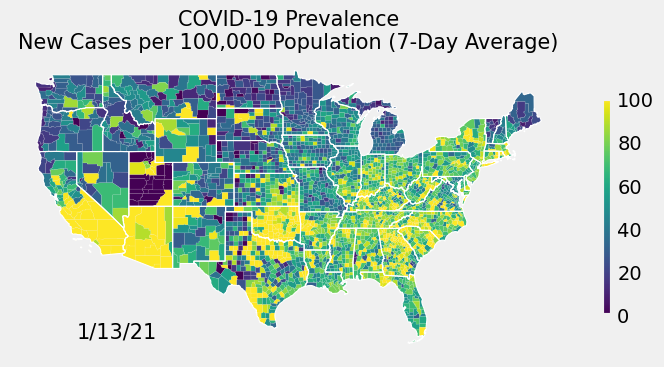

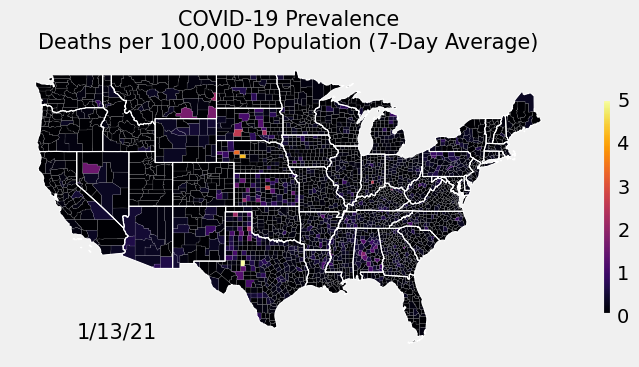

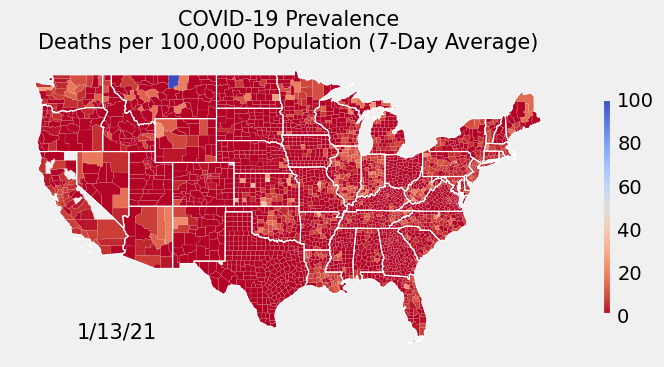

Done...
Done!


In [45]:
#2021/01/13


("1/13/21" in all_dates)



#//*********************************
#//*********************************
#//*** RENDER HISTORICAL GIF
#//*********************************
#//*********************************
rebuild_all_images = False
plt.rcdefaults()
plt.style.use('fivethirtyeight')
if 'copy_files' not in out_controls.keys():
    out_controls['copy_files'] = {}

out_controls['copy_files']['infographic_cases'] = []
start_plot_date =  datetime(2020, 2, 6).date()
#//*** Only Render Animated GIF if not using Cached values...ie during an update.
if True:

    #//********************************************
    #//*** Build Output Filepath
    #//********************************************
    filepath = os.getcwd()
    filepath = filepath.replace("\\","/")
    filepath = f"{filepath}/project/infographic_confirm/"

    files_jpg = []
    gif_files = []
    #//********************************************


    plot_df = attrib_confirm_df.copy()

    fontsize=15

    dates = all_dates[100:]
    #dates = all_dates[-30:]
    dates = all_dates

    first=True

    file_counter = 0
    print("Working...")
    for date in ["1/13/21"]:
        

        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************


        
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************

        fig, ax = plt.subplots()

        fig.set_size_inches(8,3.8)
        #fig.set_size_inches(20,10)
        fig = plt.gcf()
        ax.axis('off')

        color_map = "viridis"
        # Create colorbar as a legend
        sm = plt.cm.ScalarMappable(cmap=plt.get_cmap(color_map), norm=plt.Normalize(vmin=0, vmax=100))
        sm = plt.cm.ScalarMappable(cmap=plt.viridis(), norm=plt.Normalize(vmin=0, vmax=100))
        #sm = plt.cm.ScalarMappable(cmap=plt.plasma(), norm=plt.Normalize(vmin=0, vmax=100))
        #sm = plt.cm.ScalarMappable(cmap=plt.inferno(), norm=plt.Normalize(vmin=0, vmax=100))
        #sm2 = plt.cm.ScalarMappable(cmap=plt.get_cmap("viridis"), norm=plt.Normalize(vmin=0, vmax=100))
        #plt.get_cmap
        
        
        #colors_palette = [matplotlib.cm.coolwarm(norm(value)) for value in counter_list[::-1]]

        # empty array for the data range
        sm._A = []
        


        cbar = fig.colorbar(sm,shrink=.7)

        #plt.title("Cumulative COVID Prevalence",fontsize=display_size)
        #fig.text(.78, .2, 'Cumulative Cases (per 100k)', va='center' ,fontsize=display_size/2)
        plot_df.plot(column=f'{date}_scaled_100k', ax=ax,linewidth=0.3,cmap=plt.get_cmap(color_map),edgecolor=(1,1,1,.2))
        
        
        #//*** Draw State Shapes over top, Set Color to transparant with Black edgecolor
        ax = vax_dist_df.plot(categorical=True,legend=True, linewidth=.8,edgecolor='white',color=(1,1,1,0),ax=ax)
        
        plt.title(f"COVID-19 Prevalence\nNew Cases per 100,000 Population (7-Day Average)",fontsize=fontsize)
        plt.text(-120,25,date,fontsize=fontsize)
        #plt.viridis()

        plt.savefig("test.jpg",pil_kwargs={'quality': 95})
        plt.show()
        
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        
        plot_df = attrib_death_df.copy()
        fig, ax = plt.subplots()

        fig.set_size_inches(8,3.8)
        #fig.set_size_inches(20,10)
        fig = plt.gcf()
        ax.axis('off')

        color_map = "inferno"
        # Create colorbar as a legend
        sm = plt.cm.ScalarMappable(cmap=plt.get_cmap(color_map), norm=plt.Normalize(vmin=0, vmax=5))

        # empty array for the data range
        sm._A = []

        cbar = fig.colorbar(sm,shrink=.7)

        #plt.title("Cumulative COVID Prevalence",fontsize=display_size)
        #fig.text(.78, .2, 'Cumulative Cases (per 100k)', va='center' ,fontsize=display_size/2)
        plot_df.plot(column=f'{date}_scaled_100k', ax=ax,linewidth=0.3,cmap=plt.get_cmap(color_map),edgecolor=(1,1,1,.2))
        
        
        #//*** Draw State Shapes over top, Set Color to transparant with Black edgecolor
        ax = vax_dist_df.plot(categorical=True,legend=True, linewidth=.8,edgecolor='white',color=(1,1,1,0),ax=ax)
        
        plt.title(f"COVID-19 Prevalence\nDeaths per 100,000 Population (7-Day Average)",fontsize=fontsize)
        plt.text(-120,25,date,fontsize=fontsize)
        #plt.viridis()

        plt.show()
     #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        
                
        vax_plot_df = geo_county_vax_tier_df[geo_county_vax_tier_df['Date'] == datetime.strptime(date, "%m/%d/%y").date()]
        
        if len(vax_plot_df) == 0:
            continue
        
        fig, ax = plt.subplots()

        fig.set_size_inches(8,3.8)
        #fig.set_size_inches(20,10)
        fig = plt.gcf()
        ax.axis('off')

        color_map = "coolwarm_r"
        # Create colorbar as a legend
        sm = plt.cm.ScalarMappable(cmap=plt.get_cmap(color_map), norm=plt.Normalize(vmin=0, vmax=100))

        # empty array for the data range
        sm._A = []

        cbar = fig.colorbar(sm,shrink=.7)

        #plt.title("Cumulative COVID Prevalence",fontsize=display_size)
        #fig.text(.78, .2, 'Cumulative Cases (per 100k)', va='center' ,fontsize=display_size/2)
        vax_plot_df.plot(column='total_vaccinated_percent', ax=ax,linewidth=0.3,cmap=plt.get_cmap(color_map),edgecolor=(1,1,1,.2))
        
        
        #//*** Draw State Shapes over top, Set Color to transparant with Black edgecolor
        ax = vax_dist_df.plot(categorical=True,legend=True, linewidth=.8,edgecolor='white',color=(1,1,1,0),ax=ax)
        
        plt.title(f"COVID-19 Prevalence\nDeaths per 100,000 Population (7-Day Average)",fontsize=fontsize)
        plt.text(-120,25,date,fontsize=fontsize)
        #plt.viridis()

        plt.show()



    print("Done...")
plt.rcdefaults()

print("Done!")

In [46]:
#HERE

In [47]:
#//*********************************
#//*********************************
#//*** RENDER HISTORICAL GIF
#//*********************************
#//*********************************
rebuild_all_images = False
plt.rcdefaults()
plt.style.use('fivethirtyeight')

exec_fig_width =1280
exec_fig_height=720
fontsize=15
#figsize=(600*px, 200*px)
base_confirm_path = "./final_video/1_confirm/"
base_confirm_filename = "_confirm.jpg"

base_death_path = "./final_video/1_death/"
base_death_filename = "_death.jpg"

base_vax_path = "./final_video/1_vax/"
base_vax_filename = "_vax.jpg"

    

start_plot_date =  datetime(2020, 2, 6).date()
#//*** Only Render Animated GIF if not using Cached values...ie during an update.
if True:

    plot_df = attrib_confirm_df.copy()

    fontsize=15

    dates = all_dates[100:]
    #dates = all_dates[-30:]
    dates = all_dates

    first=True

    file_counter = 0
    print("Working...")
    for date in dates:
        
        if datetime.strptime(date, "%m/%d/%y").date() < start_plot_date:
            continue
        #print(date)
        #if date != "1/13/21":
        #    continue
        
        file_counter += 1
        
        #if file_counter % 50 > 0:
        #    continue

        save_filename = f"{base_confirm_path}{file_counter}{base_confirm_filename}"
        death_filename = f"{base_death_path}{file_counter}{base_death_filename}"
        vax_filename = f"{base_vax_path}{file_counter}{base_vax_filename}"
        
        if rebuild_all_images == False:
            #//*** Check If File already Exists, If yes....Skip it.
            if os.path.exists(save_filename):
                continue

        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************


        
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************

        fig, ax = plt.subplots()
        fig = plt.gcf()
        DPI = fig.get_dpi()
        fig.set_size_inches(exec_fig_width/float(DPI),exec_fig_height/float(DPI))
        
        ax.axis('off')

        color_map = "viridis"
        # Create colorbar as a legend
        sm = plt.cm.ScalarMappable(cmap=plt.get_cmap(color_map), norm=plt.Normalize(vmin=0, vmax=100))
        sm = plt.cm.ScalarMappable(cmap=plt.viridis(), norm=plt.Normalize(vmin=0, vmax=100))
        #sm = plt.cm.ScalarMappable(cmap=plt.plasma(), norm=plt.Normalize(vmin=0, vmax=100))
        #sm = plt.cm.ScalarMappable(cmap=plt.inferno(), norm=plt.Normalize(vmin=0, vmax=100))
        #sm2 = plt.cm.ScalarMappable(cmap=plt.get_cmap("viridis"), norm=plt.Normalize(vmin=0, vmax=100))
        #plt.get_cmap
        
        
        #colors_palette = [matplotlib.cm.coolwarm(norm(value)) for value in counter_list[::-1]]

        # empty array for the data range
        sm._A = []
        


        cbar = fig.colorbar(sm,shrink=.7)

        #plt.title("Cumulative COVID Prevalence",fontsize=display_size)
        #fig.text(.78, .2, 'Cumulative Cases (per 100k)', va='center' ,fontsize=display_size/2)
        attrib_confirm_df.plot(column=f'{date}_scaled_100k', ax=ax,linewidth=0.3,cmap=plt.get_cmap(color_map),edgecolor=(1,1,1,.2))
        
        
        #//*** Draw State Shapes over top, Set Color to transparant with Black edgecolor
        ax = vax_dist_df.plot(categorical=True,legend=True, linewidth=.8,edgecolor='white',color=(1,1,1,0),ax=ax)
        
        plt.title(f"COVID-19 Prevalence\nNew Cases per 100,000 Population (7-Day Average)",fontsize=fontsize)
        plt.text(-120,25,date,fontsize=fontsize)
        #plt.viridis()

        print(save_filename)
        plt.savefig(save_filename,pil_kwargs={'quality': 95})

        plt.close()
        
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        
        plot_df = attrib_death_df.copy()
        fig, ax = plt.subplots()
        fig = plt.gcf()
        DPI = fig.get_dpi()
        fig.set_size_inches(exec_fig_width/float(DPI),exec_fig_height/float(DPI))

        ax.axis('off')

        color_map = "inferno"
        # Create colorbar as a legend
        sm = plt.cm.ScalarMappable(cmap=plt.get_cmap(color_map), norm=plt.Normalize(vmin=0, vmax=5))

        # empty array for the data range
        sm._A = []

        cbar = fig.colorbar(sm,shrink=.7)

        #plt.title("Cumulative COVID Prevalence",fontsize=display_size)
        #fig.text(.78, .2, 'Cumulative Cases (per 100k)', va='center' ,fontsize=display_size/2)
        attrib_death_df.plot(column=f'{date}_scaled_100k', ax=ax,linewidth=0.3,cmap=plt.get_cmap(color_map),edgecolor=(1,1,1,.2))
        
        
        #//*** Draw State Shapes over top, Set Color to transparant with Black edgecolor
        ax = vax_dist_df.plot(categorical=True,legend=True, linewidth=.8,edgecolor='white',color=(1,1,1,0),ax=ax)
        
        plt.title(f"COVID-19 Prevalence\nDeaths per 100,000 Population (7-Day Average)",fontsize=fontsize)
        plt.text(-120,25,date,fontsize=fontsize)
        #plt.viridis()

        print(death_filename)
        plt.savefig(death_filename,pil_kwargs={'quality': 95})

        plt.close()
        

        
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        
                
        vax_plot_df = geo_county_vax_tier_df[geo_county_vax_tier_df['Date'] == datetime.strptime(date, "%m/%d/%y").date()]
        
        if len(vax_plot_df) == 0:
            continue
        
        fig, ax = plt.subplots()
        fig = plt.gcf()
        DPI = fig.get_dpi()
        fig.set_size_inches(exec_fig_width/float(DPI),exec_fig_height/float(DPI))

        ax.axis('off')

        color_map = "coolwarm_r"
        # Create colorbar as a legend
        sm = plt.cm.ScalarMappable(cmap=plt.get_cmap(color_map), norm=plt.Normalize(vmin=0, vmax=70))

        # empty array for the data range
        sm._A = []

        cbar = fig.colorbar(sm,shrink=.7)

        #plt.title("Cumulative COVID Prevalence",fontsize=display_size)
        #fig.text(.78, .2, 'Cumulative Cases (per 100k)', va='center' ,fontsize=display_size/2)
        vax_plot_df.plot(column='total_vaccinated_percent', ax=ax,linewidth=0.3,cmap=plt.get_cmap(color_map),edgecolor=(1,1,1,.2))
        
        
        #//*** Draw State Shapes over top, Set Color to transparant with Black edgecolor
        ax = vax_dist_df.plot(categorical=True,legend=True, linewidth=.8,edgecolor='white',color=(1,1,1,0),ax=ax)
        
        plt.title(f"Completed Vaccination",fontsize=fontsize)
        plt.text(-120,25,date,fontsize=fontsize)
        #plt.viridis()

        print(vax_filename)
        plt.savefig(vax_filename,pil_kwargs={'quality': 95})

        plt.close()

        

    print("Done...")
plt.rcdefaults()

print("Done!")

Working...
Done...
Done!


In [48]:
"""
linewidth=.2
counter = 0
for tier in geo_county_tier_df['tier'].unique():
    counter += 1
    temp_plot = geo_county_tier_df[geo_county_tier_df['tier'] == tier]

    if counter > 3:
        linewidth+=.2


    ax = temp_plot.plot(categorical=True,legend=True, linewidth=linewidth,edgecolor=alt_colors[tier],color=(1,1,1,0),ax=ax)

#geo_county_tier_df

temp_plot = geo_county_vax_tier_df[geo_county_vax_tier_df['Date'] == datetime.strptime(date, "%m/%d/%y").date()]

if len(temp_plot) > 0:
    #ax = temp_plot.plot(column="total_vaccinated_count",categorical=True,legend=True, linewidth=linewidth,cmap=plt.get_cmap("viridis"),color=(1,1,1,0),ax=ax)
    ax = temp_plot.plot(column="total_vaccinated_count",categorical=True,legend=True, marker='.', linewidth=linewidth,cmap=plt.get_cmap("Blues"),markersize=1,ax=ax)
"""

geo_county_vax_tier_df
print(attrib_death_df)

     STATEFP  GEOID      NAME                                           geometry  Province_State                     Loc  Population  pop_100k  1/29/20_New_Deaths  1/29/20_New_Deaths_per_100k  \
0         37  37017    Bladen  POLYGON ((-78.90200 34.83527, -78.79960 34.850...  North Carolina  Bladen, North Carolina       32722   0.32722                   0                            0   
1         37  37167    Stanly  POLYGON ((-80.49737 35.20210, -80.29542 35.502...  North Carolina  Stanly, North Carolina       62806   0.62806                   0                            0   
2         39  39153    Summit  POLYGON ((-81.68699 41.13596, -81.68495 41.277...            Ohio            Summit, Ohio      541013   5.41013                   0                            0   
3         42  42113  Sullivan  POLYGON ((-76.81373 41.59003, -76.22014 41.541...    Pennsylvania  Sullivan, Pennsylvania        6066   0.06066                   0                            0   
4         48  48459    Up

In [49]:
attrib_confirm_df['1/5/21_scaled_100k'].max()

100

In [50]:


#//********************************************
#//*** Build Confirmed Historical Slider Plot
#//********************************************
plot_df = attrib_confirm_df.copy()
    

slider_columns = [f"{x}_scaled_100k" for x in all_dates]

slider_range = all_dates
slider_range = [i for i in range(0,len(all_dates))]

#hover_cols = ["Population","Loc"]
#for x in [x*(int(len(all_dates)/8)) for x in range(1,9)]:
#    hover_cols.append(f"{all_dates[x]}_New_Cases")
#    hover_cols.append(f"{all_dates[x]}_New_Cases_per_100k")
hover_cols = ["Population","Loc"]

tooltips =[
   ("index", "$index"),    
   ( "Date",  "@Date" ),
   ("Value", "$y{0}/Day"),
]

slider_name = "COVID Day"

out_html = plot_df.plot_bokeh(
    figsize=(med_figsize_x*2, med_figsize_y*2),
    #category="scale_100k",
    title = f"U.S. COVID Prevalence (Cases per 100k Population): {all_dates[0]} - {all_dates[-1]}",
    slider=slider_columns,
    slider_range = slider_range,
    slider_name = slider_name,
    toolbar_location=None,
    #title = "TITLE HERE",
    #category="New_Cases_9/17/21",
    #simplify_shapes=5000,
    #dropdown=["POPESTIMATE2010", "POPESTIMATE2017"],
    colormap="Viridis",
    #colormap="Inferno",
    hovertool_columns=hover_cols,
    #tooltips=tooltips,
    show_figure=False,
    return_html=True
    #tile_provider_url=r"http://c.tile.stamen.com/watercolor/{Z}/{X}/{Y}.jpg"
    )
#out_plot['confirm_historical'] = out_html

In [51]:
county_tier_df

Date                                               FIPS  Admin2 Province_State         Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  \
334  2020-12-21  [1053, 48401, 48379, 29131, 13057, 18047, 1302...    Bibb        Alabama    Bibb, Alabama, US   16978336      940215      15995       15235        103    21245.000000   
335  2020-12-22  [1053, 48401, 48379, 29131, 13057, 18047, 1302...    Bibb        Alabama    Bibb, Alabama, US   16978336      953096      16190       19526        239    21361.714286   
336  2020-12-23  [1053, 48401, 48379, 29131, 13057, 18047, 1302...    Bibb        Alabama    Bibb, Alabama, US   16978336      964910      16370       24695        375    21506.571429   
337  2020-12-24  [1053, 48401, 48379, 29131, 13057, 18047, 1302...    Bibb        Alabama    Bibb, Alabama, US   16978336      978529      16535       25433        345    21688.428571   
338  2020-12-25  [1053, 48401, 48379, 29131, 13057, 18047, 1302...    Bibb        Alabama    Bibb, Alabama, US   16978336      985996      16623       21086        253    21011.714286   
..          ...                                                ...     ...            ...                  ...        ...         ...        ...         ...        ...             ...   
662  2021-11-14  [26089, 24027, 49043, 8079, 8113, 6075, 30087,...  Apache        Arizona  Apache, Arizona, US   12164941     1640136      28643        1511         14     2912.428571   
663  2021-11-15  [26089, 24027, 49043, 8079, 8113, 6075, 30087,...  Apache        Arizona  Apache, Arizona, US   12164941     1641948      28654        2689         12     2882.285714   
664  2021-11-16  [26089, 24027, 49043, 8079, 8113, 6075, 30087,...  Apache        Arizona  Apache, Arizona, US   12164941     1643070      28664        2934         21     2932.142857   
665  2021-11-17  [26089, 24027, 49043, 8079, 8113, 6075, 30087,...  Apache        Arizona  Apache, Arizona, US   12164941     1644474      28674        2526         20     2971.142857   
666  2021-11-18  [26089, 24027, 49043, 8079, 8113, 6075, 30087,...  Apache        Arizona  Apache, Arizona, US   12164941     1645873      28685        2803         21     3057.000000   

     death_7_day_avg case_100k_avg death_100k_avg case_scaled_100k death_scaled_100k total_vaccinated_percent total_vaccinated_count first_dose_pct first_dose_count      tier  
334       256.285714    125.130048       1.509487              100          1.509487                      0.0                      0            0.0              0.0  total_30  
335       257.000000    125.817479       1.513694              100          1.513694                      0.0                      0            0.0              0.0  total_30  
336       262.285714    126.670667       1.544826              100          1.544826                      0.0                      0            0.0              0.0  total_30  
337       261.571429     127.74178       1.540619              100          1.540619                      0.0                      0            0.0              0.0  total_30  
338       255.428571    123.756028       1.504438              100          1.504438                      0.0                      0            0.0              0.0  total_30  
..               ...           ...            ...              ...               ...                      ...                    ...            ...              ...       ...  
662        16.000000     23.941165       0.131526        23.941165          0.131526                76.559722                9313445      87.457103       10639105.0  total_75  
663        16.142857      23.69338         0.1327         23.69338            0.1327                76.618243                9320564      87.678329       10666017.0  total_75  
664        16.428571     24.103223       0.135049        24.103223          0.135049                76.661819                9325865      87.826838       10684083.0  total_7

- [Graph: Infographic Visualization](#infographic_visualization)


<a id="infographic_visualization"></a> 
# Graph: Infographic Visualization #

In [52]:
geo_county_vax_tier_df['Date'].iloc[1]

datetime.date(2021, 11, 17)

In [53]:
import numpy as np
import pandas as pd
from datetime import datetime
county_daily_df_filename = "z_county_daily_df.csv.zip"
whole_county_tier_df_filename = "z_whole_county_tier_df.csv.zip"
whole_county_tier_df =pd.read_pickle(whole_county_tier_df_filename)
start_summer_date =  datetime(2021, 7, 1).date()
    
out_master = {}

#county_daily_df = pd.read_pickle(county_daily_df_filename)

#county_daily_df = county_daily_df[county_daily_df['Population'] > 0]

#county_vax_df


start_avg_daily_county_tier_df = whole_county_tier_df[whole_county_tier_df['Date'] < start_summer_date ]

td = {
    #//*** Columns to work with. These are in order, and order matters since some fields are derived from others,
    'base_cols' : ["Date","tier","Population","tot_confirm","tot_deaths","New_Confirm","New_Deaths","case_100k_avg",'case_100k_avg_daily',"death_100k_avg","death_100k_avg_daily","total_vaccinated_percent"],
    #'base_cols' : ["Date","tier","Population","tot_confirm","tot_deaths","New_Confirm","New_Deaths"],
    'out_cols' : [], 
   
    'tiers' : list(whole_county_tier_df['tier'].unique()),
    
    'dates' : [],
    
    'days' : [],
}

#//*** Initialize Lists. Keep Everything in a dictionary. Maybe it'll be faster than shuffling around dataframes
for col in td['base_cols']:
    td[col] = []

td["relative_confirm_100k"] = []
td["relative_death_100k"] = []

start_period_date = start_avg_daily_county_tier_df['Date'].min()

#td['dates'] = list(start_avg_daily_county_tier_df['Date'].unique())
td['days'] = range(1,len(td['dates'])+1)

for date in whole_county_tier_df['Date'].unique():
    #if date >= start_summer_date:
    #    break
    loop_df = whole_county_tier_df[whole_county_tier_df['Date'] == date].copy()
    loop_vax_df = geo_county_vax_tier_df[geo_county_vax_tier_df['Date'] == date].copy()
    
   
    
    
    
    days = (date - start_period_date).days + 1
    
    loop_relative_confirm = []
    loop_relative_deaths = []
    
    #//*** Convert Date to String for JSON
    date = date.strftime("%Y/%m/%d")
    
    for tier in td['tiers']:
        #print(date,days,tier)
        for col in td['base_cols']:
            if col == "Date":
                td[col].append(date)
                continue
            if col =='tier':
                td[col].append(tier)
                continue
            if col == "Population":
                pop = int(loop_df[loop_df['tier'] == tier][col].values[0])
                td[col].append(pop)
                continue
            if col == "tot_confirm":
                tot_confirm = int(loop_df[loop_df['tier'] == tier][col].values[0])
                td[col].append(tot_confirm)
                continue
            if col == "tot_deaths":
                tot_deaths = int(loop_df[loop_df['tier'] == tier][col].values[0])
                td[col].append(tot_deaths)
                continue
                
            if col == "New_Confirm":
                new_confirm = int(loop_df[loop_df['tier'] == tier][col].values[0])
                td[col].append(new_confirm)
                continue

            if col == "case_100k_avg":
                case_100k_avg = round(new_confirm / (pop / 100000),4)
                td[col].append(case_100k_avg)
                loop_relative_confirm.append(case_100k_avg)
                continue
                
            if col == "case_100k_avg_daily":
                
                case_100k_avg_daily = round(tot_confirm / (pop / 100000),4)
                case_100k_avg_daily = round(case_100k_avg_daily / days,4)
                td[col].append(case_100k_avg_daily)

            if col == "tot_deaths":
                tot_deaths = int(loop_df[loop_df['tier'] == tier][col].values[0])
                td[col].append(tot_deaths)
                continue
                
            if col == "New_Deaths":
                new_deaths = int(loop_df[loop_df['tier'] == tier][col].values[0])
                td[col].append(new_deaths)
                continue  

            if col == "death_100k_avg":
                death_100k_avg = round(new_deaths / (pop / 100000),4)
                td[col].append(round(death_100k_avg,4))
                loop_relative_deaths.append(death_100k_avg)
                continue
                
            if col == "death_100k_avg_daily":
                death_100k_avg_daily = round(death_100k_avg / days,2)
                td[col].append(death_100k_avg_daily)
                continue
                
            if col == "total_vaccinated_percent":
                #//**** No Vaccaination Data Yet
                #loop_vax_df = geo_county_vax_tier_df[geo_county_vax_tier_df['Date'] == date]
                #total_vaccinated_percent = "0%"
                #td[col].append("0%")
                if len(loop_vax_df) == 0:
                    total_vaccinated_percent = "0.0%"
                    td[col].append("0%")
                else:
                    #print(geo_county_vax_tier_df)
                    
                    total_vaccinated_percent = loop_vax_df[loop_vax_df['tier'] == tier][col].values[0]
                    total_vaccinated_percent = str(total_vaccinated_percent) + "%"
                    td[col].append(total_vaccinated_percent)
                continue

    #print(date,tier,pop,tot_confirm,case_100k_avg,days,case_100k_avg_daily,loop_relative_confirm,total_vaccinated_percent)                
    if loop_relative_confirm[0] == 0:
        loop_relative_confirm = np.full(len(loop_relative_confirm),0)
    else:
        loop_relative_confirm = np.array(loop_relative_confirm) /  loop_relative_confirm[0]
        
    loop_relative_confirm = (loop_relative_confirm *100).round(2).astype(str)
    
    for x in loop_relative_confirm:
        td["relative_confirm_100k"].append(x+"%")
    
    if loop_relative_deaths[0] == 0:
        loop_relative_deaths = np.full(len(loop_relative_deaths),0)
    else:
        loop_relative_deaths = np.array(loop_relative_deaths) /  loop_relative_deaths[0] 
    
    loop_relative_deaths = (loop_relative_deaths *100).round(2).astype(str)
    
    for x in loop_relative_deaths:
        td["relative_death_100k"].append(x+"%")
    
for x in range(len(td['Date'])):
    print(x,td['Date'][x],td['tier'][x],td['New_Confirm'][x],td['tier'][x],td['case_100k_avg'][x],td["relative_confirm_100k"][x],td['total_vaccinated_percent'][x])

import json
#//*** Build Infographic Left.json
out = {}

for index in range(len(td['Date'])):
    
    loop_dict = {}
    
    for col in td['base_cols']:
        
        loop_dict[col] = td[col][index]
    
    loop_dict["relative_confirm_100k"] = td["relative_confirm_100k"][index]
    loop_dict["relative_death_100k"] =td["relative_death_100k"][index]
    
    loop_date = td["Date"][index]
    if  loop_date not in out.keys():
        out[loop_date] = {}
    loop_tier = td["tier"][index]
    #//*** Each Date is a key, each tier is a separate dictionary
    out[loop_date][loop_tier] = loop_dict



if 'build_json' not in out_master.keys():
    out_master['build_json'] = {}
    
out_master['build_json']['infographic_left'] = {
    'filename' : 'infographic_left.js',
    'path' : '/wk09_10/',
    'data' : f"var infographic_left = {json.dumps(out)}"
    #'data' : json.dumps(out)
}
#for col in td['base_cols']:
#    print(col,len(td[col]))
#print("relative_confirm_100k",len(td["relative_confirm_100k"]),"relative_death_100k",len(td["relative_death_100k"]))  
last_date = td['Date'][-1]
print("Done!")

0 2020/02/06 total_30 0 total_30 0.0 0% 0%
1 2020/02/06 total_35 0 total_35 0.0 0% 0%
2 2020/02/06 total_40 0 total_40 0.0 0% 0%
3 2020/02/06 total_45 0 total_45 0.0 0% 0%
4 2020/02/06 total_50 0 total_50 0.0 0% 0%
5 2020/02/06 total_55 0 total_55 0.0 0% 0%
6 2020/02/06 total_60 1 total_60 0.0014 0% 0%
7 2020/02/06 total_65 0 total_65 0.0 0% 0%
8 2020/02/06 total_70 0 total_70 0.0 0% 0%
9 2020/02/06 total_75 0 total_75 0.0 0% 0%
10 2020/02/07 total_30 0 total_30 0.0 0% 0%
11 2020/02/07 total_35 0 total_35 0.0 0% 0%
12 2020/02/07 total_40 0 total_40 0.0 0% 0%
13 2020/02/07 total_45 0 total_45 0.0 0% 0%
14 2020/02/07 total_50 0 total_50 0.0 0% 0%
15 2020/02/07 total_55 0 total_55 0.0 0% 0%
16 2020/02/07 total_60 1 total_60 0.0014 0% 0%
17 2020/02/07 total_65 0 total_65 0.0 0% 0%
18 2020/02/07 total_70 0 total_70 0.0 0% 0%
19 2020/02/07 total_75 0 total_75 0.0 0% 0%
20 2020/02/08 total_30 0 total_30 0.0 0% 0%
21 2020/02/08 total_35 0 total_35 0.0 0% 0%
22 2020/02/08 total_40 0 total_40 0.

273 2020/03/04 total_45 0 total_45 0.0 0.0% 0%
274 2020/03/04 total_50 1 total_50 0.0018 15.25% 0%
275 2020/03/04 total_55 1 total_55 0.0017 14.41% 0%
276 2020/03/04 total_60 13 total_60 0.0186 157.63% 0%
277 2020/03/04 total_65 4 total_65 0.0168 142.37% 0%
278 2020/03/04 total_70 30 total_70 0.1563 1324.58% 0%
279 2020/03/04 total_75 5 total_75 0.0411 348.31% 0%
280 2020/03/05 total_30 0 total_30 0.0 0% 0%
281 2020/03/05 total_35 0 total_35 0.0 0% 0%
282 2020/03/05 total_40 0 total_40 0.0 0% 0%
283 2020/03/05 total_45 1 total_45 0.0031 0% 0%
284 2020/03/05 total_50 4 total_50 0.0071 0% 0%
285 2020/03/05 total_55 3 total_55 0.0052 0% 0%
286 2020/03/05 total_60 28 total_60 0.04 0% 0%
287 2020/03/05 total_65 7 total_65 0.0294 0% 0%
288 2020/03/05 total_70 56 total_70 0.2918 0% 0%
289 2020/03/05 total_75 6 total_75 0.0493 0% 0%
290 2020/03/06 total_30 1 total_30 0.0059 100.0% 0%
291 2020/03/06 total_35 0 total_35 0.0 0.0% 0%
292 2020/03/06 total_40 0 total_40 0.0 0.0% 0%
293 2020/03/06 to

523 2020/03/29 total_45 2189 total_45 6.7485 168.0% 0%
524 2020/03/29 total_50 2289 total_50 4.0397 100.57% 0%
525 2020/03/29 total_55 4631 total_55 8.0683 200.86% 0%
526 2020/03/29 total_60 11164 total_60 15.9403 396.83% 0%
527 2020/03/29 total_65 4965 total_65 20.8297 518.55% 0%
528 2020/03/29 total_70 5245 total_70 27.3338 680.47% 0%
529 2020/03/29 total_75 4366 total_75 35.89 893.48% 0%
530 2020/03/30 total_30 669 total_30 3.9403 100.0% 0%
531 2020/03/30 total_35 396 total_35 2.6732 67.84% 0%
532 2020/03/30 total_40 770 total_40 3.4247 86.91% 0%
533 2020/03/30 total_45 2147 total_45 6.619 167.98% 0%
534 2020/03/30 total_50 2545 total_50 4.4915 113.99% 0%
535 2020/03/30 total_55 4196 total_55 7.3104 185.53% 0%
536 2020/03/30 total_60 11655 total_60 16.6414 422.34% 0%
537 2020/03/30 total_65 5454 total_65 22.8812 580.7% 0%
538 2020/03/30 total_70 4687 total_70 24.4258 619.9% 0%
539 2020/03/30 total_75 3567 total_75 29.322 744.16% 0%
540 2020/03/31 total_30 1503 total_30 8.8525 100.0%

773 2020/04/23 total_45 4141 total_45 12.7663 70.44% 0%
774 2020/04/23 total_50 5073 total_50 8.953 49.4% 0%
775 2020/04/23 total_55 7100 total_55 12.3699 68.25% 0%
776 2020/04/23 total_60 20134 total_60 28.748 158.63% 0%
777 2020/04/23 total_65 8973 total_65 37.6446 207.72% 0%
778 2020/04/23 total_70 7883 total_70 41.0815 226.68% 0%
779 2020/04/23 total_75 3894 total_75 32.01 176.63% 0%
780 2020/04/24 total_30 2728 total_30 16.0675 100.0% 0%
781 2020/04/24 total_35 1476 total_35 9.9639 62.01% 0%
782 2020/04/24 total_40 2590 total_40 11.5195 71.69% 0%
783 2020/04/24 total_45 3762 total_45 11.5979 72.18% 0%
784 2020/04/24 total_50 5770 total_50 10.1831 63.38% 0%
785 2020/04/24 total_55 8164 total_55 14.2236 88.52% 0%
786 2020/04/24 total_60 20379 total_60 29.0978 181.1% 0%
787 2020/04/24 total_65 9378 total_65 39.3437 244.87% 0%
788 2020/04/24 total_70 6334 total_70 33.009 205.44% 0%
789 2020/04/24 total_75 4487 total_75 36.8847 229.56% 0%
790 2020/04/25 total_30 1840 total_30 10.8373 1

1085 2020/05/24 total_55 6729 total_55 11.7235 114.0% 0%
1086 2020/05/24 total_60 12243 total_60 17.481 169.99% 0%
1087 2020/05/24 total_65 4169 total_65 17.4903 170.08% 0%
1088 2020/05/24 total_70 2277 total_70 11.8664 115.39% 0%
1089 2020/05/24 total_75 2159 total_75 17.7477 172.58% 0%
1090 2020/05/25 total_30 1937 total_30 11.4087 100.0% 0%
1091 2020/05/25 total_35 1495 total_35 10.0921 88.46% 0%
1092 2020/05/25 total_40 2103 total_40 9.3535 81.99% 0%
1093 2020/05/25 total_45 2921 total_45 9.0052 78.93% 0%
1094 2020/05/25 total_50 4947 total_50 8.7306 76.53% 0%
1095 2020/05/25 total_55 6010 total_55 10.4709 91.78% 0%
1096 2020/05/25 total_60 11702 total_60 16.7085 146.45% 0%
1097 2020/05/25 total_65 3676 total_65 15.422 135.18% 0%
1098 2020/05/25 total_70 2333 total_70 12.1582 106.57% 0%
1099 2020/05/25 total_75 1978 total_75 16.2598 142.52% 0%
1100 2020/05/26 total_30 2161 total_30 12.728 100.0% 0%
1101 2020/05/26 total_35 1575 total_35 10.6322 83.53% 0%
1102 2020/05/26 total_40 22

1394 2020/06/24 total_50 14733 total_50 26.0013 89.27% 0%
1395 2020/06/24 total_55 14018 total_55 24.4227 83.85% 0%
1396 2020/06/24 total_60 15695 total_60 22.4099 76.94% 0%
1397 2020/06/24 total_65 2818 total_65 11.8224 40.59% 0%
1398 2020/06/24 total_70 2143 total_70 11.168 38.34% 0%
1399 2020/06/24 total_75 2810 total_75 23.0992 79.31% 0%
1400 2020/06/25 total_30 4153 total_30 24.4606 100.0% 0%
1401 2020/06/25 total_35 3410 total_35 23.0195 94.11% 0%
1402 2020/06/25 total_40 5105 total_40 22.7054 92.82% 0%
1403 2020/06/25 total_45 7780 total_45 23.985 98.06% 0%
1404 2020/06/25 total_50 15307 total_50 27.0143 110.44% 0%
1405 2020/06/25 total_55 15299 total_55 26.6545 108.97% 0%
1406 2020/06/25 total_60 16533 total_60 23.6064 96.51% 0%
1407 2020/06/25 total_65 2650 total_65 11.1176 45.45% 0%
1408 2020/06/25 total_70 1751 total_70 9.1252 37.31% 0%
1409 2020/06/25 total_75 3064 total_75 25.1871 102.97% 0%
1410 2020/06/26 total_30 4085 total_30 24.0601 100.0% 0%
1411 2020/06/26 total_35 

1648 2020/07/19 total_70 2626 total_70 13.6851 31.15% 0%
1649 2020/07/19 total_75 8203 total_75 67.4315 153.49% 0%
1650 2020/07/20 total_30 5976 total_30 35.1978 100.0% 0%
1651 2020/07/20 total_35 7127 total_35 48.1114 136.69% 0%
1652 2020/07/20 total_40 7329 total_40 32.597 92.61% 0%
1653 2020/07/20 total_45 12882 total_45 39.714 112.83% 0%
1654 2020/07/20 total_50 24213 total_50 42.732 121.41% 0%
1655 2020/07/20 total_55 18957 total_55 33.0276 93.83% 0%
1656 2020/07/20 total_60 26207 total_60 37.4193 106.31% 0%
1657 2020/07/20 total_65 4501 total_65 18.8831 53.65% 0%
1658 2020/07/20 total_70 2483 total_70 12.9399 36.76% 0%
1659 2020/07/20 total_75 7703 total_75 63.3213 179.9% 0%
1660 2020/07/21 total_30 6909 total_30 40.693 100.0% 0%
1661 2020/07/21 total_35 7596 total_35 51.2774 126.01% 0%
1662 2020/07/21 total_40 8313 total_40 36.9735 90.86% 0%
1663 2020/07/21 total_45 14974 total_45 46.1634 113.44% 0%
1664 2020/07/21 total_50 27573 total_50 48.6618 119.58% 0%
1665 2020/07/21 total

1960 2020/08/20 total_30 7290 total_30 42.9371 100.0% 0%
1961 2020/08/20 total_35 6007 total_35 40.5508 94.44% 0%
1962 2020/08/20 total_40 7671 total_40 34.1181 79.46% 0%
1963 2020/08/20 total_45 10448 total_45 32.2102 75.02% 0%
1964 2020/08/20 total_50 15160 total_50 26.7549 62.31% 0%
1965 2020/08/20 total_55 14638 total_55 25.5029 59.4% 0%
1966 2020/08/20 total_60 16382 total_60 23.3908 54.48% 0%
1967 2020/08/20 total_65 4319 total_65 18.1196 42.2% 0%
1968 2020/08/20 total_70 3016 total_70 15.7176 36.61% 0%
1969 2020/08/20 total_75 3488 total_75 28.6726 66.78% 0%
1970 2020/08/21 total_30 7776 total_30 45.7995 100.0% 0%
1971 2020/08/21 total_35 6377 total_35 43.0485 93.99% 0%
1972 2020/08/21 total_40 7770 total_40 34.5585 75.46% 0%
1973 2020/08/21 total_45 11115 total_45 34.2665 74.82% 0%
1974 2020/08/21 total_50 16561 total_50 29.2275 63.82% 0%
1975 2020/08/21 total_55 15168 total_55 26.4263 57.7% 0%
1976 2020/08/21 total_60 15893 total_60 22.6926 49.55% 0%
1977 2020/08/21 total_65 4

2272 2020/09/20 total_40 7245 total_40 32.2234 100.31% 0%
2273 2020/09/20 total_45 9677 total_45 29.8333 92.87% 0%
2274 2020/09/20 total_50 13802 total_50 24.3583 75.83% 0%
2275 2020/09/20 total_55 13454 total_55 23.4401 72.97% 0%
2276 2020/09/20 total_60 15199 total_60 21.7017 67.56% 0%
2277 2020/09/20 total_65 4153 total_65 17.4231 54.24% 0%
2278 2020/09/20 total_70 2570 total_70 13.3933 41.69% 0%
2279 2020/09/20 total_75 2072 total_75 17.0326 53.02% 0%
2280 2020/09/21 total_30 4183 total_30 24.6373 100.0% 0%
2281 2020/09/21 total_35 6089 total_35 41.1043 166.84% 0%
2282 2020/09/21 total_40 6427 total_40 28.5852 116.02% 0%
2283 2020/09/21 total_45 11802 total_45 36.3844 147.68% 0%
2284 2020/09/21 total_50 12625 total_50 22.2811 90.44% 0%
2285 2020/09/21 total_55 24866 total_55 43.3225 175.84% 0%
2286 2020/09/21 total_60 13145 total_60 18.7689 76.18% 0%
2287 2020/09/21 total_65 3658 total_65 15.3465 62.29% 0%
2288 2020/09/21 total_70 2474 total_70 12.893 52.33% 0%
2289 2020/09/21 tota

2585 2020/10/21 total_55 22985 total_55 40.0454 99.82% 0%
2586 2020/10/21 total_60 19301 total_60 27.5586 68.7% 0%
2587 2020/10/21 total_65 7927 total_65 33.2563 82.9% 0%
2588 2020/10/21 total_70 5090 total_70 26.526 66.12% 0%
2589 2020/10/21 total_75 2245 total_75 18.4547 46.0% 0%
2590 2020/10/22 total_30 7461 total_30 43.9442 100.0% 0%
2591 2020/10/22 total_35 9502 total_35 64.144 145.97% 0%
2592 2020/10/22 total_40 14432 total_40 64.1889 146.07% 0%
2593 2020/10/22 total_45 16374 total_45 50.4795 114.87% 0%
2594 2020/10/22 total_50 24968 total_50 44.0644 100.27% 0%
2595 2020/10/22 total_55 24932 total_55 43.4375 98.85% 0%
2596 2020/10/22 total_60 24437 total_60 34.892 79.4% 0%
2597 2020/10/22 total_65 7619 total_65 31.9641 72.74% 0%
2598 2020/10/22 total_70 4671 total_70 24.3425 55.39% 0%
2599 2020/10/22 total_75 2535 total_75 20.8386 47.42% 0%
2600 2020/10/23 total_30 8594 total_30 50.6174 100.0% 0%
2601 2020/10/23 total_35 10421 total_35 70.3478 138.98% 0%
2602 2020/10/23 total_40 

2897 2020/11/21 total_65 26224 total_65 110.0179 99.99% 0%
2898 2020/11/21 total_70 13487 total_70 70.2862 63.88% 0%
2899 2020/11/21 total_75 8935 total_75 73.4488 66.75% 0%
2900 2020/11/22 total_30 15720 total_30 92.5886 100.0% 0%
2901 2020/11/22 total_35 17093 total_35 115.3877 124.62% 0%
2902 2020/11/22 total_40 25899 total_40 115.1904 124.41% 0%
2903 2020/11/22 total_45 32636 total_45 100.6137 108.67% 0%
2904 2020/11/22 total_50 64206 total_50 113.3131 122.38% 0%
2905 2020/11/22 total_55 58796 total_55 102.4367 110.64% 0%
2906 2020/11/22 total_60 61136 total_60 87.2921 94.28% 0%
2907 2020/11/22 total_65 23500 total_65 98.5899 106.48% 0%
2908 2020/11/22 total_70 12002 total_70 62.5473 67.55% 0%
2909 2020/11/22 total_75 8201 total_75 67.415 72.81% 0%
2910 2020/11/23 total_30 11121 total_30 65.5011 100.0% 0%
2911 2020/11/23 total_35 16149 total_35 109.0152 166.43% 0%
2912 2020/11/23 total_40 24431 total_40 108.6612 165.89% 0%
2913 2020/11/23 total_45 35079 total_45 108.1452 165.1% 0%


3210 2020/12/23 total_30 24695 total_30 145.4501 100.0% 0.0%
3211 2020/12/23 total_35 22673 total_35 153.056 105.23% 0.0%
3212 2020/12/23 total_40 31837 total_40 141.6007 97.35% 0.0%
3213 2020/12/23 total_45 45077 total_45 138.9681 95.54% 0.0%
3214 2020/12/23 total_50 80991 total_50 142.9358 98.27% 0.0%
3215 2020/12/23 total_55 61061 total_55 106.3829 73.14% 0.0%
3216 2020/12/23 total_60 99373 total_60 141.8882 97.55% 0.0%
3217 2020/12/23 total_65 24214 total_65 101.5854 69.84% 0.0%
3218 2020/12/23 total_70 19040 total_70 99.2251 68.22% 0.0%
3219 2020/12/23 total_75 12777 total_75 105.0313 72.21% 0.0%
3220 2020/12/24 total_30 25433 total_30 149.7968 100.0% 0.0%
3221 2020/12/24 total_35 20802 total_35 140.4256 93.74% 0.0%
3222 2020/12/24 total_40 32127 total_40 142.8906 95.39% 0.0%
3223 2020/12/24 total_45 43105 total_45 132.8886 88.71% 0.0%
3224 2020/12/24 total_50 84421 total_50 148.9892 99.46% 0.0%
3225 2020/12/24 total_55 61092 total_55 106.4369 71.05% 0.0%
3226 2020/12/24 total_60 

3522 2021/01/23 total_40 25444 total_40 113.1667 82.2% 0.0%
3523 2021/01/23 total_45 36428 total_45 112.304 81.58% 0.6%
3524 2021/01/23 total_50 65918 total_50 116.3345 84.5% 0.7%
3525 2021/01/23 total_55 56222 total_55 97.9522 71.15% 0.3%
3526 2021/01/23 total_60 78994 total_60 112.7904 81.93% 0.6%
3527 2021/01/23 total_65 24637 total_65 103.36 75.08% 1.3%
3528 2021/01/23 total_70 16333 total_70 85.1178 61.83% 0.0%
3529 2021/01/23 total_75 14257 total_75 117.1974 85.13% 0.0%
3530 2021/01/24 total_30 18524 total_30 109.1037 100.0% 0.0%
3531 2021/01/24 total_35 13520 total_35 91.2679 83.65% 0.0%
3532 2021/01/24 total_40 20633 total_40 91.7689 84.11% 0.0%
3533 2021/01/24 total_45 29826 total_45 91.9507 84.28% 0.6%
3534 2021/01/24 total_50 59770 total_50 105.4843 96.68% 0.7%
3535 2021/01/24 total_55 48692 total_55 84.8331 77.75% 0.4%
3536 2021/01/24 total_60 68417 total_60 97.6882 89.54% 0.7%
3537 2021/01/24 total_65 21224 total_65 89.0414 81.61% 1.4%
3538 2021/01/24 total_70 13390 total_

3835 2021/02/23 total_55 20903 total_55 36.418 95.05% 4.1%
3836 2021/02/23 total_60 26626 total_60 38.0175 99.23% 4.3%
3837 2021/02/23 total_65 10436 total_65 43.7823 114.27% 9.8%
3838 2021/02/23 total_70 7665 total_70 39.9454 104.26% 6.5%
3839 2021/02/23 total_75 6849 total_75 56.3011 146.95% 0.0%
3840 2021/02/24 total_30 9105 total_30 53.6272 100.0% 0.0%
3841 2021/02/24 total_35 6332 total_35 42.7447 79.71% 6.2%
3842 2021/02/24 total_40 10420 total_40 46.3448 86.42% 3.9%
3843 2021/02/24 total_45 16597 total_45 51.167 95.41% 9.5%
3844 2021/02/24 total_50 21664 total_50 38.2334 71.29% 5.3%
3845 2021/02/24 total_55 23483 total_55 40.913 76.29% 4.2%
3846 2021/02/24 total_60 31637 total_60 45.1724 84.23% 4.4%
3847 2021/02/24 total_65 11114 total_65 46.6267 86.95% 10.7%
3848 2021/02/24 total_70 8530 total_70 44.4533 82.89% 6.5%
3849 2021/02/24 total_75 6903 total_75 56.745 105.81% 0.0%
3850 2021/02/25 total_30 9387 total_30 55.2881 100.0% 0.0%
3851 2021/02/25 total_35 6630 total_35 44.7564

4147 2021/03/26 total_65 14452 total_65 60.6307 168.89% 21.0%
4148 2021/03/26 total_70 9536 total_70 49.6959 138.43% 23.8%
4149 2021/03/26 total_75 7402 total_75 60.847 169.5% 9.0%
4150 2021/03/27 total_30 5474 total_30 32.2411 100.0% 0.0%
4151 2021/03/27 total_35 3618 total_35 24.4236 75.75% 9.4%
4152 2021/03/27 total_40 6247 total_40 27.7846 86.18% 15.1%
4153 2021/03/27 total_45 14542 total_45 44.8316 139.05% 14.3%
4154 2021/03/27 total_50 19591 total_50 34.5749 107.24% 18.5%
4155 2021/03/27 total_55 24764 total_55 43.1448 133.82% 11.0%
4156 2021/03/27 total_60 32260 total_60 46.062 142.87% 12.6%
4157 2021/03/27 total_65 14665 total_65 61.5243 190.83% 21.2%
4158 2021/03/27 total_70 8590 total_70 44.7659 138.85% 28.5%
4159 2021/03/27 total_75 7524 total_75 61.8499 191.84% 9.3%
4160 2021/03/28 total_30 3881 total_30 22.8585 100.0% 0.0%
4161 2021/03/28 total_35 2217 total_35 14.966 65.47% 9.5%
4162 2021/03/28 total_40 4347 total_40 19.3341 84.58% 15.4%
4163 2021/03/28 total_45 7748 tota

4459 2021/04/26 total_75 3605 total_75 29.6343 190.08% 31.2%
4460 2021/04/27 total_30 3266 total_30 19.2363 100.0% 0.0%
4461 2021/04/27 total_35 3769 total_35 25.4429 132.27% 12.5%
4462 2021/04/27 total_40 5600 total_40 24.907 129.48% 27.4%
4463 2021/04/27 total_45 11980 total_45 36.9332 192.0% 19.2%
4464 2021/04/27 total_50 17077 total_50 30.1381 156.67% 33.7%
4465 2021/04/27 total_55 20253 total_55 35.2856 183.43% 25.6%
4466 2021/04/27 total_60 16815 total_60 24.009 124.81% 23.8%
4467 2021/04/27 total_65 4220 total_65 17.7042 92.04% 40.1%
4468 2021/04/27 total_70 5558 total_70 28.965 150.57% 39.4%
4469 2021/04/27 total_75 3757 total_75 30.8838 160.55% 31.3%
4470 2021/04/28 total_30 4368 total_30 25.7269 100.0% 0.0%
4471 2021/04/28 total_35 4302 total_35 29.041 112.88% 12.6%
4472 2021/04/28 total_40 6089 total_40 27.0819 105.27% 27.4%
4473 2021/04/28 total_45 11892 total_45 36.6619 142.5% 19.3%
4474 2021/04/28 total_50 17042 total_50 30.0763 116.91% 34.5%
4475 2021/04/28 total_55 2107

4772 2021/05/28 total_40 3310 total_40 14.7218 109.72% 32.3%
4773 2021/05/28 total_45 4960 total_45 15.2912 113.97% 22.4%
4774 2021/05/28 total_50 8237 total_50 14.537 108.35% 41.7%
4775 2021/05/28 total_55 8911 total_55 15.5251 115.71% 35.1%
4776 2021/05/28 total_60 11998 total_60 17.1312 127.68% 34.2%
4777 2021/05/28 total_65 2688 total_65 11.277 84.05% 49.3%
4778 2021/05/28 total_70 1734 total_70 9.0366 67.35% 44.4%
4779 2021/05/28 total_75 1485 total_75 12.2072 90.98% 54.7%
4780 2021/05/29 total_30 1742 total_30 10.2601 100.0% 0.0%
4781 2021/05/29 total_35 1566 total_35 10.5714 103.03% 15.7%
4782 2021/05/29 total_40 2369 total_40 10.5365 102.69% 32.6%
4783 2021/05/29 total_45 3763 total_45 11.601 113.07% 22.6%
4784 2021/05/29 total_50 6274 total_50 11.0726 107.92% 41.9%
4785 2021/05/29 total_55 6990 total_55 12.1783 118.7% 35.2%
4786 2021/05/29 total_60 6069 total_60 8.6655 84.46% 34.5%
4787 2021/05/29 total_65 2362 total_65 9.9093 96.58% 49.6%
4788 2021/05/29 total_70 1505 total_7

5074 2021/06/27 total_50 3119 total_50 5.5045 128.91% 44.5%
5075 2021/06/27 total_55 1839 total_55 3.204 75.03% 39.4%
5076 2021/06/27 total_60 2133 total_60 3.0456 71.32% 41.4%
5077 2021/06/27 total_65 838 total_65 3.5157 82.33% 55.3%
5078 2021/06/27 total_70 744 total_70 3.8773 90.8% 48.9%
5079 2021/06/27 total_75 351 total_75 2.8853 67.57% 61.2%
5080 2021/06/28 total_30 515 total_30 3.0333 100.0% 0.0%
5081 2021/06/28 total_35 1194 total_35 8.0602 265.72% 17.3%
5082 2021/06/28 total_40 1904 total_40 8.4684 279.18% 34.2%
5083 2021/06/28 total_45 2222 total_45 6.8502 225.83% 24.4%
5084 2021/06/28 total_50 4431 total_50 7.82 257.81% 44.5%
5085 2021/06/28 total_55 2406 total_55 4.1918 138.19% 39.8%
5086 2021/06/28 total_60 3036 total_60 4.3349 142.91% 41.5%
5087 2021/06/28 total_65 908 total_65 3.8093 125.58% 55.4%
5088 2021/06/28 total_70 696 total_70 3.6271 119.58% 48.9%
5089 2021/06/28 total_75 318 total_75 2.6141 86.18% 61.2%
5090 2021/06/29 total_30 1523 total_30 8.9703 100.0% 0.0%
5

5352 2021/07/25 total_40 4019 total_40 17.8752 176.76% 34.9%
5353 2021/07/25 total_45 3920 total_45 12.085 119.5% 25.4%
5354 2021/07/25 total_50 11147 total_50 19.6726 194.53% 45.3%
5355 2021/07/25 total_55 5480 total_55 9.5475 94.41% 41.2%
5356 2021/07/25 total_60 12612 total_60 18.0079 178.07% 45.1%
5357 2021/07/25 total_65 1758 total_65 7.3754 72.93% 57.5%
5358 2021/07/25 total_70 3364 total_70 17.5312 173.35% 51.0%
5359 2021/07/25 total_75 2495 total_75 20.5098 202.81% 63.1%
5360 2021/07/26 total_30 7394 total_30 43.5496 100.0% 0.0%
5361 2021/07/26 total_35 5759 total_35 38.8766 89.27% 18.2%
5362 2021/07/26 total_40 10131 total_40 45.0594 103.47% 34.9%
5363 2021/07/26 total_45 12222 total_45 37.6793 86.52% 25.5%
5364 2021/07/26 total_50 24881 total_50 43.9109 100.83% 45.4%
5365 2021/07/26 total_55 14609 total_55 25.4524 58.44% 41.3%
5366 2021/07/26 total_60 17474 total_60 24.95 57.29% 45.2%
5367 2021/07/26 total_65 3868 total_65 16.2275 37.26% 57.6%
5368 2021/07/26 total_70 5910 to

5647 2021/08/23 total_65 10072 total_65 42.2552 29.16% 59.6%
5648 2021/08/23 total_70 8918 total_70 46.4753 32.08% 54.0%
5649 2021/08/23 total_75 3287 total_75 27.0203 18.65% 64.5%
5650 2021/08/24 total_30 35315 total_30 208.0004 100.0% 0.0%
5651 2021/08/24 total_35 25136 total_35 169.6826 81.58% 19.7%
5652 2021/08/24 total_40 39629 total_40 176.257 84.74% 36.7%
5653 2021/08/24 total_45 51114 total_45 157.5796 75.76% 27.3%
5654 2021/08/24 total_50 61968 total_50 109.3634 52.58% 47.0%
5655 2021/08/24 total_55 50334 total_55 87.6939 42.16% 43.0%
5656 2021/08/24 total_60 48419 total_60 69.1343 33.24% 48.7%
5657 2021/08/24 total_65 13262 total_65 55.6383 26.75% 59.7%
5658 2021/08/24 total_70 11600 total_70 60.4523 29.06% 54.0%
5659 2021/08/24 total_75 3180 total_75 26.1407 12.57% 64.6%
5660 2021/08/25 total_30 26053 total_30 153.4485 100.0% 0.0%
5661 2021/08/25 total_35 21376 total_35 144.3005 94.04% 19.8%
5662 2021/08/25 total_40 31631 total_40 140.6845 91.68% 36.7%
5663 2021/08/25 total_

5959 2021/09/23 total_75 3009 total_75 24.735 21.51% 66.6%
5960 2021/09/24 total_30 18687 total_30 110.0638 100.0% 0.0%
5961 2021/09/24 total_35 18838 total_35 127.1675 115.54% 21.9%
5962 2021/09/24 total_40 29236 total_40 130.0323 118.14% 38.3%
5963 2021/09/24 total_45 33709 total_45 103.9216 94.42% 30.7%
5964 2021/09/24 total_50 50552 total_50 89.216 81.06% 49.3%
5965 2021/09/24 total_55 56998 total_55 99.3042 90.22% 54.7%
5966 2021/09/24 total_60 46915 total_60 66.9869 60.86% 55.1%
5967 2021/09/24 total_65 15402 total_65 64.6162 58.71% 63.2%
5968 2021/09/24 total_70 8947 total_70 46.6264 42.36% 64.1%
5969 2021/09/24 total_75 10347 total_75 85.0559 77.28% 66.6%
5970 2021/09/25 total_30 16655 total_30 98.0956 100.0% 0.0%
5971 2021/09/25 total_35 19069 total_35 128.7269 131.23% 22.0%
5972 2021/09/25 total_40 23374 total_40 103.96 105.98% 38.7%
5973 2021/09/25 total_45 27061 total_45 83.4265 85.05% 30.8%
5974 2021/09/25 total_50 40134 total_50 70.8299 72.2% 49.4%
5975 2021/09/25 total_5

6269 2021/10/24 total_75 1018 total_75 8.3683 56.52% 68.9%
6270 2021/10/25 total_30 5434 total_30 32.0055 100.0% 30.4%
6271 2021/10/25 total_35 5801 total_35 39.1601 122.35% 36.7%
6272 2021/10/25 total_40 9595 total_40 42.6755 133.34% 40.1%
6273 2021/10/25 total_45 15434 total_45 47.5815 148.67% 44.1%
6274 2021/10/25 total_50 27122 total_50 47.8659 149.56% 50.7%
6275 2021/10/25 total_55 22370 total_55 38.9739 121.77% 56.2%
6276 2021/10/25 total_60 23739 total_60 33.8954 105.9% 60.3%
6277 2021/10/25 total_65 8508 total_65 35.6937 111.52% 65.1%
6278 2021/10/25 total_70 6805 total_70 35.4636 110.8% 69.4%
6279 2021/10/25 total_75 2366 total_75 19.4493 60.77% 68.9%
6280 2021/10/26 total_30 8108 total_30 47.755 100.0% 30.4%
6281 2021/10/26 total_35 9435 total_35 63.6917 133.37% 36.7%
6282 2021/10/26 total_40 14906 total_40 66.2971 138.83% 40.2%
6283 2021/10/26 total_45 22481 total_45 69.3068 145.13% 44.1%
6284 2021/10/26 total_50 36510 total_50 64.4342 134.93% 50.8%
6285 2021/10/26 total_55 

Done!


In [54]:
#//*** Assign Categories for color palettes
plot_cats = whole_county_tier_df['tier'].unique()
print(plot_cats)
#//*** Get a color Palette
item_count = len(plot_cats)
counter_list = []
counter = 0
for x in range(item_count):
    counter += 100 / item_count
    counter_list.append(counter)

vmin=0
vmax=item_count

norm = matplotlib.colors.Normalize(vmin=0, vmax=100)
#colors_palette = [matplotlib.cm.YlGn(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.YlOrBr(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.Spectral(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.copper(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.Accent(norm(value)) for value in counter_list]
colors_palette = [matplotlib.cm.coolwarm(norm(value)) for value in counter_list[::-1]]
#colors_palette = [matplotlib.cm.coolwarm(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.OrRd(norm(value)) for value in counter_list]
#//*** Display Labels for Legend
plot_label_dict = {}



#//*** Generate Label Display Names
#for cat in plot_cats:
#    value = int(cat.replace("total_",""))
#    plot_label_dict[cat] = f"{value}"


colors = {}
counter = 0
for period in plot_cats:
    colors[period] = colors_palette[counter]
    counter+=1

ghetto_pal = []
for x in colors_palette:
    ghetto_pal.append(matplotlib.colors.to_hex(x))
    
print(ghetto_pal)

['total_30' 'total_35' 'total_40' 'total_45' 'total_50' 'total_55'
 'total_60' 'total_65' 'total_70' 'total_75']
['#b40426', '#d65244', '#ee8468', '#f7ac8e', '#f2cbb7', '#dddcdc', '#c0d4f5', '#9ebeff', '#7b9ff9', '#5977e3']


In [55]:
import os
#//****************************************************************************************
#//*** Copy the HTML/Javascript & Animated GIFs o the Website Production Folder
#//****************************************************************************************
directory_path = os.getcwd()

directory_path = directory_path.replace("\\","/")

#//*** Remove two sublevels to get to github root
directory_path = "".join(f"{x}/" for x in directory_path.split("/")[:-2])

#//*** Add in Fixed Relative path
directory_path += "/kstoneburner.github.io/DSC640/"

#//*** Handle out_master fileops
for top_key,top_values in out_master.items():
    if top_key == 'build_json':
        for key,json_dict in top_values.items():
            outpath = directory_path
            if 'path' in json_dict.keys():
                outpath = outpath + json_dict['path']
            
            outpath = outpath + json_dict['filename']
            outpath = outpath.replace("//","/")
            
            print("Writing File:",outpath)
                
            #//*** Write the updated text to file
            with open(outpath , "w") as f:
                f.write(json_dict['data'])
            
            
            




Writing File: C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_left.js


In [56]:
"""
#//*** Hide Output for this Cell only
#%%capture --no-display

def build_df(input_dict,input_field):
    index=list(input_dict[list(input_dict.keys())[0]].keys())
    print(index)
    out_df = pd.DataFrame(index=index)
    
    all_cols = []
    date_cols = []
    for date,fields in input_dict.items():
        #print(date,fields)
        
        val_list = []
        for key,values in fields.items():
            
            val_list.append(values[input_field])
        out_df[date] = pd.Series(val_list,index=index)
        
    
    return out_df
case_100k_df = build_df(out,"case_100k_avg")
print(case_100k_df)
"""
print("Trash?")

Trash?


Bar chart example
https://coderzcolumn.com/tutorials/data-science/interactive-plotting-in-python-using-bokeh

Slider Example
https://docs.bokeh.org/en/latest/docs/first_steps/first_steps_9.html

Javascript Bar chart Canvas
https://code.tutsplus.com/tutorials/how-to-draw-bar-charts-using-javascript-and-html5-canvas--cms-28561

In [57]:
"""
from bokeh.models import Div, Slider
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
output_notebook()
# prepare some data
x1 = [1, 2, 3, 4, 5]
y1 = [6, 7, 2, 4, 5]
y2 = [2, 3, 4, 5, 6]
y3 = [4, 5, 5, 7, 2]

med_figsize_x = 20
med_figsize_y = 10
x=list(case_100k_df.index)
y=list(case_100k_df[case_100k_df.columns[300]])
print(x)
print(y)



fig = figure(plot_width=300, plot_height=300, title="Average mpg per region")

fig.hbar(y=range(len(x)), right=y, left=0, height=0.5, fill_color="#b3de69")


amp_slider = Slider(start=0.1, end=10, value=1, step=.1, title="Amplitude")

#fig.vbar(x = range(len(x)),
#         width=0.5,
#         top=y,
#         fill_color="firebrick", line_color="blue", alpha=0.8)

#fig.xaxis.ticker = list(range(len(x)))

#fig.xaxis.major_label_overrides = {1: 'North America', 2: 'Asia', 3: 'Europe'}
#fig.xaxis.major_label_overrides = dict(enumerate(x))
show(fig)
"""
print("Brokeh!")

Brokeh!


In [58]:
"""
from datetime import timedelta
start_summer_date-timedelta(days=1)

last_counts_dict = {}

for group in whole_county_tier_df[whole_county_tier_df['Date'] == (start_summer_date-timedelta(days=1))].groupby('tier'):
    last_counts_dict[group[0]] = {
        'tot_confirm' : group[1]['tot_confirm'].values[0],
        'tot_deaths' : group[1]['tot_deaths'].values[0],
    }
print(last_counts_dict)


import numpy as np
import pandas as pd
from datetime import datetime
county_daily_df_filename = "z_county_daily_df.csv.zip"
whole_county_tier_df_filename = "z_whole_county_tier_df.csv.zip"
whole_county_tier_df =pd.read_pickle(whole_county_tier_df_filename)
start_summer_date =  datetime(2021, 7, 1).date()

#county_daily_df = pd.read_pickle(county_daily_df_filename)

#county_daily_df = county_daily_df[county_daily_df['Population'] > 0]

#county_vax_df


start_avg_daily_county_tier_df = whole_county_tier_df[whole_county_tier_df['Date'] >= start_summer_date ]

td = {
    #//*** Columns to work with. These are in order, and order matters since some fields are derived from others,
    'base_cols' : ["Date","tier","Population","tot_confirm","tot_deaths","New_Confirm","New_Deaths","case_100k_avg",'case_100k_avg_daily',"death_100k_avg","death_100k_avg_daily"],
    #'base_cols' : ["Date","tier","Population","tot_confirm","tot_deaths","New_Confirm","New_Deaths"],
    'out_cols' : [], 
   
    'tiers' : list(whole_county_tier_df['tier'].unique()),
    
    'dates' : [],
    
    'days' : [],
}

#//*** Initialize Lists. Keep Everything in a dictionary. Maybe it'll be faster than shuffling around dataframes
for col in td['base_cols']:
    td[col] = []

td["relative_confirm_100k"] = []
td["relative_death_100k"] = []

start_period_date = start_avg_daily_county_tier_df['Date'].min()

#td['dates'] = list(start_avg_daily_county_tier_df['Date'].unique())
td['days'] = range(1,len(td['dates'])+1)

for date in start_avg_daily_county_tier_df['Date'].unique():

    loop_df = start_avg_daily_county_tier_df[start_avg_daily_county_tier_df['Date'] == date]
    

    
    days = (date - start_period_date).days + 1
    
    loop_relative_confirm = []
    loop_relative_deaths = []
    
    #//*** Convert Date to String for JSON
    date = date.strftime("%Y/%m/%d")
    
    for tier in td['tiers']:
        #print(date,days,tier)
        for col in td['base_cols']:
            if col == "Date":
                td[col].append(date)
                continue
            if col =='tier':
                td[col].append(tier)
                continue
            if col == "Population":
                pop = int(loop_df[loop_df['tier'] == tier][col].values[0])
                td[col].append(pop)
                continue
            if col == "tot_confirm":
                tot_confirm = loop_df[loop_df['tier'] == tier][col].values[0]
                
                tot_confirm =  tot_confirm - last_counts_dict[tier]['tot_confirm']
                
                td[col].append(int(tot_confirm))
                continue
            if col == "tot_deaths":
                tot_deaths = int(loop_df[loop_df['tier'] == tier][col].values[0])
                td[col].append(tot_deaths)
                continue
                
            if col == "New_Confirm":
                new_confirm = int(loop_df[loop_df['tier'] == tier][col].values[0])
                td[col].append(new_confirm)
                continue

            if col == "case_100k_avg":
                case_100k_avg = round(new_confirm / (pop / 100000),4)
                td[col].append(case_100k_avg)
                loop_relative_confirm.append(case_100k_avg)
                continue
                
            if col == "case_100k_avg_daily":
                case_100k_avg_daily = round(case_100k_avg / days,2)
                td[col].append(case_100k_avg_daily)

            if col == "tot_deaths":
                tot_deaths = int(loop_df[loop_df['tier'] == tier][col].values[0])
                
                tot_deaths =  tot_tot_deathsconfirm - last_counts_dict[tier]['tot_deaths']
                
                td[col].append(int(tot_deaths))
                continue
                
            if col == "New_Deaths":
                new_deaths = int(loop_df[loop_df['tier'] == tier][col].values[0])
                td[col].append(new_deaths)
                continue  

            if col == "death_100k_avg":
                death_100k_avg = round(new_deaths / (pop / 100000),4)
                td[col].append(round(death_100k_avg,4))
                loop_relative_deaths.append(death_100k_avg)
                continue
                
            if col == "death_100k_avg_daily":
                death_100k_avg_daily = round(death_100k_avg / days,6)
                td[col].append(death_100k_avg_daily)
                continue

#    print(date,tier,pop,tot_confirm,case_100k_avg,days,case_100k_avg_daily,loop_relative_confirm)                
    if loop_relative_confirm[0] == 0:
        loop_relative_confirm = np.full(len(loop_relative_confirm),0)
    else:
        loop_relative_confirm = np.array(loop_relative_confirm) /  loop_relative_confirm[0]
        
    loop_relative_confirm = (loop_relative_confirm *100).round(2).astype(str)
    
    for x in loop_relative_confirm:
        td["relative_confirm_100k"].append(x+"%")
    
    if loop_relative_deaths[0] == 0:
        loop_relative_deaths = np.full(len(loop_relative_deaths),0)
    else:
        loop_relative_deaths = np.array(loop_relative_deaths) /  loop_relative_deaths[0] 
    
    loop_relative_deaths = (loop_relative_deaths *100).round(2).astype(str)
    
    for x in loop_relative_deaths:
        td["relative_death_100k"].append(x+"%")
    
for x in range(len(td['Date'])):
    print(x,td['Date'][x],td['tier'][x],td['tot_confirm'][x],td['tier'][x],td['case_100k_avg_daily'][x],td["relative_confirm_100k"][x])

import json
#//*** Build Infographic Left.json
out = {}

for index in range(len(td['Date'])):
    
    loop_dict = {}
    
    for col in td['base_cols']:
        
        loop_dict[col] = td[col][index]
    
    loop_dict["relative_confirm_100k"] = td["relative_confirm_100k"][index]
    loop_dict["relative_death_100k"] =td["relative_death_100k"][index]
    
    loop_date = td["Date"][index]
    if  loop_date not in out.keys():
        out[loop_date] = {}
    loop_tier = td["tier"][index]
    #//*** Each Date is a key, each tier is a separate dictionary
    out[loop_date][loop_tier] = loop_dict
    



if 'build_json' not in out_master.keys():
    out_master['build_json'] = {}
    
out_master['build_json']['infographic_right'] = {
    'filename' : 'infographic_right.js',
    'path' : '/wk09_10/',
    'data' : f"var infographic_right = {json.dumps(out)}"
    #'data' : json.dumps(out)
}
#for col in td['base_cols']:
#    print(col,len(td[col]))
#print("relative_confirm_100k",len(td["relative_confirm_100k"]),"relative_death_100k",len(td["relative_death_100k"]))  
"""
print("trash?")

trash?


In [59]:
manage_df

{'county_vax_df': 'County Vaccination Data [ 2020-12-13 - Present ]',
 'state_daily_df': 'State Population Vaccination Case Death [2020-12-14 - Present]',
 'confirm_df': 'Johns Hopkins Case Data stored in Date Columns [20/01/22 - Present]',
 'death_df': 'Johns Hopkins Death Data stored in Date Columns [20/01/22 - Present]',
 'state_case_death': 'State Level Cases and Deaths Only [2020/01/30 - Present]',
 'attrib_confirm_df': 'Case Data stored Column Wise for Bokeh Slider plots includes New Cases, Cases 100k, Scaled Cases, [2020/01/29 - Present]',
 'attrib_death_df': 'Death Data stored Column Wise for Bokeh Slider plots includes New Deaths, Deaths 100k, Scaled Cases, [2020/01/29 - Present]',
 'hospital_df': 'Statewide Hospitalization Numbers [2020-01-01 - Present]',
 'vax_tier_state_df': 'State Tiers: Vaccinated, Confirm, Deaths [2020-12-28 - Present]',
 'state_hospital_tiers_df': 'Tiers Statewide Hospitalization Case and Death [2020-02-07 - Present]',
 'county_tier_df': 'Tiers County V

In [60]:
whole_county_tier_df

Date                                               FIPS  Admin2 Province_State         Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  \
15   2020-02-06  [1053, 48401, 48379, 29131, 13057, 18047, 1302...    Bibb        Alabama    Bibb, Alabama, US   16978336           0          0           0          0        0.000000   
16   2020-02-07  [1053, 48401, 48379, 29131, 13057, 18047, 1302...    Bibb        Alabama    Bibb, Alabama, US   16978336           0          0           0          0        0.000000   
17   2020-02-08  [1053, 48401, 48379, 29131, 13057, 18047, 1302...    Bibb        Alabama    Bibb, Alabama, US   16978336           0          0           0          0        0.000000   
18   2020-02-09  [1053, 48401, 48379, 29131, 13057, 18047, 1302...    Bibb        Alabama    Bibb, Alabama, US   16978336           0          0           0          0        0.000000   
19   2020-02-10  [1053, 48401, 48379, 29131, 13057, 18047, 1302...    Bibb        Alabama    Bibb, Alabama, US   16978336           0          0           0          0        0.000000   
..          ...                                                ...     ...            ...                  ...        ...         ...        ...         ...        ...             ...   
662  2021-11-14  [26089, 24027, 49043, 8079, 8113, 6075, 30087,...  Apache        Arizona  Apache, Arizona, US   12164941     1640136      28643        1511         14     2912.428571   
663  2021-11-15  [26089, 24027, 49043, 8079, 8113, 6075, 30087,...  Apache        Arizona  Apache, Arizona, US   12164941     1641948      28654        2689         12     2882.285714   
664  2021-11-16  [26089, 24027, 49043, 8079, 8113, 6075, 30087,...  Apache        Arizona  Apache, Arizona, US   12164941     1643070      28664        2934         21     2932.142857   
665  2021-11-17  [26089, 24027, 49043, 8079, 8113, 6075, 30087,...  Apache        Arizona  Apache, Arizona, US   12164941     1644474      28674        2526         20     2971.142857   
666  2021-11-18  [26089, 24027, 49043, 8079, 8113, 6075, 30087,...  Apache        Arizona  Apache, Arizona, US   12164941     1645873      28685        2803         21     3057.000000   

     death_7_day_avg case_100k_avg death_100k_avg case_scaled_100k death_scaled_100k      tier  
15          0.000000           0.0            0.0              0.0               0.0  total_30  
16          0.000000           0.0            0.0              0.0               0.0  total_30  
17          0.000000           0.0            0.0              0.0               0.0  total_30  
18          0.000000           0.0            0.0              0.0               0.0  total_30  
19          0.000000           0.0            0.0              0.0               0.0  total_30  
..               ...           ...            ...              ...               ...       ...  
662        16.000000     23.941165       0.131526        23.941165          0.131526  total_75  
663        16.142857      23.69338         0.1327         23.69338            0.1327  total_75  
664        16.428571     24.103223       0.135049        24.103223          0.135049  total_75  
665        16.571429     24.423816       0.136223        24.423816          0.136223  total_75  
666        18.142857     25.129592       0.149141        25.129592          0.149141  total_75  

[6520 rows x 17 columns]

In [61]:

#//****************************************************************************************
#//*** Copy the HTML/Javascript & Animated GIFs o the Website Production Folder
#//****************************************************************************************
directory_path = os.getcwd()

directory_path = directory_path.replace("\\","/")

#//*** Remove two sublevels to get to github root
directory_path = "".join(f"{x}/" for x in directory_path.split("/")[:-2])

#//*** Add in Fixed Relative path
directory_path += "/kstoneburner.github.io/DSC640/"


for filename,html in out_plot.items():
    
    
    #//*** write raw HTML to output folder
    with open(f"{directory_path}{filename}.raw" , "w") as f:
        print(f"Writing File:{directory_path}{filename}.raw")
        f.write(html)

for filename in out_images:
    shutil.copyfile(filename, f"{directory_path}{filename}")


In [62]:
#//****************************************************************************************
#//*** Update the HTML Template, by inserting Graph code into the template placeholders
#//*** Keeps things smooth(ish)
#//****************************************************************************************

import os
#//****************************************************************************************
#//*** Copy the HTML/Javascript & Animated GIFs o the Website Production Folder
#//****************************************************************************************
directory_path = os.getcwd()

directory_path = directory_path.replace("\\","/")

#//*** Remove two sublevels to get to github root
directory_path = "".join(f"{x}/" for x in directory_path.split("/")[:-2])

#//*** Add in Fixed Relative path
directory_path += "/kstoneburner.github.io/DSC640/"


input_template_filename = "covid_dash_v1.template.html"
output_html_filename = input_template_filename.replace(".template","")


#//*** Load the Template
with open(f"{directory_path}{input_template_filename}" , "r") as f:
    template_text = f.read()

#//******************************************************
#//*** Replace template values with out_plot keys
#//******************************************************
#//*** Replace Each Value in Replace_vals
for find in out_plot.keys():

    replace_filename = f"{find}.raw"
    
    with open(f"{directory_path}{replace_filename}" , "r") as f:
        find = f"$${find}$$"
        #//*** Replace the find val (placeholder) with the HTML file
        template_text = template_text.replace(find,f.read())
        
#//*** Replace Bokeh Network calls with local calls

template_text = template_text.replace("https://cdn.bokeh.org/bokeh/release/bokeh-2.4.0.min.js","bokeh/bokeh-2.4.0.min.js")
template_text = template_text.replace("https://cdn.bokeh.org/bokeh/release/bokeh-gl-2.4.0.min.js","bokeh/bokeh-gl-2.4.0.min.js")
template_text = template_text.replace("https://cdn.bokeh.org/bokeh/release/bokeh-widgets-2.4.0.min.js","bokeh/bokeh-widgets-2.4.0.min.js")
template_text = template_text.replace("https://cdn.bokeh.org/bokeh/release/bokeh-tables-2.4.0.min.js","bokeh/bokeh-tables-2.4.0.min.js")
template_text = template_text.replace("https://cdn.bokeh.org/bokeh/release/bokeh-mathjax-2.4.0.min.js","bokeh/bokeh-mathjax-2.4.0.min.js")
        
    
for find,replace in out_stats.items():
    template_text = template_text.replace(f"$${find}$$",replace)

#//*** Write the updated text to file
with open(f"{directory_path}{output_html_filename}" , "w") as f:
    f.write(template_text)


In [63]:
summer_overview_state_dict
out_exec_summary ={}

#//*** Build the State Summary Table
state_summary ={}
#//*** Display Intervals 40%,45%...etc
state_summary['levels'] = [f'{x.replace("total_","")}%' for x in list(summer_overview_state_dict.keys())]
state_summary['states'] =[]
state_summary['pct'] = []
for key,value in summer_overview_state_dict.items():
    state_summary['states'].append(", ".join(value['states']))
    state_summary['pct'].append(f"{round(value['pop_pct']*100,1)}%")
out_table=""
out_table+="<table>"
out_table+="<thead>"
for val in state_summary['levels']:
    out_table += f"<td>{val}</td>"
out_table+="</thead>"
out_table+="<tr>"
for val in state_summary['states']:
    out_table += f"<td>{val}</td>"
out_table+="</tr>"
#out_table+="<tr>"
#for val in state_summary['pct']:
#    out_table += f"<td>{val}\r\nU.S. Pop</td>"
#out_table+="</tr>"
out_table+="</table>"

out_exec_summary['summary_table'] = out_table
summer_overview_state_dict

{'total_40': {'population': 3579212,
  'pop_pct': 0.010939630679404292,
  'date_start': Timestamp('2021-01-07 00:00:00'),
  'date_end': Timestamp('2021-11-18 00:00:00'),
  'confirm_period': 345468,
  'confirm_start': 243175,
  'confirm_end': 588643,
  'confirm_period_100k': 9652.068667628519,
  'confirm_deaths': 5508,
  'death_period_100k': 153.8886212942961,
  'vax_complete': 1543342,
  'vax_complete_100k': 43119.60286230601,
  'vax_partial': 1858198,
  'vax_partial_100k': 51916.39947563878,
  'states': ['Idaho', 'West Virginia']},
 'total_45': {'population': 34333350,
  'pop_pct': 0.10493767035501819,
  'date_start': Timestamp('2021-01-07 00:00:00'),
  'date_end': Timestamp('2021-11-18 00:00:00'),
  'confirm_period': 3163390,
  'confirm_start': 2699626,
  'confirm_end': 5863016,
  'confirm_period_100k': 9213.75280885786,
  'confirm_deaths': 57339,
  'death_period_100k': 167.00671504528395,
  'vax_complete': 16551572,
  'vax_complete_100k': 48208.4387337676,
  'vax_partial': 19398013,

In [64]:



deaths_low = 10000
confirm_low = 10000
deaths_high = 0
confirm_high = 0
for key,value in summer_overview_state_dict.items():
    if summer_overview_state_dict[key]['death_period_100k'] > deaths_high:
        deaths_high = summer_overview_state_dict[key]['death_period_100k']

    if summer_overview_state_dict[key]['death_period_100k'] < deaths_low:
        deaths_low = summer_overview_state_dict[key]['death_period_100k']
        
    if summer_overview_state_dict[key]['confirm_period_100k'] > confirm_high:
        confirm_high = summer_overview_state_dict[key]['confirm_period_100k']

    if summer_overview_state_dict[key]['confirm_period_100k'] < confirm_low:
        confirm_low = summer_overview_state_dict[key]['confirm_period_100k']


#print(deaths_high,deaths_low,confirm_high,confirm_low)
fewer_death_percent = f"{round((1 - deaths_low / deaths_high)*100,1)}%"
fewer_cases_percent = f"{round((1 - confirm_low / confirm_high)*100,1)}%"
#print(fewer_death_percent, fewer_cases_percent)

exec_summary_variable_update = {
    "confirm_low" : str(int(confirm_low)),
    "confirm_high" : str(int(confirm_high)),
    "deaths_low" : str(int(deaths_low)),
    "deaths_high" : str(int(deaths_high)),
    "fewer_death_percent" : fewer_death_percent,
    "fewer_cases_percent" : fewer_cases_percent
}



In [65]:
input_template_filename = "covid_vaccine_results.template.html"
output_html_filename = input_template_filename.replace(".template","")


#//*** Load the Template
with open(f"{directory_path}{input_template_filename}" , "r") as f:
    template_text = f.read()
    
    
    #//*** Update 
out_exec_summary_images

for filename in out_exec_summary_images:
    shutil.copyfile(filename, f"{directory_path}{filename}")

for find, replace in out_exec_summary.items():
    template_text = template_text.replace(f"$${find}$$",replace)

for find, replace in exec_summary_variable_update.items():

    template_text = template_text.replace(f"$${find}$$",replace)
    
#//*** Write the updated text to file
with open(f"{directory_path}{output_html_filename}" , "w") as f:
    f.write(template_text)

## Build Blog Post: COVID Vaccine Comparison Page ##
- [ Blog Graphs ](#build_blog_graphs)

In [66]:
#//**** Build slideshow HTML
"""
replace_dict = {}

slide_images = []
for img in out_blog_images:
    if "z_blog_vax_county" in img:
        slide_images.append(img)

i=0

out_html = '<div class="slideshow-container">'
slide_template_html = ""
slide_template_html += f'<div class="mySlides fade"><div class="numbertext">$$index$$ / {len(slide_images)}</div><img src="$$filename$$" style="width:100%"></div>'

for img in slide_images:
        i+=1
        out_html += slide_template_html.replace("$$index$$",f"{i}").replace("$$filename$$",img) + "\n"

out_html += '<a class="prev" onclick="plusSlides(-1)">&#10094;</a>\n'
out_html += '<a class="next" onclick="plusSlides(1)">&#10095;</a>\n'
out_html += "</div>\n"
out_html += "<br/>\n"


out_html += '<div style="text-align:center">\n'

i=0
for img in slide_images:
        i+=1
        out_html += f'<span class="dot" onclick="currentSlide({i})"></span>\n'
out_html += '</div>\n'

replace_dict['blog_slide_show'] = out_html
        
replace_dict['blog_case_baseline_max'] = f"{county_analysis_dict['case_baseline'].max()}"
replace_dict['blog_death_baseline_max'] = f"{county_analysis_dict['death_baseline'].max()}"
replace_dict['total_pandemic_days'] = f"{(county_daily_df['Date'].max() - county_daily_df['Date'].min()).days}"


"""

'\nreplace_dict = {}\n\nslide_images = []\nfor img in out_blog_images:\n    if "z_blog_vax_county" in img:\n        slide_images.append(img)\n\ni=0\n\nout_html = \'<div class="slideshow-container">\'\nslide_template_html = ""\nslide_template_html += f\'<div class="mySlides fade"><div class="numbertext">$$index$$ / {len(slide_images)}</div><img src="$$filename$$" style="width:100%"></div>\'\n\nfor img in slide_images:\n        i+=1\n        out_html += slide_template_html.replace("$$index$$",f"{i}").replace("$$filename$$",img) + "\n"\n\nout_html += \'<a class="prev" onclick="plusSlides(-1)">&#10094;</a>\n\'\nout_html += \'<a class="next" onclick="plusSlides(1)">&#10095;</a>\n\'\nout_html += "</div>\n"\nout_html += "<br/>\n"\n\n\nout_html += \'<div style="text-align:center">\n\'\n\ni=0\nfor img in slide_images:\n        i+=1\n        out_html += f\'<span class="dot" onclick="currentSlide({i})"></span>\n\'\nout_html += \'</div>\n\'\n\nreplace_dict[\'blog_slide_show\'] = out_html\n        

In [67]:
"""#//*** Build HTML TAB
county_analysis_dict

tiers = pd.Series(start_summary_df['tier'].unique()).str.replace("total_","").astype(int)
tiers.iloc[0] = tiers.iloc[1] -1
tiers = tiers.astype(str)
tiers.iloc[0] = "< " + tiers.iloc[0]
tiers.iloc[-1] = tiers.iloc[-1] + "+"
tiers = list(tiers + "%")
tiers
"""
print()

In [68]:
"""
county_analysis_dict

out_blog_images


input_template_filename = "covid_vaccine_comparison.template.html"
output_html_filename = input_template_filename.replace(".template","")
images_list = out_blog_images

#//*** Load the Template
with open(f"{directory_path}{input_template_filename}" , "r") as f:
    template_text = f.read()
    
    
for filename in images_list:
    shutil.copyfile(filename, f"{directory_path}{filename}")

for find, replace in replace_dict.items():
    template_text = template_text.replace(f"$${find}$$",replace)

#//*** Write the updated text to file
with open(f"{directory_path}{output_html_filename}" , "w") as f:
    f.write(template_text)
"""
print()

In [69]:
plot_df

STATEFP  GEOID      NAME                                           geometry  Province_State                     Loc  Population  pop_100k  1/29/20_New_Cases  1/29/20_New_Cases_per_100k  \
0         37  37017    Bladen  POLYGON ((-78.90200 34.83527, -78.79960 34.850...  North Carolina  Bladen, North Carolina       32722   0.32722                  0                           0   
1         37  37167    Stanly  POLYGON ((-80.49737 35.20210, -80.29542 35.502...  North Carolina  Stanly, North Carolina       62806   0.62806                  0                           0   
2         39  39153    Summit  POLYGON ((-81.68699 41.13596, -81.68495 41.277...            Ohio            Summit, Ohio      541013   5.41013                  0                           0   
3         42  42113  Sullivan  POLYGON ((-76.81373 41.59003, -76.22014 41.541...    Pennsylvania  Sullivan, Pennsylvania        6066   0.06066                  0                           0   
4         48  48459    Upshur  POLYGON ((-95.15274 32.66095, -95.15211 32.902...           Texas           Upshur, Texas       41753   0.41753                  0                           0   
...      ...    ...       ...                                                ...             ...                     ...         ...       ...                ...                         ...   
3137      22  22003     Allen  POLYGON ((-93.13029 30.59789, -92.97917 30.598...       Louisiana        Allen, Louisiana       25627   0.25627                  0                           0   
3138      38  38005    Benson  POLYGON ((-99.84661 48.37130, -99.49292 48.370...    North Dakota    Benson, North Dakota        6832   0.06832                  0                           0   
3139      31  31159    Seward  POLYGON ((-97.36812 41.04695, -96.91094 41.046...        Nebraska        Seward, Nebraska       17284   0.17284                  0                           0   
3140      37  37023     Burke  POLYGON ((-81.90665 35.88338, -81.94319 35.960...  North Carolina   Burke, North Carolina       90485   0.90485                  0                           0   
3141      13  13261    Sumter  POLYGON ((-84.43301 32.04196, -84.43121 32.134...         Georgia         Sumter, Georgia       29524   0.29524                  0                           0   

      1/29/20_scaled_100k  1/30/20_New_Cases  1/30/20_New_Cases_per_100k  1/30/20_scaled_100k  1/31/20_New_Cases  1/31/20_New_Cases_per_100k  1/31/20_scaled_100k  2/1/20_New_Cases  \
0                       0                  0                           0                    0                  0                           0                    0                 0   
1                       0                  0                           0                    0                  0                           0                    0                 0   
2                       0                  0                           0                    0                  0                           0                    0                 0   
3                       0                  0                           0                    0                  0                           0                    0                 0   
4                       0                  0                           0                    0                  0                           0                    0                 0   
...                   ...                ...                         ...                  ...                ...                         ...                  ...               ...   
3137                    0                  0                           0                    0                  0                           0                    0                 0   
3138                    0                  0                           0                    0                  0                           0                    0                 0   
3139                    0                